<p>Before running this code, it is necesary to create an enviroment on WSL if GPU functions want to be used. If not, all code is going to run on RAM</p>
<p>yml file with all requirements can be found in the github</p>

In [ ]:
#conda env create -f env_DiegoM.yml
#conda activate env_DiegoM
#conda list

In [ ]:
%load_ext cudf.pandas
import pandas as pd
import numpy as np
from IPython.display import Image
import re

<p>The original plan was to run tensorflow on GPU. However, GPU was overflown and the kernel ended up crushing. For future projects, it is needed to reasign the memory properly from windows setup</p>

In [ ]:
import re
from IPython.display import display, Markdown

def generate_markdown_toc():
    toc = ""

    # Loop through all notebook code cell inputs
    for cell in get_ipython().user_ns['In']:
        if cell and not cell.startswith("%") and not cell.startswith("!"):
            for line in cell.split("\n"):
                # Match headers from # to #####
                match = re.match(r'^(#{1,5})\s+(.*)', line)
                if match:
                    level = len(match.group(1))
                    title = match.group(2).strip()

                    # Convert to Jupyter-style anchor
                    link = re.sub(r'[^\w\s-]', '', title)
                    link = link.replace(' ', '-').lower()

                    toc += "  " * (level - 1) + f"- [{title}](#{link})\n"

    display(Markdown(toc))

# Generate the TOC
generate_markdown_toc()


In [ ]:
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Devices visible to TensorFlow:", tf.config.list_physical_devices())



# Energy Sector in Ireland

![Algorithm](Algorithm.jpg)

# Predefined classes and functions

A class is going to be coded to get the dataframe either from a JSON File or a CSV. Additionally this class is going to perform inbuilt functions such as duplicates, NaN values, describe, info among others

In [ ]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import inspect
import seaborn as sns
import plotly as px
import json
from pyjstat import pyjstat
import requests
import os
from io import BytesIO
import openpyxl
from fredapi import Fred
from dash import Dash, dcc, html, Input, Output
from jupyter_dash import JupyterDash
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from bs4 import BeautifulSoup
import re
import time
import os
import scipy.stats as st
from scipy.stats import chisquare
from scipy.stats import skew, kurtosis
from scipy.stats import shapiro, norm, mannwhitneyu, ttest_ind
from scipy import stats
from scipy.stats import shapiro, levene, ttest_1samp, mannwhitneyu, chi2_contingency
from SALib.sample import saltelli
from SALib.analyze import sobol
from scipy.stats import pearsonr, spearmanr
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
import feedparser
from sklearn.preprocessing import (MaxAbsScaler, MinMaxScaler, Normalizer, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler, minmax_scale)
from sklearn.decomposition import PCA
from matplotlib import cm
from matplotlib import colors as mcolors
import matplotlib as mpl
import yfinance as yf
from statsmodels.othermod.betareg import BetaModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing
from keras import models
from keras import layers
from keras.models import Sequential
import networkx as nx
import pylab as pl
from SALib.sample import saltelli
from SALib.analyze import sobol

In [ ]:
class exploratory_analysis:
    def __init__(self, file_path=None, sheet_name=None, df=None):
        self.file_path = file_path
        self.sheet_name = sheet_name
        if df is not None:
            self.df = df.copy()
        elif file_path is not None:
            self.df = self._load_file()
        else:
            self.df = pd.DataFrame()

    def _load_file(self):     
        # URL 
        if self.file_path.startswith('http://') or self.file_path.startswith('https://'):
            response = requests.get(self.file_path)
            response.raise_for_status()
            content = BytesIO(response.content)
            if self.file_path.endswith('.xlsx') or 'output=xlsx' in self.file_path:
                return self._load_excel(content)
            if self.file_path.endswith('.csv') or 'output=csv' in self.file_path:
                return pd.read_csv(content)
            try:
                json_obj = response.json()
                return self._load_json(json_obj)
            except Exception:
                raise ValueError('URL provided but file format not recognized.')

        #local files
        if not os.path.exists(self.file_path):
            raise FileNotFoundError(f'File not found: {self.file_path}')
        #Excel
        if self.file_path.endswith('.xlsx'):
            return self._load_excel(self.file_path)
        #CSV
        if self.file_path.endswith('.csv'):
            return pd.read_csv(self.file_path)
        # JSON / JSON-stat
        if self.file_path.endswith('.json'):
            with open(self.file_path, 'r', encoding='utf-8') as f:
                json_obj = json.load(f)
            return self._load_json(json_obj)
        raise ValueError('File format not recognized. Use CSV, XLSX, or JSON.')

    def set_dataframe(self, new_df):
        self.df = new_df.copy()
        
    def _load_excel(self, content):
        xls = pd.ExcelFile(content)
        sheets = xls.sheet_names
        if len(sheets) > 1 and not self.sheet_name:
            raise ValueError(f"Excel has multiple sheets: {sheets}. Please provide sheet_name.")
        sheet_to_use = self.sheet_name or sheets[0]
        return pd.read_excel(xls, sheet_name=sheet_to_use)

    def _load_json(self, json_obj):
        try:
            #JSON-stat
            dataset = pyjstat.Dataset.read(json_obj)
            if isinstance(dataset, list):
                df = dataset[0].write('dataframe')
            else:
                df = dataset.write('dataframe')
            return df
        except Exception:
            pass 
    
        #recursive handler for dict-of-lists only works for dictionaries with country as key, for future use, this is going to standarized
        def flatten_dict(d, parent_key=None):
            records = []
            if isinstance(d, dict):
                for key, value in d.items():
                    if isinstance(value, dict) and "data" in value:
                        for row in value["data"]:
                            new_row = {"country": key}
                            if "iso_code" in value:
                                new_row["iso_code"] = value["iso_code"]
                            new_row.update(row)
                            records.append(new_row)
                    elif isinstance(value, dict):
                        nested_records = flatten_dict(value, parent_key=key)
                        records.extend(nested_records)
                    elif isinstance(value, list):
                        for item in value:
                            if isinstance(item, dict):
                                nested_records = flatten_dict(item, parent_key=key)
                                records.extend(nested_records)
            elif isinstance(d, list):
                for item in d:
                    nested_records = flatten_dict(item, parent_key=parent_key)
                    records.extend(nested_records)
            return records
        flattened = flatten_dict(json_obj)
        if flattened:
            return pd.DataFrame(flattened)
        return pd.json_normalize(json_obj, sep='.')

    
    #dataframe 
    def get_dataframe(self):
        return self.df.copy()
    
    # .info()
    def info(self):
        print('\n--- DataFrame Info ---')
        return self.df.info()
    
    # .describe()
    def describe(self):
        print('\n--- Descriptive Statistics ---')
        return self.df.describe(include='all')
    
    # missing values
    def missing_values(self):
        print('\n--- Missing Values ---')
        return self.df.isna().sum()
    
    # duplicate rows
    def duplicate_values(self):
        print('\n--- Duplicate Rows ---')
        return self.df.duplicated().sum()
    
    # .shape
    def shape(self):
        print('\n--- Shape (rows, columns) ---')
        return self.df.shape
    
    # columns
    def columns(self):
        print('\n--- Columns ---')
        return self.df.columns
    
    # data type
    def dtypes(self):
        print('\n--- Data Types ---')
        return self.df.dtypes
    
    # value count
    def value_counts(self, column):
        print('\n--- Value count ---')
        return self.df[column].value_counts()
    
    # unique values
    def unique_values(self):
        return {col: self.df[col].nunique() for col in self.df.columns}
    
    def head(self, n=5):
        print(f'\n--- First {n} Rows ---')
        return self.df.head(n)
    def run_all(self):
        print('\n---------- EDA REPORT ----------')
        print('\n1. Shape:')
        print(self.shape())
    
        print('\n2. Columns:')
        print(self.columns())
        
        print('\n3. Data Types:')
        print(self.dtypes())
    
        print('\n4. Head (first 5 rows):')
        print(self.head())
    
        print('\n5. Missing Values:')
        print(self.missing_values())
    
        print('\n6. Duplicate Rows:')
        print(self.duplicate_values())
    
        print('\n7. Unique Values:')
        print(self.unique_values())
    
        print('\n8. Descriptive Statistics:')
        print(self.describe())
    
        print('\n9. DataFrame Info:')
        self.info()  



A function is going to be implemented to ceritify that all charts complies with Tufts Principles

In [ ]:
class TuftsAuditor:
    def __init__(self, color_palette=None):
        self.color_palette = color_palette

    def detect_backend(self, obj):        
        cls = obj.__class__.__name__.lower()
        if 'axes' in cls or 'subplot' in cls:
            return 'matplotlib'
        if 'figure' in cls and 'plotly' in str(type(obj)):
            return 'plotly'       
        return 'unknown'
    # validate matplot/seaborn graphics
    def _validate_matplotlib(self, ax, fix=True):
        m = {}
        lines = ax.get_lines()
        # truthfulness
        ydata = np.concatenate([l.get_ydata() for l in lines]) if lines else np.array([])
        if len(ydata) > 0 and np.all(ydata >= 0):
            min_y, max_y = np.min(ydata), np.max(ydata)
            current_bottom = ax.get_ylim()[0]
            m['suggest_y0'] = current_bottom > 0 or min_y > 0
            if fix and m['suggest_y0']:
                ax.set_ylim(bottom=0)
        else:
            m['suggest_y0'] = False

        # clarity (labels & titles)
        m['has_xlabel'] = ax.get_xlabel() != ""
        m['has_ylabel'] = ax.get_ylabel() != ""
        m['has_title'] = ax.get_title() != ""
        if fix:
            if not m['has_xlabel']:
                ax.set_xlabel('X-axis')
            if not m['has_ylabel']:
                ax.set_ylabel('Y-axis')
        # colour 
        if self.color_palette and fix:
            for i, l in enumerate(lines):
                l.set_color(self.color_palette[i % len(self.color_palette)])
        # legends 
        m['legend_needed'] = len(lines) > 1
        m['has_legend'] = ax.get_legend() is not None
        if fix and m['legend_needed'] and not m['has_legend']:
            ax.legend()

        # ink ratio
        ink_pixels = sum([np.sum(~np.isnan(l.get_ydata())) for l in lines])
        bbox = ax.get_position().bounds
        area = bbox[2] * bbox[3] * 10000
        m['data_ink_ratio'] = round(ink_pixels / area, 4) if area else None

        # grid density
        gridlines = len(ax.get_xgridlines()) + len(ax.get_ygridlines())
        m['grid_density'] = round(gridlines / (len(lines) + 1), 2)

        return m
    # Plotly
    def _validate_plotly(self, fig):
        m = {'has_title': fig.layout.title.text is not None,
            'has_axes_titles': (fig.layout.xaxis.title.text not in (None, '' and fig.layout.yaxis.title.text not in (None, ""))),
            'legend_needed': len(fig.data) > 1,
            'has_legend': fig.layout.showlegend,
            'supports_modifications': False}
        return m


    def audit(self, obj, fix=True, return_metrics=True):
        backend = self.detect_backend(obj)

        if backend == 'matplotlib':
            axes = obj if isinstance(obj, (list, np.ndarray)) else [obj]
            results = [self._validate_matplotlib(ax, fix=fix) for ax in axes]
        elif backend == 'plotly':
            results = [self._validate_plotly(obj)]
        else:
            results = [{'error': 'Unsupported visualization backend.'}]

        if fix and backend == 'matplotlib':
            plt.tight_layout()

        if return_metrics:
            return {'backend': backend, 'results': results}

        return obj

In [ ]:
palette = ['#1f77b4', '#4fa3d1', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#7f7f7f', 
    '#e377c2', '#bcbd22', '#17becf','#aec7e8', '#ffbb78', '#98df8a', '#c49c94', '#f7b6d2']



# EDA

## Identify Subject of Study

### World Energy Balance - Dataset

since cuDF pandas accelerator is being used, a test on the performance is going to be printed in addition to the class

In [ ]:
%%cudf.pandas.profile
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQpZXewZTqQYtknN2mEQMwE5Lia5BQNo2KyPzxFYV08H02WzildWDSP6AjhiKZ_zPZz6Sr8j9C1_ZYt/pub?output=xlsx'
df_web_c = exploratory_analysis(url, sheet_name='TimeSeries_1971-2024')
df_web_c.run_all()

As it can be seen in the preliminary analysis, some columns (internal source codes) are not needed. Additionally 2024 column needs to be renamed

In [ ]:
df_web = df_web_c.df
df_web.drop(columns=['NoCountry', 'NoProduct', 'NoFlow'], inplace= True)
df_web.rename(columns={'2024 Provisional': '2024'}, inplace=True)
df_web

Data types are needed to be change to float. First it is going to be check if all data is numerical

In [ ]:
#numerical validation
df_web.apply(lambda col: pd.to_numeric(col, errors='coerce').notna().all())


Non numerical values are going to be turn into NaN values

In [ ]:
not_included = ['Country', 'Product', 'Flow']
cols_to_convert = [col for col in df_web.columns if col not in not_included]
#cuDF does not support NaN values, hence it needs to be converted to nullable float
df_web[cols_to_convert] = df_web[cols_to_convert].apply(lambda x: pd.to_numeric(x, errors='coerce').astype("Float64"))

In [ ]:
df_web[cols_to_convert] = df_web[cols_to_convert].astype('Float64')
df_web.info()

In [ ]:
df_energy_ire = df_web[df_web['Country'] == 'Ireland'].reset_index()
df_energy_ire.head()

In [ ]:
df_energy_ire.drop(columns=['index', 'Country'], inplace=True)
df_energy_ire

- to perform a proper analysis it is needed to know the composition of product and flow columns
- afterwards either a pivot table or a group by function is going to be coded to get the proper visualizations of the Irish energy matrixf

In [ ]:
print(df_energy_ire['Product'].unique())
print(df_energy_ire['Flow'].unique())

<p>As stated by the data dictionary, the flow "Total Energy Supply" is going to consider the main reference, since is the total energy available for consumption in Ireland</p>

In [ ]:
df_enery_ire_supply = df_energy_ire[(df_energy_ire['Flow'] == 'Total energy supply (PJ)') & (df_energy_ire['Product'] == 'Total')]
df_enery_ire_supply = df_enery_ire_supply.reset_index(drop=True)
df_enery_ire_supply

In [ ]:
years = df_enery_ire_supply.columns[2:].astype(int)
values = df_enery_ire_supply.iloc[0, 2:].values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(years, values, marker='o', linestyle='-', label='Total Energy Supply')
ax.set_title("Total Energy Supply in Ireland")
ax.set_xlabel("Year")
ax.set_ylabel("Energy Supply (PJ)")
ax.legend()
ax.grid(True)
auditor = TuftsAuditor(color_palette=palette)
result = auditor.audit(ax)
print(result)


<p>It can be seen that the energy supply peaks around 2008. To identify the reason, all energy sources are going to be plotted to have a better perspective</p>

In [ ]:
df_enery_ire_all = df_energy_ire[(df_energy_ire['Flow'] == 'Total energy supply (PJ)') & (df_energy_ire['Product'] != 'Total')]
df_enery_ire_all = df_enery_ire_all.reset_index(drop=True)
df_enery_ire_all

In [ ]:
years = df_enery_ire_all.columns[2:].astype(int)
scale = list(range(0, 8))
fig, ax = plt.subplots(figsize=(12, 6))
for i in scale:
    values = df_enery_ire_all.iloc[i, 2:].values
    label = df_enery_ire_all.iloc[i, 0]
    ax.plot(years, values, marker='o', linestyle='-', label=label, color=palette[i])
ax.set_title("Energy supply in Ireland by source")
ax.set_xlabel("Year")
ax.set_ylabel("Energy Supply (PJ)")
ax.legend()
ax.grid(True)
auditor = TuftsAuditor(color_palette=palette)
result = auditor.audit(ax)
print(result)
plt.show

<p>The energy produced from oil derivatives and fossil fuels has been sinking in the last 15 year due to EU regulations align with Paris Agreements among many other regulations imposed by Brussels. Albeit renewables has increased 2-fold, it's not enough to compesate and take back the energy production back to its historical highs</p>

**To have the whole picture about the energy sector in Ireland has been behaving, the consumption is going to be analyzed**

In [ ]:
df_enery_ire_consumption = df_energy_ire[(df_energy_ire['Flow'] == 'Total final consumption (PJ)') & (df_energy_ire['Product'] == 'Total')]
df_enery_ire_consumption = df_enery_ire_consumption.reset_index(drop=True)
df_enery_ire_consumption

In [ ]:
years = df_enery_ire_consumption.columns[2:].astype(int)
values = df_enery_ire_consumption.iloc[0, 2:].values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(years, values, marker='o', linestyle='-', label='Total Energy Consumption')
ax.set_title("Total Energy Consumption in Ireland")
ax.set_xlabel("Year")
ax.set_ylabel("Energy Consumption (PJ)")
ax.legend()
ax.grid(True)
auditor = TuftsAuditor(color_palette=palette)
result = auditor.audit(ax)
print(result)


<p>It is needed to visualize which industries are the biggest drivers in the stellar hike seen between 1990 and the lates 2000s</p>

In [ ]:
industry = ['Industry (PJ)', 'Transport (PJ)', 'Residential (PJ)', 'Commercial and public services (PJ)', 'Other final consumption (PJ)']
df_enery_ire_allc = df_energy_ire[(df_energy_ire['Flow'].isin(industry)) & (df_energy_ire['Product'] == 'Total')].reset_index(drop=True)
df_enery_ire_allc

In [ ]:
years = df_enery_ire_allc.columns[2:].astype(int)
scale = list(range(0, 5))
fig, ax = plt.subplots(figsize=(12, 6))
for i in scale:
    values = df_enery_ire_allc.iloc[i, 2:].values
    label = df_enery_ire_allc.iloc[i, 1]
    ax.plot(years, values, marker='o', linestyle='-', label=label, color=palette[i])
ax.set_title("Energy Consumption in Ireland by Industry")
ax.set_xlabel("Year")
ax.set_ylabel("Energy Consumption (PJ)")
ax.legend()
ax.grid(True)
auditor = TuftsAuditor(color_palette=palette)
result = auditor.audit(ax)
print(result)
plt.show

It is important to notice that many sectors in the Irish economy never recovered from the great financial crisis of 2008:
- Transport: Dublin airport passenger's cap was implemented in 2007, which totally  correlates with the downside the sector has seen since then
- residential: It needs to be deeply researched. The Housing sector is one of the biggest concerns in the Irish economy, and a decline of around 30% in energy consumption on this sector needs to have a reason to be
- Industry: Sinking 25% since 2008, it needs to be correlated with Irish GDP to get an explanation
- Commercial & Public Services: The only sector with growth since 2008. Speculating, it could be related to the data center growth in Ireland. GDP analysis is going to confirm this theory

To get a better perpective about the situation of each sector, Irish GDP is going to be analyzed

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR4GEyciSTNVNFYPSw1pE5GLH21plG3dqdgqeEfzqmLcsp9bw9jQy0lh4yTnwgYCp1VjWPz2mmqwmXI/pub?output=csv'
df = exploratory_analysis(url)
df_gdp = df.get_dataframe()
df_gdp.head()

In [ ]:
df_gdp.drop(columns=['Country Code', 'Indicator Name'], inplace= True)
df_gdp.head()

In [ ]:
df_gdp_ire = df_gdp[df_gdp['Country Name'] == 'Ireland']
df_gdp_ire.head()

In [ ]:
not_included = ['Country Name']
cols_to_convert = [col for col in df_gdp_ire.columns if col not in not_included]
df_gdp_ire[cols_to_convert] = df_gdp_ire[cols_to_convert].astype('float64')
pd.set_option('display.float_format', '{:.0f}'.format)
df_gdp_ire

In [ ]:
years = df_enery_ire_allc.columns[2:].astype(int)
gdp = df_gdp_ire.iloc[0, 2:].values
supply = df_enery_ire_supply.iloc[0, 2:].values
consumption = df_enery_ire_consumption.iloc[0, 2:].values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(years, supply, marker='o', linestyle='-', label='Total Energy Supply')
ax.plot(years, consumption, marker='o', linestyle='-', label='Total Energy Consumption')
ax.set_title("GDP vs Total Consuption/ Total Suppy")
ax.set_xlabel("Year")
ax.set_ylabel("Energy (PJ)")
ax.grid(True)
ax2 = ax.twinx()
ax2.plot(years, gdp, marker='s', linestyle='--', color='green', label='GDP')
ax2.set_ylabel("GDP (USD)")
ax2.legend(loc='upper right')
auditor = TuftsAuditor(color_palette=palette)
result = auditor.audit(ax)
ax.legend(loc='upper left')
print(result)

<p>it can be seen that prior to 2012 there was a correlation between energy supply/consumption and the GDP. Afterwards, the correlation gets broken. To identfy the reason and avoid skipping relevant information, a component analysis of the GDP is going to be perform.</p>

-  A breakdown of the GDP by sector is presented to understand what happened comparing 2007 and 2023

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQRWT7xkOuhPABKi4viIgJAiqLJPqsw_fKH5FRXLvu4OMdl7Bfl-dXoWE1VydejuG1WHEYVc7N5BXWF/pub?output=csv'
df = exploratory_analysis(url)
df_gdp_sec = df.get_dataframe()
df_gdp_sec.head()

- NaN values must be converted to 0
- 2023 values must be inflation-adjusted to 2023 (Commulative inflation in Ireland is 19.79%)

In [ ]:
df_gdp_sec = df_gdp_sec.fillna(0)
df_gdp_sec['2023'] = df_gdp_sec['2023'] * .8155
df_gdp_sec.head()

In [ ]:
df_gdp_sec['% Change'] = ((df_gdp_sec['2023'] - df_gdp_sec['2007']) / df_gdp_sec['2007']) * 100
df_gdp_sec['% Change'] = df_gdp_sec['% Change'].replace([float('inf'), -float('inf')], 0)
x = np.arange(len(df_gdp_sec['Period']))
width = 0.25
fig, ax = plt.subplots(figsize=(12,6))
bar1 = ax.bar(x - width, df_gdp_sec['2007'], width, label='2007')
bar2 = ax.bar(x, df_gdp_sec['2023'], width, label='2023')
bar3 = ax.bar(x + width, df_gdp_sec['% Change'], width, label='% Change')
ax.set_ylabel('GDP Value / % Change')
ax.set_title('GDP by Sector: 2007 vs 2023 and % Change')
ax.set_xticks(x)
ax.set_xticklabels(df_gdp_sec['Period'], rotation=45, ha='right')
ax.legend()
for i in range(len(df_gdp_sec)):
    ax.text(i + width, df_gdp_sec['% Change'][i] + 5, f"{df_gdp_sec['% Change'][i]:.1f}%", ha='center')
auditor = TuftsAuditor(color_palette=palette)
result = auditor.audit(ax)
ax.legend(loc='upper left')
print(result)

<p>Some of the accounts were change in the time period of comparison by the CSO. However there are some important highlights:</p>

- The costruction sector was heavily impacted by the financial crisis, and, as it can seen in the chart, it's 38% below its peak 17 years ago. improvements in efficiency in household, incentives to migrate to solar panels for water heating and other household needs among many others have disrupt the traditional market seen back in 2007.
- Industry GDP incresed 3-fold, however its energy consumption decrese around 20%. This is not an economic report so the drivers of this trend are going to be ignored, unless needed for modeling purposes.
- information and communication was added as category, and as it can be seen is the 2nd biggest driver of the Irish economy. This insight backs the theory of the data centers pushing up the energy consumption for commercial and public sector.

<p>Now that consumption and production are properly understood, the local production of energy is going to be analyzed to have a whole perspective og the energy market in Ireland</p>

In [ ]:
filters = ['Production (PJ)', 'Imports (PJ)', 'Exports (PJ)']
df_enery_ire_production = df_energy_ire[(df_energy_ire['Flow'].isin(filters)) & (df_energy_ire['Product'] == 'Total')].reset_index(drop=True)
df_enery_ire_production

In [ ]:
years = df_enery_ire_production.columns[2:].astype(int)
production = df_enery_ire_production.iloc[0, 2:].values
imports = df_enery_ire_production.iloc[1, 2:].values
exports = df_enery_ire_production.iloc[2, 2:].values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(years, production, marker='o', linestyle='-', label='Total Energy Production')
ax.plot(years, exports, marker='o', linestyle='-', label='Total Energy Exports')
ax.set_title("Energy Supply Source")
ax.set_xlabel("Year")
ax.set_ylabel("Energy (PJ)")
ax.grid(True)
ax2 = ax.twinx()
ax2.plot(years, imports, marker='s', linestyle='--', label='Total Energy Imports')
ax2.plot(years, supply, marker='s', linestyle='--', label='Total Energy Supply')
ax2.set_ylabel("Energy (PJ)")
ax2.legend(loc='upper right')
auditor = TuftsAuditor(color_palette=palette)
result = auditor.audit(ax)
ax.legend(loc='upper left')
print(result)

<p>It is highlighted that Ireland lost its energy independence in the late 1990s. It started to rely on imports, thereby becoming dependent on international commodity prices, which makes an economy heavily weighted toward industry and technology, highly susceptible to international prices and macropolitical and macroeconomic landscapes.</p>

1. To gain a better perspective on this scenario, these features will be compared with countries with similar GDP, using a local production-to-supply ratio to identify potential risks. Additionally, some macroeconomic factors related to energy are going to be analyzed (consumption per capita, price per kWh, etc.)

In [ ]:
df_gdp_similars = df_gdp[['Country Name', '2024']]
df_gdp_similars = df_gdp_similars.fillna(0)
df_gdp_similars = df_gdp_similars.sort_values(by='2024', ascending=False).reset_index(drop=True)
ire_index = df_gdp_similars.index[df_gdp_similars['Country Name'] == 'Ireland'][0]
start = max(0, ire_index - 5)
end = ire_index + 5 + 1
df_gdp_sim = df_gdp_similars.loc[start:end, ["Country Name", "2024"]].reset_index(drop=True)
df_gdp_sim

In [ ]:
countries = list(df_gdp_sim['Country Name'])
filters = ['Imports (PJ)', 'Production (PJ)',]
energy_country = {}
for i in countries:
    df_country = df_web[df_web['Country'] == i].reset_index(drop=True)
    df_country_imports = df_country[(df_country['Flow'].isin(filters)) & (df_country['Product'] == 'Total')].reset_index(drop=True)
    energy_country[i] = df_country_imports
df_all_countries = pd.concat([df.assign(Country=country) for country, df in energy_country.items()],ignore_index=True)
df_all_countries

<p>NaN values are not being modified. In this stage is only comparative analysis of recent years. for modeling and Machine learning, this situation is going to be address</p>

In [ ]:
df_pivot = df_all_countries.pivot(index='Country', columns='Flow', values=df_all_countries.columns[3:])
df_pivot = df_pivot.fillna(0)
production = df_pivot.xs('Production (PJ)', level=1, axis=1).astype(float)
#ceritfy that all values are positive. imports cannot be negative for this dataset
imports = df_pivot.xs('Imports (PJ)', level=1, axis=1).astype(float).abs()
df_ratio = imports / production
df_ratio = df_ratio.reset_index()
pd.set_option('display.float_format', '{:.2f}'.format)
df_ratio


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()  # secondary y-axis
df_ratio = df_ratio.fillna(0)
years = [int(y) for y in df_ratio.columns[1:]]
scale = list(range(0, 10))

for i in scale:
    ratio = df_ratio.iloc[i, 1:].values
    ratio_nonan = ratio[~np.isnan(ratio)]
    country = df_ratio.iloc[i, 0]
    #identify out of range data series (Singapour and Israel) distortioning the graphic    
    if ratio_nonan.max() > 30:
        pass  
    elif ratio_nonan.max() > 5:
        ax2.plot(years, ratio, marker='x', linestyle='--', label=country)
    else:
        ax.plot(years, ratio, marker='o', linestyle='-', label=country)
ax.set_xlabel("Year")
ax.set_ylabel("Import / Production Ratio")
ax2.set_ylabel("Secondary axis for out-of-range series")
ax.grid(True)
ax2.legend(loc='upper right', title="Out-of-range series")
auditor = TuftsAuditor(color_palette=palette)
result = auditor.audit(ax)
ax.legend(loc='upper left', title="Normal series")
print(result)


<p>It is evident that most of the countries with similar economy to Ireland, heavily rellies on energy imports to cover its energetic needs (Israel and Singapour are ommited from the graphic since its ratio is too big and it distortionates the interpretation of the data). Additionally, it is evident that EU peers (excluding Sweden that is covering most of their needs internally in the time series in recent years) are net energy importers. Since global warming is not the topic of this analysis, this insight is going to be ignored due to the nature or the reason driving this behaviour. </p>

<p><b>Since the ratio is showing that is a similar scenario for peer economies, the impact of energy imports on consumpiton is going to choosen as the subject of study</b></p>

## Gathering Data

The main source of energy imports from each country is going to be identify:
1. Identify the most important energy sources imported in the last 10 years per country
2. Indentify the international price of the source
3. Identify the price of energy per country
4. Identify consumption per capita per country
5. Identify energy investments in the country
6. Identify sentiment from individual users
7. Identify sentiment from corporate users
8. Identify sentiment of future landscape of the sector per country

### Energy Prices

In [ ]:
countries = df_gdp_sim['Country Name'].unique()
filters_flow = ['Imports (PJ)']
filters_product = ['Coal, peat and oil shale', 'Crude, NGL and feedstocks', 'Oil products',
    'Natural gas', 'Nuclear', 'Renewables and waste', 'Electricity', 'Heat',
    'Fossil fuels', 'Renewable sources']
years = list(range(1971, 2025))
results = []
for i in countries:
    df_country = df_web[df_web['Country'] == i].reset_index(drop=True)
    df_country_imports = df_country[(df_country['Flow'].isin(filters_flow)) & (df_country['Product'].isin(filters_product))].reset_index(drop=True)
    energy_country[i] = df_country_imports
df_all_imports = pd.concat([df.assign(Country=country) for country, df in energy_country.items()],ignore_index=True)
df_all_imports

In [ ]:
df = df_all_imports.copy()
year_cols = [c for c in df.columns if c.isdigit()]
df_long = df.melt(id_vars=['Country', 'Product', 'Flow'], value_vars=year_cols, var_name='Year', value_name='Value')
df_long['Year'] = df_long['Year'].astype(int)

app = Dash(__name__)
app.layout = html.Div([html.H1('Energy Imports Summary', style={'textAlign': 'center'}),

    #map chart
    html.Div([
        html.H2("1. Global Energy Imports Map"),
        html.Div([
            html.Label('Select Year or Decade for Map:'),
            dcc.RadioItems(
                id='map-filter-mode',
                options=[
                    {'label': 'Single Year', 'value': 'year'},
                    {'label': 'Decade', 'value': 'decade'}
                ],
                value='year',
                inline=True),
            dcc.Slider(
                id='map-year-slider',
                min=df_long.Year.min(),
                max=df_long.Year.max(),
                step=1,
                value=df_long.Year.max(),
                marks={y: str(y) for y in range(df_long.Year.min(), df_long.Year.max()+1, 5)},
                tooltip={'placement': 'bottom', 'always_visible': False}),
            dcc.Dropdown(
                id='map-decade-dropdown',
                options=[{'label': f'{d}s', 'value': d} for d in range(1970, 2030, 10)],
                placeholder='Select decade',
                style={'marginTop': '10px'})
        ], style={'margin': '10px 0'}),
        dcc.Graph(id='map-chart')
    ], style={'border': '1px solid #ddd', 'padding': '10px', 'marginBottom': '30px'}),

    #barchart
    html.Div([
        html.H2("2. Imports by Country / Product (Bar Chart)"),
        html.Div([
            html.Label('Select Year:'),
            dcc.Dropdown(
                id='bar-year-dropdown',
                options=[{'label': str(y), 'value': y} for y in sorted(df_long.Year.unique())],
                value=df_long.Year.max()),
            html.Label('Select Country (optional):'),
            dcc.Dropdown(
                id='bar-country-dropdown',
                options=[{'label': c, 'value': c} for c in sorted(df_long.Country.unique())] +
                        [{'label': 'All Countries', 'value': 'ALL'}],
                value='ALL')
        ], style={'margin': '10px 0'}),
        dcc.Graph(id="bar-chart")
    ], style={'border': '1px solid #ddd', 'padding': '10px', 'marginBottom': '30px'}),

    # Areachart
    html.Div([
        html.H2("3. Energy Import Time Series (Shadow Chart)"),
        html.Div([
            html.Label('Select Country:'),
            dcc.Dropdown(
                id='shadow-country-dropdown',
                options=[{'label': c, 'value': c} for c in sorted(df_long.Country.unique())] +
                        [{'label': 'All Countries', 'value': 'ALL'}],
                value='ALL')
        ], style={'margin': '10px 0'}),
        dcc.Graph(id='shadow-chart')
    ], style={'border': '1px solid #ddd', 'padding': '10px', 'marginBottom': '30px'}),])

#map callback
@app.callback(
    Output('map-chart', 'figure'),
    Input('map-filter-mode', 'value'),
    Input('map-year-slider', 'value'),
    Input('map-decade-dropdown', 'value'))
def update_map(mode, year, decade):
    dfc = df_long.copy()
    if mode == 'decade' and decade is not None:
        dfc = dfc[(dfc.Year >= decade) & (dfc.Year < decade + 10)]
        dfc = dfc.groupby('Country')['Value'].sum().reset_index()
    else:
        dfc = dfc[dfc.Year == year].groupby('Country')['Value'].sum().reset_index()

    #ISO codes
    gap = px.data.gapminder()[['country', 'iso_alpha']].drop_duplicates().set_index('country')
    dfc = dfc.join(gap, on='Country', how='inner')
    fig = px.choropleth(dfc, locations='iso_alpha', color='Value', hover_name='Country', color_continuous_scale='Viridis')
    fig.update_layout(margin=dict(l=10, r=10, t=50, b=10))
    return fig

#bar callback
@app.callback(
    Output('bar-chart', 'figure'),
    Input('bar-year-dropdown', 'value'),
    Input('bar-country-dropdown', 'value'))
def update_bar(year, country):
    dfc = df_long[df_long.Year == year]
    if country and country != 'ALL':
        dfc = dfc[dfc.Country == country]
    dfc = dfc.groupby(['Country','Product'])['Value'].sum().reset_index()
    fig = px.bar(dfc, x='Product', y='Value', color='Product', barmode='group')
    fig.update_traces(width=0.65) 
    fig.update_layout(xaxis={'categoryorder': 'total descending'})
    return fig

# area callback
@app.callback(
    Output('shadow-chart', 'figure'),
    Input('shadow-country-dropdown', 'value'))
def update_shadow(country):
    dfc = df_long.copy()
    if country and country != 'ALL':
        dfc = dfc[dfc.Country == country]
    dfc = dfc.groupby(['Year','Product'])['Value'].sum().reset_index()
    fig = px.area(dfc,x='Year',
        y='Value',
        color='Product'
    )
    fig.update_layout(showlegend=True)
    return fig

if __name__ == '__main__':
    app.run(mode='inline')


### Commodity prices and total imports in $

<p>as it can be seen, the main energy imports for Ireland and similar economies are:</p>
<p>Data sourced from The Federal Reserve of Saint Louis (FRED)</p>

1. Crude, NGL, and feedstock: Brent oil price is going to be used to calculate the value of imports and its impact on spot energy price
2. Natural Gas: Henry Hub index is going to be used to calculate the value of imports and its impact on spot energy price
3. Oil Products (refined oil derivatives): Petroleum Products, Refined Index is going to be used to calculate the value of imports and its impact on spot energy price
<p>Data sourced from the IMF API</p>

4. Coal, Peat and oil shale: IMF Steam Coal Price (Global Index) is going to be used to calculate the value of imports and its impact on spot energy price
5. Electricity: since origin is not identify, this data is going to be ignered

In [ ]:
fred = Fred(api_key='48910e82d1246406da5f2cbc55204211') #Keys belong to my personal account, it can be use with
series = {'crude': "DCOILBRENTEU", 'oil_products': 'WPS057', 'natgas': 'DHHNGSP'}
dfs = []
for name, series_id in series.items():
    data = fred.get_series(series_id)
    data = data.to_frame(name)
    data.index = pd.to_datetime(data.index)
    yearly = data.resample("YE").mean()
    yearly.index = yearly.index.year
    yearly.name = name   
    dfs.append(yearly)
df_prices = pd.concat(dfs, axis=1)
df_prices = df_prices.reset_index().rename(columns={'index': 'Year'})
df_prices = df_prices.sort_values('Year').reset_index(drop=True)
df_prices

<p>NaN values are not going to be imputated in this section. A MCAR scenario is being faced (indexes didn't exist for NaN data). Average or mode is going to mislead the report and df_prices.fillna(method='ffill') is going to cause unecesary statistical noice</p>

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTRJ2WG93ZGYDIQ5d5qmS2oGr8HRIduyrArHKPSghi7uPMRhlwQWOTLNalenvdRPAQ0-rAre31fxqcD/pub?output=csv'
df = exploratory_analysis(url)
df_coal = df.get_dataframe()
df_coal

In [ ]:
df_coal = df_coal.drop(columns=['DATASET', 'SERIES_CODE', 'OBS_MEASURE', 'COUNTRY', 'FREQUENCY', 'SCALE'])
df_coal = df_coal.transpose().reset_index()
df_coal.columns = ['Year', 'Coal']
df_coal = df_coal.drop(index=0)
df_coal = df_coal.reset_index(drop=True)
df_coal

<p>In the finanance world the spread between 2 financial instruments is used to spot mispricings (like in Pairs Trading), gauge market risk/liquidity (bid-ask spread) or compare relative value (yield spreads on bonds). In this case it is going to be analyzed to verify if it can be used to predict missing values. If the spread between oil and other indexes/instruments is relativable constant in the observable data, it is going to be use to predict missing values.</p>

In [ ]:
df_prices['Year'] = df_prices['Year'].astype(int)
df_coal['Year'] = df_coal['Year'].astype(int)
df_prices_f = df_prices.merge(df_coal, on='Year', how='left')
df_prices_f

In [ ]:
df = df_prices_f.copy()
df['spread_crude'] = df['crude'] - df['oil_products']
df['spread_natgas'] = df['natgas'] - df['oil_products']
df['spread_coal'] = df['Coal'] - df['oil_products']

df_obs = df.dropna(subset=['oil_products'])
df_obs_crude = df_obs.dropna(subset=['crude'])
df_obs_natgas = df_obs.dropna(subset=['natgas'])
df_obs_coal = df_obs.dropna(subset=['Coal'])
plt.plot(df_obs_crude['Year'], df_obs_crude['spread_crude'], label='Crude Oil')
plt.plot(df_obs_natgas['Year'], df_obs_natgas['natgas'], label='Nat Gas')
plt.plot(df_obs_coal['Year'], df_obs_coal['Coal'], label='Coal')
plt.title('Spread')
plt.xlabel('Year')
plt.ylabel('USD')
plt.legend()
auditor = TuftsAuditor(color_palette=palette)
result = auditor.audit(ax)
print(result)

<p>For Nat Gas it is evident that the spread has been constant so it can be used as a predictive value for missing data. However, in the case of coal and Brent crude, this story is different. it was constant until the early-2000s. The volatility is driven by other macroeconomic and geopolitical factors. Since this scenarios were not present, and the Oil markets were not as diversified as it became after the mid-2000s it is safe to use the avereage spread until 2000 as a predictive factor</p>

In [ ]:
stable_mask = (df['Year'] >= 1990) & (df['Year'] <= 2002)
def spread_stable(df, spread_col):
    valid = df[stable_mask & df[spread_col].notna()].copy()
    X = valid[['Year']]
    y = valid[spread_col]
    model = LinearRegression()
    model.fit(X, y)
    missing_mask = (df['Year'] < 1990) & df[spread_col].isna() & df['oil_products'].notna()
    df.loc[missing_mask, spread_col] = model.predict(df.loc[missing_mask, ['Year']])
    return df, model

df, model_crude = spread_stable(df, 'spread_crude')
df, model_coal  = spread_stable(df, 'spread_coal')

#natgas is stable we are going to use all years
def spread_all(df, spread_col):
    valid = df[df[spread_col].notna()].copy()
    X = valid[['Year']]
    y = valid[spread_col]
    model = LinearRegression().fit(X, y)
    missing_mask = (df['Year'] < valid['Year'].min()) & df[spread_col].isna()
    df.loc[missing_mask, spread_col] = model.predict(df.loc[missing_mask, ['Year']])
    return df, model

df, model_natgas = spread_all(df, 'spread_natgas')


df['crude'] = df['oil_products'] + df['spread_crude']
df['Coal']  = df['oil_products'] + df['spread_coal']
df['natgas'] = df['oil_products'] + df['spread_natgas']

def fix_negative_price(series):
    s = series.copy()
    neg_idx = s[s < 0].index
    if len(neg_idx) == 0:
        return s 
    first_valid = s[s >= 0].iloc[0] if (s >= 0).any() else 0
    for idx in neg_idx:
        if idx < s[s >= 0].index[0]:
            s.loc[idx] = first_valid
            continue
        prev_pos = s.loc[:idx][s.loc[:idx] >= 0]
        next_pos = s.loc[idx:][s.loc[idx:] >= 0]
        if len(prev_pos) > 0 and len(next_pos) > 1:
            prev_val = prev_pos.iloc[-1]
            next_val = next_pos.iloc[0]
            s.loc[idx] = (prev_val + next_val) / 2
        else:
            s.loc[idx] = first_valid
    return s
df['crude'] = fix_negative_price(df['crude'])
df['Coal'] = fix_negative_price(df['Coal'])
df['natgas'] = fix_negative_price(df['natgas'])


df_prices_f_all = df
df_prices_f_all

In [ ]:
df_prices_f_all.drop(columns=['spread_crude', 'spread_natgas', 'spread_coal'], inplace=True)
df_prices_f_all

<p>Now a import price per product is going to be created. The following considerations are taken to convert all into equal dimentions and being able to do proper calculations:</p>

1. df_all_imports: The whole datase set is in PetaJoules
2. DCOILBRENTEU is measured in $ / barrel
3. WPS057 is measured in $ / barrel
4. DHHNGSP is measured in $ / MMBtu
5. Coal is measured in $ / ton

<p>all is going to be converted to PJ</p>

In [ ]:
filters_product = ['Coal, peat and oil shale', 'Crude, NGL and feedstocks', 'Oil products', 'Natural gas','Fossil fuels'] 
df_all_imports = df_all_imports[df_all_imports['Product'].isin(filters_product)]
years = list(range(1971,2025)) 
cols_to_convert = [str(col) for col in years if str(col) in df_all_imports.columns]
df_imports_long = df_all_imports.melt(id_vars=['Country', 'Product', 'Flow'], value_vars=cols_to_convert, var_name='Year', value_name='PJ')
df_imports_long['Year'] = df_imports_long['Year'].astype(int)
df_prices_f_all['Year'] = df_prices_f_all['Year'].astype(int)
#convert units of measure to PJ
df_prices_f_all['crude_USD_per_PJ'] = df_prices_f_all['crude'] * 170604.21187678
df_prices_f_all['oil_products_USD_per_PJ'] = df_prices_f_all['oil_products'] * 170604.2118767
df_prices_f_all['natgas_USD_per_PJ'] = df_prices_f_all['natgas'] * 947086.28903179
df_prices_f_all['coal_USD_per_PJ'] = df_prices_f_all['Coal']  * 34120.84
price_map = {
    'Crude, NGL and feedstocks': 'crude_USD_per_PJ',
    'Oil products': 'oil_products_USD_per_PJ',
    'Natural gas': 'natgas_USD_per_PJ',
    'Coal, peat and oil shale': 'coal_USD_per_PJ'
}
#map prices by product
lookup = {}
for _, r in df_prices_f_all.iterrows():
    lookup[(r['Year'], 'Crude, NGL and feedstocks')] = r['crude_USD_per_PJ']
    lookup[(r['Year'], 'Oil products')] = r['oil_products_USD_per_PJ']
    lookup[(r['Year'], 'Natural gas')] = r['natgas_USD_per_PJ']
    lookup[(r['Year'], 'Coal, peat and oil shale')] = r['coal_USD_per_PJ']

df_imports_long['Price_USD_per_PJ'] = df_imports_long.apply(lambda row: lookup.get((row['Year'], row['Product']), np.nan),axis=1)
df_imports_long['Value_USD'] = df_imports_long['PJ'] * df_imports_long['Price_USD_per_PJ']
df_imports_long['Value_USD'] = df_imports_long['Value_USD'].astype(float)
pd.set_option('display.float_format', '{:.2f}'.format)
df_imports_long

<p>The feature selected for this dataset is going to be value of imports per source per country.</p>

### Consumption per Capita

In [ ]:
#the process download the json file from source so it might take around 4 mins to be executed
url = 'https://owid-public.owid.io/data/energy/owid-energy-data.json'
df_web_c = exploratory_analysis(url)
df_web_c.run_all()

In [ ]:
countries = list(df_imports_long['Country'].unique())
df_owd = df_web_c.df
df_owd = df_owd[df_owd['country'].isin(countries)]
data = exploratory_analysis(file_path=None)  
data.set_dataframe(df_owd)
data.run_all()

<p>Many columns are not needed for this analysis.</p>

- Unnecesary columns are going to be dropped
- data is going to be proceeded to clean

In [ ]:
list(df_owd.columns)

In [ ]:
to_keep = ['country', 'year', 'gdp', 'energy_cons_change_pct', 'energy_cons_change_twh', 'per_capita_electricity']
df_owd = df_owd[to_keep]
df_owd = df_owd[df_owd['year'] > 1970]
data = exploratory_analysis(file_path=None)  
data.set_dataframe(df_owd)
data.run_all()

NaN data is going to be analyzed to define what imputation method can be used

In [ ]:
pivot_nan = pd.pivot_table(df_owd, values='per_capita_electricity', index='country', columns='year', aggfunc=lambda x: x.isna().sum())
first_valid_year_per_country = pivot_nan.apply(lambda row: row[row == 0].index.min(), axis=1)
first_valid_year_per_country

<p>As it can be seen any of the countries have data from 1971 to 1984. For now the data is going to be left as NaN, later on in the analysis is going to be defined how it is imputated.</p>

In [ ]:
pivot_NaN_gdp = df_owd[df_owd['gdp'].isna()]
pivot_NaN_gdp.head(50)

<p>All GDP missing data is from 2023-2024. Those year are already analyzed in the dataframe</p>

In [ ]:
years = ['2023', '2024']
countries = list(pivot_NaN_gdp['country'].unique())
df_gdp_missing = df_gdp[df_gdp['Country Name'].isin(countries)]
df_gdp_missing

In [ ]:
#rows to columns
df_gdp_long = df_gdp_missing.melt(id_vars='Country Name', value_vars=['2023', '2024'], var_name='year', value_name='gdp_value')
df_gdp_long = df_gdp_long.rename(columns = {'Country Name': 'country'})
df_owd['year'] = df_owd['year'].astype(str)
df_gdp_long['year'] = df_gdp_long['year'].astype(str)
df_owd = df_owd.merge(df_gdp_long,  on=['country', 'year'], how='left')
df_owd['gdp'] = df_owd['gdp'].fillna(df_owd['gdp_value'])
df_owd.drop(columns='gdp_value', inplace=True)
df_owd

In [ ]:
print(df_owd['gdp'].isna().sum())

In [ ]:
countries = list(df_owd['country'].unique())
df = df_owd.copy()

app1 = Dash(__name__)
app1.layout = html.Div([html.H1('Energy Insights', style={'textAlign': 'center'}),

    #map chart
    html.Div([
        html.H2("1. Global Energy Insights Map"),
        html.Div([
            html.Label('Select Year or Decade for Map:'),
            dcc.RadioItems(
                id='map-filter-mode1',
                options=[
                    {'label': 'Single Year', 'value': 'year'},
                    {'label': 'Decade', 'value': 'decade'}
                ],
                value='year',
                inline=True),
            dcc.Slider(
                id='map-year-slider1',
                min=df_long.Year.min(),
                max=df_long.Year.max(),
                step=1,
                value=df_long.Year.max(),
                marks={y: str(y) for y in range(df_long.Year.min(), df_long.Year.max()+1, 5)},
                tooltip={'placement': 'bottom', 'always_visible': False}),
            dcc.Dropdown(
                id='map-decade-dropdown1',
                options=[{'label': f'{d}s', 'value': d} for d in range(1970, 2030, 10)],
                placeholder='Select decade',
                style={'marginTop': '10px'})
        ], style={'margin': '10px 0'}),
        dcc.Graph(id='map-chart1')
    ], style={'border': '1px solid #ddd', 'padding': '10px', 'marginBottom': '30px'}),


    # linechart
    html.Div([
        html.H2('Linechart per Country'),
        html.Div([
            html.Label('Select Country:'),
            dcc.Dropdown(
                id='shadow-country-dropdown1',
                options=[{'label': c, 'value': c} for c in sorted(df_long.Country.unique())] +
                        [{'label': 'All Countries', 'value': 'ALL'}],
                value='ALL')
        ], style={'margin': '10px 0'}),
        dcc.Graph(id='shadow-chart1')
    ], style={'border': '1px solid #ddd', 'padding': '10px', 'marginBottom': '30px'}),])

#map callback
@app1.callback(
    Output('map-chart1', 'figure'),
    Input('map-filter-mode1', 'value'),
    Input('map-year-slider1', 'value'),
    Input('map-decade-dropdown1', 'value'))
def update_map1(mode, year, decade):
    dfc = df.copy()
    dfc['year'] = dfc['year'].astype(int)
    if mode == 'decade' and decade is not None:
        dfc = dfc[(dfc['year'] >= decade) & (dfc['year'] < decade + 10)]
        dfc = dfc.groupby('country')['per_capita_electricity'].mean().reset_index()
    else:
        dfc = dfc[dfc['year'] == year]
        dfc = dfc.groupby('country')['per_capita_electricity'].mean().reset_index()

    #ISO codes
    gap = px.data.gapminder()[['country', 'iso_alpha']].drop_duplicates().set_index('country')
    dfc = dfc.join(gap, on='country', how='inner')
    fig = px.choropleth(dfc, locations='iso_alpha', color='per_capita_electricity', hover_name='country', color_continuous_scale='Viridis')
    fig.update_layout(margin=dict(l=10, r=10, t=50, b=10))
    return fig

# line callback
@app1.callback(
    Output('shadow-chart1', 'figure'),
    Input('shadow-country-dropdown1', 'value'))
def update_shadow1(country):
    dfc = df.copy()
    if country and country != 'ALL':
        dfc = dfc[dfc.country == country]
    dfc = dfc.groupby(['year'])['energy_cons_change_twh'].sum().reset_index()
    fig = px.line(dfc,x='year',
        y='energy_cons_change_twh'
    )
    fig.update_layout(showlegend=True)
    return fig

if __name__ == '__main__':
    app1.run(mode='inline')


<p>The features selected for this dataset are going to be energy_cons_change_twh and per_capita_electricity(No data available prior to 1985. Later in the analysis is going to be modified</p>

### Industrial Energy Intensity

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSa82bEFEmJguADgKnmocg6V45Ra5U0VQzQSCY1qjb2YAQIf68IcHxSjMAB-UrfyM9RfDI6YMGpRpV9/pub?gid=0&single=true&output=csv'
df_web_c = exploratory_analysis(url)
df_web_c.run_all()

In [ ]:
countries = list(df_imports_long['Country'].unique()) 
countries.append('Poland, Republic of')
df_ei = df_web_c.df
df_ei = df_ei[df_ei['COUNTRY'].isin(countries)]
data = exploratory_analysis(file_path=None)  
data.set_dataframe(df_ei)
data.run_all()

<p>Some changes are needed to be done in the dataframe:</p>

1. Drop unnecesary columns
2. Drop Data prior to 1971
3. Check NaN data and find the best imputation method
   

In [ ]:
#Type of transformation is not going to be dropped. It is going to be needed to remove unnecesary rows identifien in .head()
drop = ['DATASET', 'SERIES_CODE', 'OBS_MEASURE','PRODUCTION_INDEX', 'FREQUENCY', 'SCALE', '1948', '1949', '1950', '1951', '1952', '1953', '1954', 
        '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970']
df_ei = df_ei.drop(columns=drop)
df_ei

In [ ]:
df_ei.sort_values('COUNTRY')

In [ ]:
df_ei = df_ei[df_ei['TYPE_OF_TRANSFORMATION'] == 'Index']
df_ei

<p>In this report there's no data from Thailand. It is going to append to the dataframe and filled as NaN</p>

In [ ]:
year_cols = [col for col in df_ei.columns if col.isdigit()]
new_row = {'COUNTRY': 'Thailand', 'TYPE_OF_TRANSFORMATION': 'Index'}
for col in year_cols:
    new_row[col] = float('nan')
df_ei = pd.concat([df_ei, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
df_ei = df_ei.drop(columns='TYPE_OF_TRANSFORMATION')
df_ei

In [ ]:
df_ei['COUNTRY'] = df_ei['COUNTRY'].replace({"Poland, Republic of": "Poland"})
missing_by_country = {}
for country, group in df_ei.groupby('COUNTRY'):
    missing_years = group[year_cols].isna().any().index[group[year_cols].isna().any()].tolist()
    missing_by_country[country] = missing_years
missing_by_country

<p>Different regression models are going to be tested to predict the missing years. In the case of Thailandit is going to be address at the end of this section</p>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def forecast_ei_with_gdp(df_ei, df_gdp, country, min_year=None, max_year=None):  
    c = df_ei[df_ei['country'] == country].sort_values('year').reset_index(drop=True)
    min_year = int(min_year or c['year'].min())
    max_year = int(max_year or c['year'].max())
    years_full = np.arange(min_year, max_year + 1)
    c = c.set_index('year').reindex(years_full).reset_index().rename(columns={'index': 'year'})
    #due to cuDF all needs to be a numpy array
    ei = c['ei'].to_numpy()
    train_mask = ~np.isnan(ei)
    if train_mask.sum() < 5:
        return pd.DataFrame(columns=['country', 'year', 'ei_pred'])
    #exogenous variable
    gdp = df_gdp_long[df_gdp_long['Country Name'] == country].set_index('year')['GDP'].reindex(years_full)
    exog_train = gdp[train_mask].to_numpy().reshape(-1, 1)
    try:
        arima_model = auto_arima(ei[train_mask], seasonal=False, suppress_warnings=True, error_action='ignore')
        arima_order = arima_model.order
        arima_aic = SARIMAX(ei[train_mask], order=arima_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False).aic
    except Exception:
        arima_aic = np.inf

    try:
        sarimax_model = SARIMAX(ei[train_mask], exog=exog_train, order=(1,1,1),enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        sarimax_aic = sarimax_model.aic
    except Exception:
        sarimax_aic = np.inf

    #choose best model
    if sarimax_aic < arima_aic:
        model_type = 'sarimax'
        model = SARIMAX(ei[train_mask], exog=exog_train, order=(1,1,1),
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    else:
        model_type = 'arima'
        model = SARIMAX(ei[train_mask], order=arima_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    missing_idx = np.where(~train_mask)[0]
    if len(missing_idx) == 0:
        return pd.DataFrame(columns=['country', 'year', 'ei_pred'])
    ei_pred = []
    ei_train = ei[train_mask].copy()
    for idx in missing_idx:
        if model_type == 'sarimax':
            exog_next = gdp.iloc[idx:idx+1].to_numpy().reshape(-1,1)
            pred = model.predict(start=len(ei_train), end=len(ei_train), exog=exog_next)[0]
        else:
            pred = model.predict(start=len(ei_train), end=len(ei_train))[0]
        ei_pred.append(pred)
        ei_train = np.append(ei_train, pred)
        # refit for next step
        if model_type == 'sarimax':
            exog_refit = gdp.iloc[:len(ei_train)].to_numpy().reshape(-1,1)
            model = SARIMAX(ei_train, exog=exog_refit, order=(1,1,1),
                            enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        else:
            model = SARIMAX(ei_train, order=arima_order,
                            enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    
    return pd.DataFrame({'country': country, 'year': years_full[missing_idx], 'ei_pred': ei_pred})


In [ ]:
df_ei = df_ei.rename(columns={'COUNTRY': 'country'})
df_ei_long = df_ei.melt(id_vars=['country'], var_name='year', value_name='ei')
df_ei_long['year'] = df_ei_long['year'].astype(int)
df_gdp_long = df_gdp.melt(id_vars=['Country Name'], var_name='year', value_name='GDP')
df_gdp_long['year'] = df_gdp_long['year'].astype(int)
all_countries = df_ei_long['country'].unique()
all_preds = []
for country in all_countries:
    preds = forecast_ei_with_gdp(df_ei_long, df_gdp_long, country)
    if len(preds):
        all_preds.append(preds)
if all_preds:
    preds_df = pd.concat(all_preds, ignore_index=True)
else:
    preds_df = pd.DataFrame(columns=['country', 'year', 'ei_pred'])
df_ei_filled = df_ei_long.merge(preds_df, on=['country', 'year'], how='left')
df_ei_filled['ei'] = np.where(df_ei_filled['ei'].isna(), df_ei_filled['ei_pred'], df_ei_filled['ei'])
df_ei_filled = df_ei_filled.drop(columns=['ei_pred'])
df_ei_filled['ei'] = df_ei_filled['ei'].clip(lower=0)
df_pivot_ie = df_ei_filled.pivot(index='country', columns='year', values='ei')
df_pivot_ie

In [ ]:
year_cols = [int(c) for c in year_cols]
missing_by_country = {}
for country, group in df_pivot_ie.groupby('country'):
    g = group[year_cols]
    missing_years = g.columns[g.isna().any()].tolist()
    missing_by_country[country] = missing_years
missing_by_country

<p>Now we have a concisous production output index per country. As used by the statistics department of the european commission, 2021 is going to be uses as baseline year for all countries to convert all indexes into US Dollars </p>
<p>Thailand is going to be left as NaN for further consideration. Argentina 0 values are going to be handle in nesxt steps</p>

In [ ]:
url = "https://www.macrotrends.net/global-metrics/countries/ranking/manufacturing-output"
headers = {"User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"),
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": "https://www.google.com/",}
response = requests.get(url, headers=headers)
response.raise_for_status()
soup = BeautifulSoup(response.text, "html.parser")
table = soup.find("table", {"id": "country_ranking"})
headers = [th.get_text(strip=True) for th in table.find('thead').find_all('th')]
def clean_number(x):
    if x is None:
        return 0
    x = str(x)
    x = re.sub(r'[^0-9.\-]', '', x)
    return float(x) if x else 0
rows = []
for tr in table.find('tbody').find_all('tr'):
    cells = [td.get_text(strip=True) for td in tr.find_all('td')]
    rows.append(cells)
df = pd.DataFrame(rows, columns=headers)
for col in df.columns[1:]:
    df[col] = df[col].apply(clean_number)
df

In [ ]:
countries = list(df_imports_long['Country'].unique()) 
df_pi = df[df['Country Name'].isin(countries)]
df_pi

In [ ]:
df_pivot_ie = df_pivot_ie.reset_index()
df_pi_2021 = df_pi[['Country Name', '2021']].copy()
df_pi_2021['2021'] = df_pi_2021['2021'].astype(float)
df_pi_2021.rename(columns={'Country Name': 'country', '2021': 'pi_2021'}, inplace=True)
df_ei_filled_with_pi = df_pivot_ie.merge(df_pi_2021, on='country', how='left')
year_cols = [c for c in df_ei_filled_with_pi.columns if c not in ['country', 'pi_2021']]
df_ei_filled_with_pi[year_cols] = df_ei_filled_with_pi[year_cols].multiply(df_ei_filled_with_pi['pi_2021']  * .01, axis=0)
df_ei_filled_with_pi = df_ei_filled_with_pi.drop(columns=['pi_2021'])
df_ei_filled_with_pi

<p>Calculating energy intensity (Energy consumption/GDP)</p>

In [ ]:
df_ei_filled_with_pi['country'] = df_ei_filled_with_pi['country'].str.upper()
df_owd['country'] = df_owd['country'].str.upper()
df_owd['year'] = df_owd['year'].astype(int)
df_ei_long = df_ei_filled_with_pi.melt(id_vars='country', var_name='year', value_name='energy_index')
df_ei_long['year'] = df_ei_long['year'].astype(int)
df_intensity = pd.merge(df_ei_long, df_owd[['country','year','gdp']], on=['country','year'], how='left')
df_intensity['energy_intensity'] = df_intensity['energy_index']/df_intensity['gdp'] 
df_intensity['country'] = df_intensity['country'].str.title()
df_intensity


In [ ]:
countries = list(df_owd['country'].unique())
df = df_intensity.copy()
app2 = Dash(__name__)
app2.layout = html.Div([html.H1('Energy Intensity', style={'textAlign': 'center'}),

    #map chart
    html.Div([
        html.H2("1. Global Energy Intensity Map"),
        html.Div([
            html.Label('Select Year or Decade for Map:'),
            dcc.RadioItems(
                id='map-filter-mode2',
                options=[
                    {'label': 'Single Year', 'value': 'year'},
                    {'label': 'Decade', 'value': 'decade'}
                ],
                value='year',
                inline=True),
            dcc.Slider(
                id='map-year-slider2',
                min=df.year.min(),
                max=df.year.max(),
                step=1,
                value=df.year.max(),
                marks={y: str(y) for y in range(df.year.min(), df.year.max()+1, 5)},
                tooltip={'placement': 'bottom', 'always_visible': False}),
            dcc.Dropdown(
                id='map-decade-dropdown2',
                options=[{'label': f'{d}s', 'value': d} for d in range(1970, 2030, 10)],
                placeholder='Select decade',
                style={'marginTop': '10px'})
        ], style={'margin': '10px 0'}),
        dcc.Graph(id='map-chart2')
    ], style={'border': '1px solid #ddd', 'padding': '10px', 'marginBottom': '30px'}),


    # linechart
    html.Div([
        html.H2('Linechart per Country'),
        html.Div([
            html.Label('Select Country:'),
            dcc.Dropdown(
                id='shadow-country-dropdown2',
                options=[{'label': c, 'value': c} for c in sorted(df.country.unique())] +
                        [{'label': 'All Countries', 'value': 'ALL'}],
                value='ALL')
        ], style={'margin': '10px 0'}),
        dcc.Graph(id='shadow-chart2')
    ], style={'border': '1px solid #ddd', 'padding': '10px', 'marginBottom': '30px'}),])

#map callback
@app2.callback(
    Output('map-chart2', 'figure'),
    Input('map-filter-mode2', 'value'),
    Input('map-year-slider2', 'value'),
    Input('map-decade-dropdown2', 'value'))
def update_map2(mode, year, decade):
    dfc = df.copy()
    dfc['year'] = dfc['year'].astype(int)
    if mode == 'decade' and decade is not None:
        dfc = dfc[(dfc['year'] >= decade) & (dfc['year'] < decade + 10)]
        dfc = dfc.groupby('country')['energu_intensity'].mean().reset_index()
    else:
        dfc = dfc[dfc['year'] == year]
        dfc = dfc.groupby('country')['energy_intensity'].mean().reset_index()

    #ISO codes
    gap = px.data.gapminder()[['country', 'iso_alpha']].drop_duplicates().set_index('country')
    dfc = dfc.join(gap, on='country', how='inner')
    fig = px.choropleth(dfc, locations='iso_alpha', color='energy_intensity', hover_name='country', color_continuous_scale='Viridis')
    fig.update_layout(margin=dict(l=10, r=10, t=50, b=10))
    return fig

# line callback
@app2.callback(
    Output('shadow-chart2', 'figure'),
    Input('shadow-country-dropdown2', 'value'))
def update_shadow2(country):
    dfc = df.copy()
    if country and country != 'ALL':
        dfc = dfc[dfc.country == country]
    dfc = dfc.groupby(['year'])['energy_intensity'].sum().reset_index()
    fig = px.line(dfc,x='year',
        y='energy_intensity'
    )
    fig.update_layout(showlegend=True)
    return fig

if __name__ == '__main__':
    app2.run(mode='inline')


For this dataset, the feature selected is energy intensivity

### Energy Productivity - Global

In [ ]:
url = {'Thailand': 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSI6nj_wCnBYA5lbSZ1ZUxrG8OPjV4i6kt1FAeVeyDAbl5Stg_e7HWgELWqPX2IyOzSjeb9y44Pwqe7/pub?output=csv',
       'Austria': 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQERcACkmeUkBS_aNOpyHZKnFBKvFh0NKo1QF5Z5AGKOl5q7Ullbt2RZRUuIFOFhZroGTejSjZOQ_dQ/pub?output=csv',
       'Poland': 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT7NhiBYIPTylOLRHGPoUH9YR7FAUDzUh5sYgfRRgo5Ve6hDDg9mxeFeXwWj-_jQOLrsoqryrJ_uqTI/pub?output=csv',
       'Sweden': 'https://docs.google.com/spreadsheets/d/e/2PACX-1vS7kvAWDJwCPb0dC1o7FDcrqOQDlYRXeCp3bXt3mT9fOHkhlb99_0ybIsIOet0S2ocCk-u6H1uXQcU6/pub?output=csv',
       'Norway': 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSAOidbVEN6DooYpssOUj01uSDZ9ApIsPLVtzs9oq0WmxxSzIOgQ3po_1FDRUec8A1H4tt72NKnzJ_G/pub?output=csv',
       'Belgium': 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ4Rj50BMTnGSb_BBvvsUYNPZbjHgJe8XKfiyuARgBG0U7JZ5CIo-2tQtKa3MyEzn82U9fjajRNqQY2/pub?output=csv',
       'Argentina': 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSflof0fgP3NYSXqwqHmu2iyGxbv1kKGJgxtP91CrsMORAMd_bHrsKAItljbu-NcYKpRCxb7BUfNPPI/pub?output=csv',
       'Ireland': 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSNKEi4bDQ2zKiQfE5ClwJb68JBb3r34jThyZuoYjdoo8ySSmSICkvHbb6G9heiCj7uP3OM7kW33wB7/pub?output=csv'}


def consolidate_country_csv(url_dict):
    all_rows = []
    year_cols = [str(y) for y in range(1990, 2020)] 
    for country, url in url_dict.items():
        ea = exploratory_analysis(file_path=url)
        df = ea.get_dataframe()
        df.columns = df.columns.astype(str)
        if "Date" in df.columns:
            year_col = "Date"
        else:
            year_col = next((c for c in df.columns if df[c].astype(str).str.isdigit().all()), None)
        if year_col is None:
            raise ValueError(f'No year column found for {country}')
        value_candidates = [c for c in df.columns if c != year_col]
        if not value_candidates:
            raise ValueError(f'No value column found for {country}')
        value_col = value_candidates[0]
        df[year_col] = df[year_col].astype(str)
        df = df[df[year_col].isin(year_cols)]
        wide = df.set_index(year_col)[value_col].to_dict()
        record = {'Country': country}
        record.update(wide)
        all_rows.append(record)
    
    df_final = pd.DataFrame(all_rows)
    for y in year_cols:
        if y not in df_final.columns:
            df_final[y] = None
    df_final = df_final[['Country'] + year_cols]
    return df_final

In [ ]:
df_ep = consolidate_country_csv(url)
df_ep

In [ ]:
df_ep.columns

In [ ]:
ea = exploratory_analysis(df=df_ep)
ea.run_all()

<p>In this case, data is only available from 1990 to 2019. 1971-1989 and 2020-2024 is going to be forecast using the SARIMAX/ARIMAX function, using GDP as exogenous variable</p>

In [ ]:
warnings.filterwarnings("ignore")
def forecast_ei_with_gdp_complete(df_ei, df_gdp, country, min_year, max_year):
    c = df_ei[df_ei['country'] == country][['year','ei']].sort_values('year').reset_index(drop=True)
    years_full = np.arange(min_year, max_year + 1)
    c_full = pd.DataFrame({'year': years_full})
    c_full = c_full.merge(c, on='year', how='left')
    ei_full = c['ei'].to_numpy()
    train_mask = ~np.isnan(ei_full)
    
    #GDP as exogenous variable
    gdp_country = df_gdp[df_gdp['country'] == country].set_index('year')['gdp'].reindex(years_full)
    exog_full = gdp_country.to_numpy().reshape(-1,1)
    if train_mask.sum() == 0:
        first_ei = c['ei'].dropna().iloc[0] if not c['ei'].dropna().empty else np.nan
        return pd.DataFrame({'country':[country]*len(years_full), 'year':years_full, 'ei_pred':[first_ei]*len(years_full)})
    
    #ARIAM Order
    arima_order = (1,1,1)
    try:
        arima_model = auto_arima(ei_full[train_mask], seasonal=False, suppress_warnings=True, error_action='ignore')
        arima_order = arima_model.order
        arima_aic = SARIMAX(ei_full[train_mask], order=arima_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False).aic
    except Exception:
        arima_aic = np.inf
    #Sarimax
    try:
        sarimax_model = SARIMAX(ei_full[train_mask], exog=exog_full[train_mask], order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        sarimax_aic = sarimax_model.aic
    except Exception:
        sarimax_aic = np.inf
    
    #best model based on aic score
    if sarimax_aic < arima_aic:
        model_type = 'sarimax'
        model = SARIMAX(ei_full[train_mask], exog=exog_full[train_mask], order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    else:
        model_type = 'arima'
        model = SARIMAX(ei_full[train_mask], order=arima_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    
    #historical data
    ei_train = ei_full[train_mask].copy()
    years_train = c['year'][train_mask].to_numpy()
    ei_pred_list = []
    ei_current = ei_full[train_mask].tolist()
    for i, year in enumerate(years_full):
        if year in years_train:
            ei_pred_list.append(ei_full[train_mask][years_train == year][0])
        else:
            if model_type == 'sarimax':
                exog_next = exog_full[len(ei_current)].reshape(1, -1)
                pred = model.forecast(steps=1, exog=exog_next)[0]
            else:
                pred = model.forecast(steps=1)[0]
            ei_pred_list.append(pred)
            ei_current.append(pred) 
    ei_pred = np.array(ei_pred_list)
    return pd.DataFrame({'country':[country]*len(years_full), 'year':years_full, 'ei_pred':ei_pred})

In [ ]:
df_ep_long = df_ep.melt(id_vars=['Country'], var_name='year', value_name='ei')
df_ep_long['year'] = df_ep_long['year'].astype(int)
df_ep_long.rename(columns={'Country':'country'}, inplace=True)
df_owd.rename(columns={'Country': 'country'}, inplace=True)
df_ep_long['country'] = df_ep_long['country'].str.strip().str.lower().str.replace(r'\s+', ' ', regex=True)
df_owd['country'] = df_owd['country'].str.strip().str.lower().str.replace(r'\s+', ' ', regex=True)
all_countries = df_owd['country'].unique()
all_preds = []
for country in all_countries:
    preds = forecast_ei_with_gdp_complete(df_ep_long, df_owd[['country','year','gdp']], country, 2020, 2024)
    all_preds.append(preds)
preds_df = pd.concat(all_preds, ignore_index=True)
# Merge predictions with original data
df_ep_long['country'] = df_ep_long['country'].str.strip().str.lower()
preds_df['country'] = preds_df['country'].str.strip().str.lower()
df_ep_long['year'] = df_ep_long['year'].astype(int)
preds_df['year'] = preds_df['year'].astype(int)
df_ep_filled = pd.merge(df_ep_long, preds_df, on=['country','year'], how='outer')  # use outer to include all predictions
#fill missing Energy Productivity with predictions
df_ep_filled['Energy Productivity'] = df_ep_filled['ei'].combine_first(df_ep_filled['ei_pred'])
all_years = list(range(1971, 2025))
df_ep_filled_wide = df_ep_filled.pivot_table( index='country', columns='year', values='Energy Productivity',aggfunc='first').reindex(columns=all_years)
df_ep_filled_wide = df_ep_filled_wide.drop(index=['israel', 'singapore'], errors='ignore')
df_ep_filled_wide.index = df_ep_filled_wide.index.str.title()
df_ep_filled_wide

<p>Sarimax/arima models does not support backwards forecast... a regression is going to be used to predict the data instead of the meand as the model would execute it</p>

In [ ]:
df_linear = df_ep_filled_wide.copy()
years = np.array(df_linear.columns.values).astype(int)
for country in df_linear.index:
    y = df_linear.loc[country].values
    #Identify real years (non-nan)
    mask_real = ~np.isnan(y)
    real_years = years[mask_real]
    real_values = y[mask_real]
    #use early years to estimate slope
    n = min(10, len(real_values))
    X_train = real_years[:n].reshape(-1, 1)
    y_train = real_values[:n]
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    # predict missing data
    missing_mask = np.isnan(y)
    missing_years = years[missing_mask].reshape(-1, 1)
    preds = reg.predict(missing_years)
    if np.any(preds < 0):
        positive_preds = preds[preds > 0]
        if len(positive_preds) > 0:
            first_positive = positive_preds[0]
        else:
            first_positive = np.max([np.min(real_values), 1.0])
        preds = np.where(preds < 0, first_positive, preds)
    df_linear.loc[country, missing_mask] = preds
df_ep_f = df_linear.copy()
df_ep_f = df_ep_f.reset_index()
df_ep_f

In [ ]:
countries = list(df_owd['country'].unique())
df_ep_f_long = df_ep_f.melt(id_vars=['country'], var_name='year', value_name='ep')
df = df_ep_f_long.copy()
app3 = Dash(__name__)
app3.layout = html.Div([html.H1('Energy Productivity', style={'textAlign': 'center'}),

    #map chart
    html.Div([
        html.H2("1. Global Energy Productivity Map"),
        html.Div([
            html.Label('Select Year or Decade for Map:'),
            dcc.RadioItems(
                id='map-filter-mode3',
                options=[
                    {'label': 'Single Year', 'value': 'year'},
                    {'label': 'Decade', 'value': 'decade'}
                ],
                value='year',
                inline=True),
            dcc.Slider(
                id='map-year-slider3',
                min=df.year.min(),
                max=df.year.max(),
                step=1,
                value=df.year.max(),
                marks={y: str(y) for y in range(df.year.min(), df.year.max()+1, 5)},
                tooltip={'placement': 'bottom', 'always_visible': False}),
            dcc.Dropdown(
                id='map-decade-dropdown3',
                options=[{'label': f'{d}s', 'value': d} for d in range(1970, 2030, 10)],
                placeholder='Select decade',
                style={'marginTop': '10px'})
        ], style={'margin': '10px 0'}),
        dcc.Graph(id='map-chart3')
    ], style={'border': '1px solid #ddd', 'padding': '10px', 'marginBottom': '30px'}),


    # linechart
    html.Div([
        html.H2('Linechart per Country'),
        html.Div([
            html.Label('Select Country:'),
            dcc.Dropdown(
                id='shadow-country-dropdown3',
                options=[{'label': c, 'value': c} for c in sorted(df.country.unique())] +
                        [{'label': 'All Countries', 'value': 'ALL'}],
                value='ALL')
        ], style={'margin': '10px 0'}),
        dcc.Graph(id='shadow-chart3')
    ], style={'border': '1px solid #ddd', 'padding': '10px', 'marginBottom': '30px'}),])

#map callback
@app3.callback(
    Output('map-chart3', 'figure'),
    Input('map-filter-mode3', 'value'),
    Input('map-year-slider3', 'value'),
    Input('map-decade-dropdown3', 'value'))
def update_map3(mode, year, decade):
    dfc = df.copy()
    dfc['year'] = dfc['year'].astype(int)
    if mode == 'decade' and decade is not None:
        dfc = dfc[(dfc['year'] >= decade) & (dfc['year'] < decade + 10)]
        dfc = dfc.groupby('country')['ep'].mean().reset_index()
    else:
        dfc = dfc[dfc['year'] == year]
        dfc = dfc.groupby('country')['ep'].mean().reset_index()

    #ISO codes
    gap = px.data.gapminder()[['country', 'iso_alpha']].drop_duplicates().set_index('country')
    dfc = dfc.join(gap, on='country', how='inner')
    fig = px.choropleth(dfc, locations='iso_alpha', color='ep', hover_name='country', color_continuous_scale='Viridis')
    fig.update_layout(margin=dict(l=10, r=10, t=50, b=10))
    return fig

# line callback
@app3.callback(
    Output('shadow-chart3', 'figure'),
    Input('shadow-country-dropdown3', 'value'))
def update_shadow3(country):
    dfc = df.copy()
    if country and country != 'ALL':
        dfc = dfc[dfc.country == country]
    dfc = dfc.groupby(['year'])['ep'].sum().reset_index()
    fig = px.line(dfc,x='year',
        y='ep'
    )
    fig.update_layout(showlegend=True)
    return fig

if __name__ == '__main__':
    app3.run(mode='inline')


### Energy Price

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRvZyZxNEwuCG6fwJOHo9yyAbNtkTCZQ29bRWOTV8ZZP2WwvDkt-R11_0VUHyPQg484yX6TrOfp0MPD/pub?output=csv'
df_web_p = exploratory_analysis(url)
df_web_p.run_all()

In [ ]:
df_ep = df_web_p.df
df_ep = df_ep.rename(columns={'Getting electricity: Price of electricity (US cents per kWh) (DB16-20 methodology) [IC.ELC.PRI.KH.DB1619]':
                              'Energy Price (kWh) cents', 'Time': 'Year', 'Country Name': 'Country'})
df_ep = df_ep.drop(columns= ['Category', 'Country Code', 'Time Code'])
#convert to cents (us)
df_ep['Energy Price (kWh) cents'] = df_ep['Energy Price (kWh) cents']/100
df_ep

<p>this table is going to be marge with price of all import to identify an spread that will allow to calculate historical missing data based on imports</p>

In [ ]:
#consolidate all imports 
df_country_price = df_imports_long.groupby(['Country', 'Year']).agg({'Value_USD': 'sum', 'PJ': 'sum'}).reset_index()
df_country_price

<p>the spread between price per kWh and energy price in the observable data is going to be analysed. if stable it is going to be used to predict missing datAa</p>

In [ ]:
df_country_price = df_country_price.merge(df_ep, on=['Country', 'Year'], how='left')
#convert to kWh
df_country_price['PJ'] = df_country_price['PJ'] * 2.778e+8
df_country_price['Price per kWh'] = df_country_price['Value_USD']/df_country_price['PJ']
df_country_price.rename(columns= {'PJ': 'Energy Imports (kWh)'}, inplace=True)
df_country_price
years = list(range(2014,2020))
countries_drop = ['Israel', 'Singapore']
df_obsevable = df_country_price[(df_country_price['Year'].isin(years)) & (~df_country_price['Country'].isin(countries_drop))]
df_obsevable['spread'] = df_obsevable['Energy Price (kWh) cents'] - df_obsevable['Price per kWh']
df_price_spread = df_obsevable.pivot_table(index='Country', columns='Year', values='spread').reset_index()
df_price_spread
                            

<p>As it can be seen in the table, all spreads are stable... the median is going to be calculated per country and used to predict the price of the energy per kWh, per country</p>

In [ ]:
year_cols = ['2014','2015','2016','2017','2018','2019']
df_price_spread.columns = df_price_spread.columns.astype(str)
df_price_spread['median_spread'] = df_price_spread[year_cols].astype(float).median(axis=1)
df_spread_med = df_price_spread[['Country','median_spread']]
df_country_price = df_country_price.merge(df_spread_med, on='Country', how='left')
df_country_price['Energy Price (kWh) cents'] = (df_country_price['Energy Price (kWh) cents'].fillna(df_country_price['Price per kWh'] + df_country_price['median_spread']))
df_country_price

In [ ]:
df_price_wide = df_country_price.pivot_table( index='Country', columns='Year', values='Energy Price (kWh) cents').reset_index()
df_price_wide = df_price_wide.drop(index=['Israel', 'Singapore'], errors='ignore')
df_price_wide

<p>Argentina and Thailand are going to be analyzed separately later on. with all prices of energy, for all countries calculated, energy investmesmets is going to be gathered</p>

### Energy Investments

<p>It was not possible to find energy investments per country as a global variable. Bloomberg NEF provides a good dataset that is going to be transform as follow to get the data needed for this (It's going to be an estimate, not a statistic proof number</p>

1. From NEF report, get the installed electricity capacity globally (2000-2024)
2. In prior datasets, the global GDP is already identify. the share of the global gdp per country is going to be calculated
3. That share of GDP is going to be use to determine the % of  of the installed capacity per country (this is an assumption, many countries have different approaches to their energy policy/investment, so it is going to be just a reference for the machine learning model)
4. data from 1971 to 1999 is going to be forecasted based on observable data.

**Bloomberg didn't approved the use of this dataset for machine learning purposes. It is only going to be used for academic enrichment purposes and dropped after the univariate analysis**

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSwXy_7WdC1PQHBam9qvKFU2SVNCvmU1ckZOLqKaKPRrIk3ucvdgxb99xats6kRA_mMU6242YunvnQD/pub?output=csv'
df_web_i = exploratory_analysis(url)
df_web_i.run_all()

<p>all numerical data is going to be converted to float and - values into NA</p>

In [ ]:
columns = ['Report', 'Scenario', 'Region', 'Macro sector', 'Sector', 'Indicator', 'Fuel', 'Unit', 'Note']
df_inv = df_web_i.df
cols_to_convert = [col for col in df_inv.columns if col not in columns and df_inv[col].dtype == 'object']
#cuDF does not support NaN values, hence it needs to be converted to nullable float
df_inv[cols_to_convert] = df_inv[cols_to_convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce').astype("Float64"))
df_inv.info()

In [ ]:
print(df_inv['Indicator'].unique())
mask = df_inv['Indicator'] == 'Installed electric capacity'
print(df_inv.loc[mask, 'Macro sector'].unique())

<p>Installed electric capacity is going to be analyzed. For this it is needed to add up all the values per macrosector to get a total number. The sectors that are needed to be grouped by are listed above</p> 

In [ ]:
macrosector = 'Energy industry'
indicator = 'Installed electric capacity'
mask = df_inv['Macro sector'] == macrosector
mask1 = df_inv['Indicator'] == indicator
filtered = df_inv[mask & mask1]
df_inv_t = filtered.sum(numeric_only=True)
df_inv_t = df_inv_t.reset_index()
df_inv_t.columns = ['Year', 'Capacity']
df_inv_t['Global Investment'] = df_inv_t['Capacity'].diff()
df_inv_t['Global Investment'] = df_inv_t['Global Investment'].fillna(0)
#the number is in american trillion, so it is going to be transformed to the real numbers
df_inv_t['Global Investment'] = df_inv_t['Global Investment'] * 1000000000000
df_inv_t

In [ ]:
#GDP is added, and gdp for each country is added
gdp_mask = df_inv['Indicator'] == 'GDP'
df_mgdp = df_inv[gdp_mask]
columns_to_keep = ['Indicator'] + [str(year) for year in range(2000, 2051)]
df_mgdp = df_mgdp[columns_to_keep].reset_index()
df_mgdp_long = df_mgdp.melt(id_vars=['Indicator'], var_name='Year', value_name='GDP')
#the number is in american trillion, so it is going to be transformed to the real numbers
df_mgdp_long['GDP'] = df_mgdp_long['GDP'] * 1000000000000
df_mgdp_long = df_mgdp_long.drop( index=0).reset_index(drop=True)
df_mgdp_long.drop(columns='Indicator', inplace=True)
df_inv_t = df_inv_t.merge(df_mgdp_long, on='Year', how='left')
df_inv_t
#GDP per country per year is added to the dataframe
countries = list(df_price_spread['Country'].unique())
df_gdp_filtered = df_gdp_long[(df_gdp_long['year'] >= 2000) & (df_gdp_long['year'] <= 2024) & (df_gdp_long['Country Name'].isin(countries))].copy()
df_gdp_filtered.rename(columns={'year': 'Year', 'GDP': 'GDP', 'Country Name': 'Country'}, inplace=True)
df_gdp_filtered['Year'] = df_gdp_filtered['Year'].astype(int)
for country in countries:
    col_name = f"{country}_GDP"
    country_gdp = df_gdp_filtered[df_gdp_filtered['Country'] == country][['Year', 'GDP']].copy()
    country_gdp.rename(columns={'GDP': col_name}, inplace=True)
    df_inv_t = df_inv_t.merge(country_gdp, on='Year', how='left')
df_inv_t['Year'] = df_inv_t['Year'].astype(int)
df_inv_t

<p>GDP shared is going to be calculated in ordet to get the investment per country. 2000 is discarded for further analisys since is the baseline year and it is not possible to devide into 0</p>

In [ ]:
df_inv_tf = df_inv_t[(df_inv_t['Year'] > 2000) & (df_inv_t['Year'] <= 2024)]
gdps = ['Argentina_GDP', 'Austria_GDP', 'Belgium_GDP', 'Ireland_GDP', 'Norway_GDP', 'Poland_GDP', 'Sweden_GDP', 'Thailand_GDP']
baseline = 'Global Investment'
for col in gdps:
    share_col = f'{col}_share'
    df_inv_tf[share_col] = df_inv_tf[col] / df_inv_tf['GDP']
for col in gdps:
    invest_col = f'{col}_investment'
    share_col = f'{col}_share'
    invest_col_per = f'{col}_investment_%'
    df_inv_tf[invest_col] = df_inv_tf[share_col] * df_inv_tf[baseline]
    df_inv_tf[invest_col_per] = (df_inv_tf[share_col] * df_inv_tf[baseline])/df_inv_tf[baseline]
df_inv_tf['Year'] = df_inv_tf['Year'].astype(str)
df_inv_tf

In [ ]:
df_inv_tf1 = df_inv_tf.copy()
columns_to_drop = ['Capacity', 'Global Investment', 'GDP', 'Argentina_GDP',
       'Austria_GDP', 'Belgium_GDP', 'Ireland_GDP', 'Norway_GDP', 'Poland_GDP',
       'Sweden_GDP', 'Thailand_GDP', 'Argentina_GDP_share',
       'Austria_GDP_share', 'Belgium_GDP_share', 'Ireland_GDP_share',
       'Norway_GDP_share', 'Poland_GDP_share', 'Sweden_GDP_share',
       'Thailand_GDP_share', 'Argentina_GDP_investment', 'Austria_GDP_investment', 'Belgium_GDP_investment', 'Ireland_GDP_investment',
       'Norway_GDP_investment', 'Poland_GDP_investment', 'Sweden_GDP_investment', 'Thailand_GDP_investment']
df_inv_tf1 = df_inv_tf1.drop(columns=columns_to_drop)
df_inv_tf1

<p>The energy investment share is going to be analyzed to verify if it is stable. if so, it is going to be used as imputation method for missing data</p>

In [ ]:
mask = ['Year', 'Argentina_GDP_investment_%', 'Austria_GDP_investment_%', 'Belgium_GDP_investment_%', 'Ireland_GDP_investment_%',
        'Norway_GDP_investment_%', 'Poland_GDP_investment_%', 'Sweden_GDP_investment_%', 'Thailand_GDP_investment_%']
df_ei_share = df_inv_tf[mask]

plt.figure(figsize=(12, 6))
for col in df_ei_share.columns[1:]:
    plt.plot(df_ei_share['Year'], df_ei_share[col], marker='o', label=col)

plt.xlabel('Year')
plt.ylabel('Energy Investment Share')
plt.title('Energy Invesment Share by Country (2001-2024)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
auditor = TuftsAuditor(color_palette=palette)
result = auditor.audit(ax)
print(result)

<p>For most EU member countries the ratio is stable. That's not the case for Poland and Ireland. Since the vast majority of EU members shown stability, a EU mean is going to be use to imputate missing data. For the rest of EU countries its meadian is going to be use.</p>

<p>Argentina, due to political stability, and macro economic factors, this number is unstable. it is not going to be used to imputate missing data</p>
<p>Thailand, due to a rapid economic growth, the number is distortionated, and as in the case of Argentina it is not going to be imputated</p>

In [ ]:
#the global gdp is going to be gathered from world 
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRhAecfJZ5xWwnWpq6AVFa-kHCyyPpxxXXdTpuMUx2txU_-4PrAJgXxSuxPHKJewmjKB3wiIl90tD0p/pub?output=csv'
df_web_wb = exploratory_analysis(url)
df_web_wb.run_all()

In [ ]:
df_wwg = df_web_wb.df
years = [str(y) for y in range(1960, 1971)]
columns_drop = ['Country Code', 'Indicator Name', 'Indicator Code'] + years
df_wwg.drop(columns=columns_drop, inplace= True)
df_wwg

In [ ]:
df_convertion_base = df_inv_tf1.copy()

# Define groups
eu = ['Austria_GDP_investment_%', 'Belgium_GDP_investment_%', 'Norway_GDP_investment_%', 'Sweden_GDP_investment_%']
ireland_col = 'Ireland_GDP_investment_%'
poland_col  = 'Poland_GDP_investment_%'

eu_medians = df_convertion_base[eu].median()
ireland_result = pd.concat([eu_medians, df_convertion_base[ireland_col]]).mean()
poland_result = pd.concat([eu_medians, df_convertion_base[poland_col]]).mean()
results = {
    'Austria': eu_medians['Austria_GDP_investment_%'],
    'Belgium': eu_medians['Belgium_GDP_investment_%'],
    'Norway':  eu_medians['Norway_GDP_investment_%'],
    'Sweden':  eu_medians['Sweden_GDP_investment_%'],
    'Ireland': ireland_result,
    'Poland':  poland_result,
    'Argentina': np.nan,
    'Thailand': np.nan}
df_convertion = pd.DataFrame({'Country': list(results.keys()),'Result': list(results.values())})
df_convertion

In [ ]:
years = df_wwg.columns[1:] 
capex_data = []
for i, row in df_convertion.iterrows():
    country = row['Country']
    result = row['Result']
    if pd.isna(result):
        capex_row = [country] + [float('nan')] * len(years)
    else:
        capex_row = [country] + (df_wwg.loc[0, years] * result).tolist()
    capex_data.append(capex_row)
df_capex = pd.DataFrame(capex_data, columns=['Country'] + list(years))
df_capex


<p>All dataframes are standarized form 1971 to 2024. with no NaN values (excluding Argentina and Thailand). The main DF is going to be created </p>

In [ ]:
countries = list(df_capex['Country'].unique())
product = ['Total']
flow = ['Production (PJ)', 'Imports (PJ)', 'Exports (PJ)', 'Total final consumption (PJ)']
df_final = df_web[(df_web['Country'].isin(countries)) & (df_web['Product'].isin(product)) & (df_web['Flow'].isin(flow))].reset_index()
df_final = df_final.drop(columns='index')
df_final

<p> concatenate total energy imports in $ dataframe</p>

In [ ]:
df_import_pivot = pd.pivot_table(df_imports_long, index='Country', values= 'Value_USD', columns='Year', aggfunc='sum').reset_index()
df_import_pivot.insert(1, 'Product', 'Total')
df_import_pivot.insert(2, 'Flow', 'Imports $')
df_final.columns = [str(c) if isinstance(c, (int, float)) else c for c in df_final.columns]
df_import_pivot.columns = [str(c) if isinstance(c, (int, float)) else c for c in df_import_pivot.columns]
df_final = pd.concat([df_final, df_import_pivot], ignore_index=True)
df_final

<p>Energy consumption change per year (tWh) is concatenated to the datafram</p>

In [ ]:
df_owd_con = df_owd.copy()
df_owd_con_p = pd.pivot_table(df_owd_con, index='country', values= 'energy_cons_change_twh', columns='year').reset_index()
df_owd_con_p = df_owd_con_p.rename(columns={'country': 'Country'})
df_owd_con_p.columns = [str(c) if isinstance(c, (int, float)) else c for c in df_owd_con_p.columns]
df_owd_con_p.insert(1, 'Product', 'Total')
df_owd_con_p.insert(2, 'Flow', 'Yearly Change tWh')
df_final = pd.concat([df_final, df_owd_con_p], ignore_index=True)
df_final

<p>Energy Intensity and GDP are going to be added to the main dataframe</p>

In [ ]:
df_i_con = df_intensity.copy()
df_i_con_p = pd.pivot_table(df_i_con, index='country', values= 'energy_intensity', columns='year').reset_index()
df_i_con_p = df_i_con_p.rename(columns={'country': 'Country'})
df_i_con_p.insert(1, 'Product', 'Total')
df_i_con_p.insert(2, 'Flow', 'energy_intensity')
df_i_con_p.columns = [str(c) if isinstance(c, (int, float)) else c for c in df_owd_con_p.columns]
df_final = pd.concat([df_final, df_i_con_p], ignore_index=True)
df_final

In [ ]:
df_g_con_p = pd.pivot_table(df_i_con, index='country', values= 'gdp', columns='year').reset_index()
df_g_con_p = df_g_con_p.rename(columns={'country': 'Country'})
df_g_con_p.insert(1, 'Product', 'Total')
df_g_con_p.insert(2, 'Flow', 'GDP')
df_g_con_p.columns = [str(c) if isinstance(c, (int, float)) else c for c in df_owd_con_p.columns]
df_final = pd.concat([df_final, df_g_con_p], ignore_index=True)
df_final

<p>Energy productivity is added to the main dataframe</p>

In [ ]:
df_ep_c = df_ep_f.copy()
df_ep_c = df_ep_c.rename(columns={'country': 'Country'})
df_ep_c.insert(1, 'Product', 'Total')
df_ep_c.insert(2, 'Flow', 'Energy Productivity')
df_ep_c.columns = [str(c) if isinstance(c, (int, float)) else c for c in df_ep_c.columns]
df_final = pd.concat([df_final, df_ep_c], ignore_index=True)
df_final

<p>Energy price per kWh is concatenated into the dataframe ($)</p>

In [ ]:
df_price_c = df_price_wide.copy()
df_price_c.insert(1, 'Product', 'Total')
df_price_c.insert(2, 'Flow', 'Price per kWh')
df_price_c.columns = [str(c) if isinstance(c, (int, float)) else c for c in df_ep_c.columns]
df_final = pd.concat([df_final, df_price_c], ignore_index=True)
df_final

<p>Energy investments are going to be added to the main dataframe</p>

In [ ]:
df_capex_c = df_capex.copy()
df_capex_c.insert(1, 'Product', 'Total')
df_capex_c.insert(2, 'Flow', 'Energy Investments')
df_capex_c.columns = [str(c) if isinstance(c, (int, float)) else c for c in df_ep_c.columns]
df_final = pd.concat([df_final, df_capex_c], ignore_index=True)
df_final

<p>some countries are going to be dropped from the analysis as follow:</p>

1. Israel and Singapore were discarded above due to it's high import/production ration. Due to this nature is going to disturbe the data and are not comparable.
2. Argentina and Thailand have a lot of inconsistencies in their data.

<p>Based on this scenarios the analysis is going to focus only in EU country members. It is important to notice that Norway doen't use Euro as currency. However, it is a EU member and needs to comply with Brussels agenda</p>

<p>S&P index, as a barometer of investors perspective on economic growth, and American 5Y t-bills as a baroemter of macroeconimic factors are going to be added to the dataset as global features</p>

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQOOg8oeggLtOO-o6khtXmG4BVvGz5DyZDexvJD8LPsKdaGpn5LFWkewjrIsTQlIsMd9YfbDdzR9mR9/pub?output=csv'
df_web_m = exploratory_analysis(url, sheet_name='TimeSeries_1971-2024')
df_web_m.run_all()

In [ ]:
df_macro = df_web_m.df
not_included = ['Country', 'Product', 'Flow']
cols_to_convert = [col for col in df_macro.columns if col not in not_included]
#cuDF does not support NaN values, hence it needs to be converted to nullable float
df_macro[cols_to_convert] = df_macro[cols_to_convert].apply(lambda x: pd.to_numeric(x, errors='coerce').astype("Float64"))

In [ ]:
df_macro.columns = [str(c) if isinstance(c, (int, float)) else c for c in df_macro.columns]
df_final = pd.concat([df_final, df_macro], ignore_index=True)
df_final

In [ ]:
df_final['Country'] = df_final['Country'].str.title()
df_final = df_final[~df_final['Country'].isin(['Israel', 'Singapore', 'Argentina', 'Thailand'])]
print(df_final['Country'].unique())
print(df_final['Flow'].unique())
df_final.to_csv('df_final.csv', index=False)

### Data Dictionary

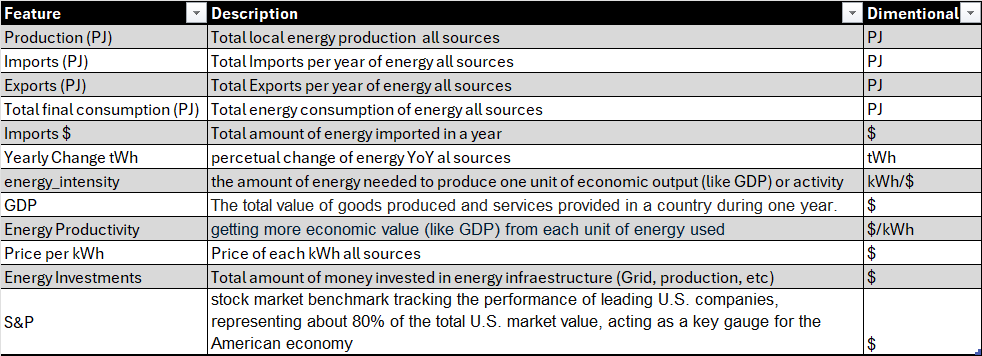

## Statistics (Univariate Analysis)

<p>A backup of the data base was stored in the last step of the prior section. This dataset is going to be loaded to execute all analysis in this section</p>

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT1tbQdBPje0qzXLSTW3h3KFGwOtNWHeyEiHeU2AyuMJUdcwHr39SAvTEiCNlF2VYSgo-19KdEEzgOA/pub?output=csv'
df_a = exploratory_analysis(url, sheet_name='TimeSeries_1971-2024')
df_a.run_all()

<p>as it can be seen, some data is not available for 2024 (it is preliminary data). Due to this CMAR scenario, the year is going to be dropped. all 2024 is going to be forecasted with properly trained data in the Machine Learning section</p>

In [ ]:
df_analysis = df_a.df
df_analysis.drop(columns='2024', inplace= True)
df_analysis

<p>To understand the data, a visual analysis in going to be performed and the best distribution is going to be selected from all features for countries. It is important to notice that all this functions are taken from CA1 - Diego Molina Grajeda </p>

In [ ]:
def plot_scatter(df, x_col='Year', y_col='', flow_name=''):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(df[x_col], df[y_col])
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    plt.suptitle(f'Boxplot of flow {flow_name}', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    plt.show()
    return ax

In [ ]:
def plot_histo(df, x_col='Year', y_col='', flow_name=''): 
    fig, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 7), gridspec_kw={'height_ratios': (.2, .8)}) 
    sns.boxplot(x=df[y_col], ax=ax_box) 
    ax_box.set_title(f'Boxplot of {y_col}', fontsize=12, fontweight='bold')
    #calculating # of bins for histogram 
    q25 = np.percentile(df[y_col], 25) 
    q75 = np.percentile(df[y_col], 75) 
    iqr = q75 - q25 
    n = len(df[y_col]) 
    bin_width = 2 * iqr / (n ** (1/3)) 
    # statistical formula to calculate bins/it must be an integer 
    num_bins = int(np.ceil((df[y_col].max() - df[y_col].min()) / bin_width)) 
    sns.histplot(data=df, x=y_col, ax=ax_hist, kde=True, bins=num_bins) 
    ax_hist.set_title(f'histogram of {y_col}', fontsize=12, fontweight='bold')
    kde_line = ax_hist.lines[0]
    kde_line.set_label('KDE')
    title_text = y_col
    plt.suptitle(title_text, fontweight='bold') 
    ax_hist.set_xlabel('Count') 
    ax_hist.set_ylabel('Frequency') 
    ax_hist.legend()
    plt.suptitle(f'Histogram and boxplot of {flow_name}', fontweight='bold')
    plt.show() 
    return fig, (ax_box, ax_hist)

In [ ]:
def dist_type(df, x_col='Year', y_col='', flow_name=''):
    distributions = [st.norm, st.expon, st.gamma, st.beta, st.lognorm, st.uniform, st.t, st.chi2, st.genlogistic, st.logistic, st.laplace]
    # discreate variables might be used for other datasets, so it is going to be defined here to use in the future if needed
    distributions_discr = [st.poisson, st.binom, st.nbinom, st.geom]  
    # distribution analysis
    dist_r = []
    if np.issubdtype(df[y_col].dtype, np.floating):
        discrete = False
        data_type = 'Continous'
    else:
        discrete = Truel 
        data_type = 'Discrete'
    if discrete:
    # for discreate features
    #chi squared test is discarded do to the size of the dataset... NaN is going to be the result all the time
        for distribution in distributions_discr:
            name = distribution.name
            mean = np.mean(df[y_col])
            n_obs = len(df[y_col])
            var = np.var(df[y_col])
            #nbinomial error will stop the loop. use try to avoid this
            try:
                if name == 'poisson':
                    params = (mean,)      
                elif name == 'binom':
                    n = np.ceil(df[y_col].max() * 1.1)
                    p = mean / n
                    if 0 < p < 1:   
                        params = (int(round(n)), p)
                    else:
                        raise ValueError('Invalid probability')     
                elif name == 'nbinom':
                    # number of successes and success prob
                    if var <= mean:
                        raise ValueError('Variance bigger than mean')
                    else:
                        p = mean / var
                        r = mean * p / (1 - p)
                        params = (r, p)     
                elif name == 'geom':
                    p = 1 / mean
                    params = (p,)
                if params is not None:
                    if name == 'nbinom' and params[0] <= 0:
                        raise ValueError('Values not capable of calculation')
                    else:
                        log_likelihood = np.sum(distribution.logpmf(df[y_col], *params))
                if params is not None and not np.isnan(log_likelihood):
                    k = len(params)
                    aic = 2 * len(params) - 2 * log_likelihood  
                    bic = k * np.log(n_obs) - 2 * log_likelihood
                    dist_r.append({'Distribution': name, 'AIC': aic, 'BIC': bic, 'LogLik': log_likelihood, 'Params': params})
            except Exception as e: 
                dist_r.append({'Distribution': name, 'AIC': np.nan, 'BIC': np.nan, 'LogLik': np.nan, 'Params': None})
    else:
    # for continous features
    #the loops needs to extract arguments, loc and scale in order to be able to perform log-likehood 
        for distribution in distributions:
            # some parameters might raise exceptions, since this is not being assess line by line to notice it, except procedure is needed
            try:
                parameters = distribution.fit(df[y_col])
                arg = parameters[:-2]
                loc = parameters[-2]
                scale = parameters[-1]
                #kolgomorov-smirov test 
                ks_stat, ks_p = st.kstest(df[y_col], distribution.name, args=parameters)
                # Log-likelihood 
                log_likelihood = np.sum(distribution.logpdf(df[y_col], *arg, loc=loc, scale=scale))
                k = len(parameters)
                aic = 2*k - 2*log_likelihood
                dist_r.append({'Distribution': distribution.name, 'AIC': aic, 'KS_stat': ks_stat, 'KS_p': ks_p, 'Params': parameters})
            except Exception as e:
                #skip errors/failures to fit
                dist_r.append({'Distribution': distribution.name, 'AIC': np.nan, 'KS_stat': np.nan, 'KS_p': np.nan, 'Params': None, 'Error': str(e)})
                continue
    disti_results_df = pd.DataFrame(dist_r).sort_values('AIC')
    return disti_results_df

In [ ]:
def plot_best_dist(df, x_col='Year', y_col='', flow_name=''):
    fig, ax_hist = plt.subplots(figsize=(10, 6))
    disti_results_df = dist_type(df, x_col=x_col, y_col=y_col)
    q25 = np.percentile(df[y_col], 25)
    q75 = np.percentile(df[y_col], 75)
    iqr = q75 - q25
    n = len(df[y_col])
    bin_width = 2 * iqr / (n ** (1/3))
    num_bins = int(np.ceil((df[y_col].max() - df[y_col].min()) / bin_width))
    dist_name = disti_results_df.iloc[0]['Distribution']
    params_best = disti_results_df.iloc[0]['Params']
    best_dist = getattr(st, dist_name)
    sns.histplot(data=df, x=y_col, ax=ax_hist, kde=False, bins=num_bins, stat='density', color='skyblue', edgecolor='black', label='Empirical Distribution')
    ax_hist.set_title(f'Histogram of {flow_name}', fontsize=12, fontweight='bold')
    ax_hist.set_xlabel(y_col)
    ax_hist.set_ylabel('Density')
    ax_hist.legend(['Empirical Distribution'])
    kind = df[y_col].dtype.kind
    #identy if feature is descrete or not i = signed integer, u = unsigned integer
    discrete = kind in ('i', 'u')  
    if discrete:
        mean = np.mean(df[y_col])
        std = np.std(df[y_col])
        support = np.arange(int(mean - 4*std), int(mean + 4*std) + 1)
        pmf = best_dist.pmf(support, *params_best)
        ax_hist.plot(support, pmf, 'r-', linewidth=2, label=f'{dist_name} PMF')
        ax_hist.set_title(f'Distribution Fit: {y_col}', fontsize=12, fontweight='bold')
        ax_hist.set_ylabel('Density')
    else:
        x = np.linspace(min(df[y_col]), max(df[y_col]), 1000)
        arg = params_best[:-2]
        loc = params_best[-2]
        scale = params_best[-1]
        pdf = best_dist.pdf(x, *arg, loc=loc, scale=scale)
        ax_hist.plot(x, pdf, 'r-', linewidth=2, label=f'{dist_name} PDF')
        ax_hist.set_title(f'Distribution Fit: {y_col}', fontsize=12, fontweight='bold')
        ax_hist.set_ylabel('Density')
    hist_heights, _ = np.histogram(df[y_col], bins=num_bins, density=True)
    max_hist_density = hist_heights.max() if len(hist_heights) > 0 else 1e-5
    ax_hist.set_ylim(0, max_hist_density * 1.3)
    ax_hist.set_xlabel(y_col)
    ax_hist.legend()
    plt.suptitle(f'Best fit distribution: {dist_name} Distribution - {flow_name}', fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    return fig, ax_hist

<p>In the following section, a visual analysis is going to be perform as follow:</p>

1. Scatter plot to identify trends
2. boxplot to identify outliers and hoistogram to understand the distribution of the data
3. calculation of the best fitting distribution based on AIC score
4. plot of best distribution to have a visual perspective 

### Visual Analysis - Ireland

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Ireland']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
df


In [ ]:
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_scatter(df_flow, 'Year', 'Value', flow)

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_histo(df_flow, 'Year', 'Value', flow)


<p>As it can see both in the boxplot and the scatter plot, there's something off about the GDP. It is going to be check if it is recurrent for all countries. If it is only an Irish case, it will be fixed as outlier, otherwise the flow is going to be dropped from all countries and reupload from the Worldback dataset</p>

In [ ]:
flows = df['Flow'].unique()
all_distributions = {}
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    dist_df = dist_type(df_flow, 'Year', 'Value', flow)
    all_distributions[flow] = dist_df
    print(flow)
    print(all_distributions[flow])

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_best_dist(df_flow, 'Year', 'Value', flow)

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_best_dist(df_flow, 'Year', 'Value', flow)

### Visual Analysis - Austria

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Austria']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_scatter(df_flow, 'Year', 'Value', flow)

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_histo(df_flow, 'Year', 'Value', flow)

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    dist_df = dist_type(df_flow, 'Year', 'Value', flow)
    all_distributions[flow] = dist_df
    print(flow)
    print(all_distributions[flow])

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_best_dist(df_flow, 'Year', 'Value', flow)

### Visual Analysis - Belgium

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Belgium']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_scatter(df_flow, 'Year', 'Value', flow)

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_histo(df_flow, 'Year', 'Value', flow)

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    dist_df = dist_type(df_flow, 'Year', 'Value', flow)
    all_distributions[flow] = dist_df
    print(flow)
    print(all_distributions[flow])

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_best_dist(df_flow, 'Year', 'Value', flow)

### Visual Analysis - Norway

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Norway']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_scatter(df_flow, 'Year', 'Value', flow)

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_histo(df_flow, 'Year', 'Value', flow)

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    dist_df = dist_type(df_flow, 'Year', 'Value', flow)
    all_distributions[flow] = dist_df
    print(flow)
    print(all_distributions[flow])

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_best_dist(df_flow, 'Year', 'Value', flow)

### Visual Analysis - Poland

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Poland']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_scatter(df_flow, 'Year', 'Value', flow)

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_histo(df_flow, 'Year', 'Value', flow)

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    dist_df = dist_type(df_flow, 'Year', 'Value', flow)
    all_distributions[flow] = dist_df
    print(flow)
    print(all_distributions[flow])

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_best_dist(df_flow, 'Year', 'Value', flow)

### Visual Analysis - Sweden

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Sweden']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_scatter(df_flow, 'Year', 'Value', flow)

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_histo(df_flow, 'Year', 'Value', flow)

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    dist_df = dist_type(df_flow, 'Year', 'Value', flow)
    all_distributions[flow] = dist_df
    print(flow)
    print(all_distributions[flow])

In [ ]:
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_best_dist(df_flow, 'Year', 'Value', flow)


<p>As it can be seen for all countries, the GDP is out of range, The dataset selected to append was the wrong one. It is going to be fixed to keep the dataset clean and homegenous</p>

In [ ]:
df_analysis = df_analysis.drop(df_analysis[df_analysis['Flow'] == 'GDP'].index)
countries = list(df_analysis['Country'].unique())
df_gdp_c = df_gdp.copy()
df_gdp_c.columns = [str(c) if isinstance(c, (int, float)) else c for c in df_gdp_c.columns]
df_gdp_c = df_gdp_c.drop(columns='1970')
df_gdp_c = df_gdp_c[df_gdp_c['Country Name'].isin(countries)]
df_gdp_c = df_gdp_c.rename(columns={'Country Name': 'Country'})
df_gdp_c.insert(1, 'Product', 'Total')
df_gdp_c.insert(2, 'Flow', 'GDP')
df_analysis = pd.concat([df_analysis, df_gdp_c], ignore_index=True)
df_analysis


In [ ]:
#As said before 2024 is going to be droppred and recalculated
df_analysis = df_analysis.drop(columns='2024')
df_analysis

### Descriptive Statistics - Ireland

<p>Descritive statistics are going to be calculated as follow:</p>

1. Computation of main descriptive statistics
2. Statistic analysis based on numerical results
3. Statistic interpretation
4. Statistic actionables

It is important to notice that the source of this code comes from CA1 - Diego Molina Grajeda

In [ ]:
def compute_statistics(df, exclude_columns=None):
    def safe_skew(x):
        return skew(x) if x.var() > 1e-10 else np.nan
    def safe_kurtosis(x):
        return kurtosis(x, fisher=True) if x.var() > 1e-10 else np.nan
    if exclude_columns is None:
        exclude_columns = []
    common_stats_list = ['mean', 'min', 'max', 'std', 'median', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan, 
                         lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), lambda x: x.max() - x.min(), safe_skew, safe_kurtosis, np.var]
    numerical = df.select_dtypes(include=np.number).columns
    target_cols = [col for col in numerical if col not in exclude_columns]

    df_statistics = df[target_cols].agg(common_stats_list).T
    df_statistics.columns = ['mean', 'min', 'max', 'std', 'median', 'mode', 'q25', 'q75', 'range', 'skew', 'kurtosis', 'var']
    df_statistics.index.name = 'Feature'
    df_statistics = df_statistics.reset_index()
    return df_statistics

In [ ]:
def analyze_statistics(df_statistics):
    analysis = []
    for _, row in df_statistics.iterrows():
        feature = row['Flow']
        mean_an = row['mean']
        is_numeric = isinstance(mean_an, (int, float, np.number)) and not pd.isna(mean_an)
        if not is_numeric:
            a = b = c = d = cv = 'Ordinal/Categorical Variable'
        else:
            median_an = row['median']
            delta = mean_an - median_an
            if delta > 0:
                a = 'Positive Skew'
            elif delta < 0:
                a = 'Negative Skew'
            else:
                a = 'Symmetric'
            skew_an = row['skew']
            if skew_an > 0.5:
                b = 'Right Skew (Long Tail to Right)'
            elif skew_an < -0.5:
                b = 'Left Skew (Long Tail to Left)'
            else:
                b = 'Symmetric'
            kurt_an = row['kurtosis']
            if kurt_an > 0.5:
                c = 'Leptokurtic'
            elif kurt_an < -0.5:
                c = 'Platikurtic'
            else:
                c = 'Mesokurtic'
            std_an = row['std']
            cv = std_an / mean_an if mean_an != 0 else np.nan
            mode_an = row['mode']
            if mode_an < median_an:
                d = 'Data peak is left of the center'
            elif mode_an > median_an:
                d = 'Data peak is right of the center'
            else:
                d = 'The most common value is the exact center'
        analysis.append([feature, a, b, c, d, cv])

    analysis_df = pd.DataFrame(analysis,columns=['Flow', 'Skew from center', 'Skew from value', 'Kurtosis interpretation', 'Mode-Median',
                                                 'Coefficient of variation'])
    analysis_df = analysis_df.merge(df_statistics['Flow'], on='Flow', how='left')
    return analysis_df

In [ ]:
def interpret_statistics(stats_temp):
    interpretation = []
    for _, row in stats_temp.iterrows():
        feature = row['Flow']
        cv = row['Coefficient of variation']
        skew_label = row['Skew from value']
        if 'Right' in skew_label:
            skew_dir = 1
        elif 'Left' in skew_label:
            skew_dir = -1
        else:
            skew_dir = 0
        if not isinstance(cv, (int, float, np.number)) or pd.isna(cv):
            conclusion = 'Data needs to be encoded, use data from frequency analysis'
        else:
            cv_val = float(cv)
            if cv_val >= 0.3:
                conclusion = 'Highly disperse data. It can be unpredictable.'
                if skew_dir > 0:
                    conclusion += ' Skew indicates a large number of high-value outliers.'
                elif skew_dir < 0:
                    conclusion += ' Data clustering may be pulling down the mean.'
                else:
                    conclusion += ' Approximately symmetric spread of data.'

            elif cv_val >= 0.1:
                conclusion = 'There is a noticeable variation in the data.'
                if skew_dir > 0:conclusion += (' Outliers may be influencing the mean. '
                                               'A chart is recommended to check trend changes.')
                elif skew_dir < 0:
                    conclusion += (' Clustering of high values with extreme low-value '
                                   'outliers pulling the mean down.')
                else:
                    conclusion += ' Symmetry suggests predictability.'
            else:
                conclusion = ('Reliable feature. Data is concentrated around the mean; '
                              'skew analysis is less critical due to high data quality.')
        interpretation.append({'Flow': feature, 'Conclusion': conclusion})
    return pd.DataFrame(interpretation)

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Ireland']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flow = list(df['Flow'].unique())
statistics = {}
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    analysis = compute_statistics(df_flow, ['Country', 'Product', 'Flow'])
    statistics[flow] = analysis
df_statistics = (pd.concat(statistics, names=['Flow', 'Feature']).reset_index(level=0).reset_index(drop=True))
df_statistics = df_statistics.drop(columns='Feature') 
df_statistics

In [ ]:
stats_temp = analyze_statistics(df_statistics)
stats_temp

In [ ]:
conclution = interpret_statistics(stats_temp)
conclution.to_csv('conclution_ireland.csv')

### Descriptive Statistics - Austria

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Austria']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flow = list(df['Flow'].unique())
statistics = {}
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    analysis = compute_statistics(df_flow, ['Country', 'Product', 'Flow'])
    statistics[flow] = analysis
df_statistics = (pd.concat(statistics, names=['Flow', 'Feature']).reset_index(level=0).reset_index(drop=True))
df_statistics = df_statistics.drop(columns='Feature') 
df_statistics

In [ ]:
stats_temp = analyze_statistics(df_statistics)
stats_temp

In [ ]:
conclution = interpret_statistics(stats_temp)
conclution.to_csv('conclution_austria.csv')
conclution

### Descriptive Statistics - Belgium

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Belgium']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flow = list(df['Flow'].unique())
statistics = {}
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    analysis = compute_statistics(df_flow, ['Country', 'Product', 'Flow'])
    statistics[flow] = analysis
df_statistics = (pd.concat(statistics, names=['Flow', 'Feature']).reset_index(level=0).reset_index(drop=True))
df_statistics = df_statistics.drop(columns='Feature') 
df_statistics

In [ ]:
stats_temp = analyze_statistics(df_statistics)
stats_temp

In [ ]:
conclution = interpret_statistics(stats_temp)
conclution.to_csv('conclution_belgium.csv')
conclution

### Descriptive Statistics - Norway

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Norway']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flow = list(df['Flow'].unique())
statistics = {}
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    analysis = compute_statistics(df_flow, ['Country', 'Product', 'Flow'])
    statistics[flow] = analysis
df_statistics = (pd.concat(statistics, names=['Flow', 'Feature']).reset_index(level=0).reset_index(drop=True))
df_statistics = df_statistics.drop(columns='Feature') 
df_statistics

In [ ]:
stats_temp = analyze_statistics(df_statistics)
stats_temp

In [ ]:
conclution = interpret_statistics(stats_temp)
conclution.to_csv('conclution_norway.csv')
conclution

### Descriptive Statistics - Poland

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Poland']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flow = list(df['Flow'].unique())
statistics = {}
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    analysis = compute_statistics(df_flow, ['Country', 'Product', 'Flow'])
    statistics[flow] = analysis
df_statistics = (pd.concat(statistics, names=['Flow', 'Feature']).reset_index(level=0).reset_index(drop=True))
df_statistics = df_statistics.drop(columns='Feature') 
df_statistics

In [ ]:
stats_temp = analyze_statistics(df_statistics)
stats_temp

In [ ]:
conclution = interpret_statistics(stats_temp)
conclution.to_csv('conclution_poland.csv')
conclution

### Descriptive Statistics - Sweden

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Sweden']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flow = list(df['Flow'].unique())
statistics = {}
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    analysis = compute_statistics(df_flow, ['Country', 'Product', 'Flow'])
    statistics[flow] = analysis
df_statistics = (pd.concat(statistics, names=['Flow', 'Feature']).reset_index(level=0).reset_index(drop=True))
df_statistics = df_statistics.drop(columns='Feature') 
df_statistics

In [ ]:
stats_temp = analyze_statistics(df_statistics)
stats_temp

In [ ]:
conclution = interpret_statistics(stats_temp)
conclution.to_csv('conclution_sweden.csv')
conclution

<p>Based on this insights provided by the statistic analysis the following can be identify:</p>

1. For highly skewed and volatile features, simple averages or linear forecasts would underestimate extreme outcomes. Those models might be discarded (it will be proved anyways, as part of the academic project). A Montecarlo Simulation is going to be run to capture the uncertainty and heavy tails.
2. Stable flows can rely on normal or beta-based forecasts
3. low variable flows benefit from quantile regression or distribution-aware models to capture extremes without overcomplicating the model.
4. QQ plots are going to be run to identify opportunities to normalize features for each country

<p>All of this can be found in the Applied statistics section</p>

### Inferential Statistics (single country) - Ireland

<p>For each of the countries the following steps and calculations are going to be performed:</p>

1. For each feature a Shapiro-Wilk test is going to be calculated
2. For the target features (Consumption, Imports) a t-test is going to be performed comparing to each of the other features (if Normality doesnt hold, Mann-Withney is calculated)
3. For each Feature, z-test is performed
   



In [ ]:
def feature_inferential(df, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = ['Country', 'Product', 'Flow']
    value_columns = [col for col in df.columns if col not in exclude_columns]
    results = []
    for _, row in df.iterrows():
        feature_name = row['Flow']
        feature_data = row[value_columns].apply(pd.to_numeric, errors='coerce').values
        feature_data = feature_data[~np.isnan(feature_data)]
        if len(feature_data) < 3:
            continue
        #Shapiro-Wilk normality
        shap_stat, shap_p = shapiro(feature_data)
        normal = shap_p >= 0.05
        #Z-test using CLT
        np.random.seed(42)
        sample_means = [np.mean(np.random.choice(feature_data, size=30, replace=True)) for _ in range(1000)]
        pop_mean = np.mean(feature_data)
        sample_mean = np.mean(sample_means)
        sample_std = np.std(sample_means, ddof=1)
        z_score = (sample_mean - pop_mean) / (sample_std / np.sqrt(len(sample_means)))
        p_value_z = 2 * (1 - norm.cdf(abs(z_score)))
        results.append({'Feature': feature_name, 'Feature_normal': normal, 'Feature_shap_stat': shap_stat, 'Feature_shap_p': shap_p, 'Z_score': z_score,
                        'Z_p': p_value_z})
    return pd.DataFrame(results)

In [ ]:
def target_inferential(df, target_features=['Imports (PJ)', 'Total final consumption (PJ)'], exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = ['Country', 'Product', 'Flow']
    value_columns = [col for col in df.columns if col not in exclude_columns]
    results = []
    for target in target_features:
        target_row = df[df['Flow'] == target]
        if target_row.empty:
            print(f"Warning: target {target} not found")
            continue   
        target_data = target_row[value_columns].apply(pd.to_numeric, errors='coerce').values.flatten()
        target_data = target_data[~np.isnan(target_data)]
        if len(target_data) < 3:
            continue
        #Normality of target
        target_shap_stat, target_shap_p = shapiro(target_data)
        target_normal = target_shap_p >= 0.05
        for _, row_feature in df.iterrows():
            feature_name = row_feature['Flow']
            if feature_name in target_features:
                continue
            feature_data = row_feature[value_columns].apply(pd.to_numeric, errors='coerce').values
            feature_data = feature_data[~np.isnan(feature_data)]
            if len(feature_data) < 3:
                continue
            shap_stat, shap_p = shapiro(feature_data)
            normal = shap_p >= 0.05
            #T-test or Mann-Whitney depending on normality
            if normal and target_normal:
                stat, p = ttest_ind(feature_data, target_data, equal_var=False)
                test_name = 'T-test'
            else:
                stat, p = mannwhitneyu(feature_data, target_data, alternative='two-sided')
                test_name = 'Mann-Whitney'
            results.append({'Feature': feature_name, 'Target': target, 'Feature_normal': normal, 'Target_normal': target_normal, 'Feature_shap_stat': shap_stat,
                            'Feature_shap_p': shap_p, 'Target_shap_stat': target_shap_stat, 'Target_shap_p': target_shap_p, 'Test': test_name, 'Test_stat': stat,
                            'Test_p': p})
    return pd.DataFrame(results)

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Ireland']
df_inferential = feature_inferential(df_pivot)
df_inferential

<p>The following can be interpretated from the analysis:</p>

1. Shap_p value < .05 Reject H₀ (Data is NOT normally distributed) for all features
2. Z_p < .05 Reject H₀ (Sample mean ≠ population mean) for the feature production. There has been fluctuations in the energy production in Ireland
3. All else Fail to reject H₀ (Sample mean ≈ population mean)


In [ ]:
df_inferential_1 = target_inferential(df_pivot)
df_inferential_1

<p>The following can be interpretated from the analysis:</p>

1. Test_p value < .05 Reject H₀ ( Reject H₀: Distributions differ between groups) for all features


### Inferential Statistics (single country) - Austria

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Austria']
df_inferential = feature_inferential(df_pivot)
df_inferential

<p>The following can be interpretated from the analysis:</p>

1. Shap_p value < .05 Reject H₀ (Data is NOT normally distributed) for all features excluding Price per kWh.
3. All features fails ail to reject H₀ (Sample mean ≈ population mean)

In [ ]:
df_inferential_1 = target_inferential(df_pivot)
df_inferential_1

<p>The following can be interpretated from the analysis:</p>

1. Test_p value < .05 Reject H₀ ( Reject H₀: Distributions differ between groups) for all features

### Inferential Statistics (single country) - Belgium

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Belgium']
df_inferential = feature_inferential(df_pivot)
df_inferential

<p>The following can be interpretated from the analysis:</p>

1. Shap_p value < .05 Reject H₀ (Data is NOT normally distributed) for all features excluding Exports and Yearly Change.
3. All features fails to reject H₀ (Sample mean ≈ population mean)

In [ ]:
df_inferential_1 = target_inferential(df_pivot)
df_inferential_1

<p>The following can be interpretated from the analysis:</p>

1. Test_p value < .05 Reject H₀ ( Reject H₀: Distributions differ between groups) for all features

### Inferential Statistics (single country) - Norway

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Norway']
df_inferential = feature_inferential(df_pivot)
df_inferential

<p>The following can be interpretated from the analysis:</p>

1. Shap_p value < .05 Reject H₀ (Data is NOT normally distributed) for all features excluding Yearly Change.
3. All features fails to reject H₀ (Sample mean ≈ population mean)

In [ ]:
df_inferential_1 = target_inferential(df_pivot)
df_inferential_1

<p>The following can be interpretated from the analysis:</p>

1. Test_p value < .05 Reject H₀ ( Reject H₀: Distributions differ between groups) for all features

### Inferential Statistics (single country) - Norway

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Norway']
df_inferential = feature_inferential(df_pivot)
df_inferential

<p>The following can be interpretated from the analysis:</p>

1. Shap_p value < .05 Reject H₀ (Data is NOT normally distributed) for all features excluding Yearly Change.
3. All features fails to reject H₀ (Sample mean ≈ population mean)

In [ ]:
df_inferential_1 = target_inferential(df_pivot)
df_inferential_1

<p>The following can be interpretated from the analysis:</p>

1. Test_p value < .05 Reject H₀ ( Reject H₀: Distributions differ between groups) for all features

### Inferential Statistics (single country) - Poland

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Poland']
df_inferential = feature_inferential(df_pivot)
df_inferential

<p>The following can be interpretated from the analysis:</p>

1. Shap_p value < .05 Reject H₀ (Data is NOT normally distributed) for all features excluding Total Final Consumption.
3. All features fails to reject H₀ (Sample mean ≈ population mean)

In [ ]:
df_inferential_1 = target_inferential(df_pivot)
df_inferential_1

<p>The following can be interpretated from the analysis:</p>

1. Test_p value < .05 Reject H₀ ( Reject H₀: Distributions differ between groups) for all feature

### Inferential Statistics (single country) - Sweden

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Sweden']
df_inferential = feature_inferential(df_pivot)
df_inferential

<p>The following can be interpretated from the analysis:</p>

1. Shap_p value < .05 Reject H₀ (Data is NOT normally distributed) for all features excluding Imports, Exports, Year change and final consumption.
3. All features fails to reject H₀ (Sample mean ≈ population mean)

In [ ]:
df_inferential_1 = target_inferential(df_pivot)
df_inferential_1

<p>The following can be interpretated from the analysis:</p>

1. Test_p value < .05 Reject H₀ ( Reject H₀: Distributions differ between groups) for all feature excluding production Production which fails to reject H₀ (No significant difference)

### Inferential Statistics - Ireland Hypothesis testing vs All (task 3 statistics)

<p>The following hypothesis are going to be tested:</p>

1. Ireland’s energy imports are at least one standard deviation above its peers
2. Ireland’s GDP–energy consumption correlation is weaker than that of other countries
3. Ireland’s final energy consumption relies more heavily on imports than other countries
4. Ireland’s median energy imports differ from the rest of Europe
5. Ireland’s energy infrastructure differs from other countries

<h4>hypothesys 1</h4>

In [ ]:
year_cols = [col for col in df_analysis.columns if col.isdigit()]
df_long = df_analysis.melt(id_vars=['Country', 'Product', 'Flow'], value_vars=year_cols, var_name='Year', value_name='Value')
df_long['Year'] = df_long['Year'].astype(int)
df_ireland = df_long[df_long['Country'] == 'Ireland']
df_peers = df_long[(df_long['Country'] != 'Ireland') & (df_long['Country'] != 'Global')]
ireland_imports = df_ireland[df_ireland['Flow'] == 'Imports (PJ)']['Value'].dropna()
peers_imports = df_peers[df_peers['Flow'] == 'Imports (PJ)']['Value'].dropna()
peers_mean = peers_imports.mean()
peers_std = peers_imports.std()
benchmark = peers_mean + peers_std
shapiro_test_h1 = shapiro(ireland_imports)
print('Shapiro-Wilk Test (Ireland Imports):', shapiro_test_h1)
t_stat_h1, p_value_h1 = ttest_1samp(ireland_imports, benchmark)
p_value_h1_one_tailed = p_value_h1 / 2
print('H1 t-statistic:', t_stat_h1)
print('H1 one-tailed p-value:', p_value_h1_one_tailed)

<p>The hypotesys 1 (Ireland's energy imports at least 1std above peers) is rejected. In fact, Irish imports are lower than its peers</p>

<h4>Hypothesis 2</h4>

In [ ]:
ireland_gdp = df_ireland[df_ireland['Flow'] == 'GDP'].sort_values('Year')['Value'].values
ireland_consumption = df_ireland[df_ireland['Flow'] == 'Total final consumption (PJ)'].sort_values('Year')['Value'].values
r_ireland, _ = stats.pearsonr(ireland_gdp, ireland_consumption)
peer_countries = df_peers['Country'].unique()
peer_correlations = []
for country in peer_countries:
    gdp_df = df_peers[
        (df_peers['Country'] == country) & (df_peers['Flow'] == 'GDP')][['Year', 'Value']].rename(columns={'Value': 'GDP'})
    cons_df = df_peers[(df_peers['Country'] == country) & (df_peers['Flow'] == 'Total final consumption (PJ)')][['Year', 'Value']].rename(columns={'Value': 'Cons'})
    merged = pd.merge(gdp_df, cons_df, on='Year').dropna()
    if len(merged) > 3:
        r, p = stats.pearsonr(merged['GDP'], merged['Cons'])
        if not np.isnan(r):
            peer_correlations.append(r)
r_peers_mean = np.mean(peer_correlations)
#fisher z transformation
z_ireland = np.arctanh(r_ireland)
z_peers = np.arctanh(r_peers_mean)
n_ireland = len(ireland_gdp)
n_peers = len(peer_correlations)
z_stat = (z_ireland - z_peers) / np.sqrt((1/(n_ireland - 3)) + (1/(n_peers - 3)))
p_value_h2 = stats.norm.cdf(z_stat)
print('Ireland correlation:', r_ireland)
print('Peers mean correlation:', r_peers_mean)
print('H2 z-statistic:', z_stat)
print('H2 one-tailed p-value:', p_value_h2)

<p>Fail to reject H₀. There is no evidence that Ireland’s GDP–energy consumption correlation is weaker than that of peers. In fact, Ireland’s correlation is slightly stronger, not weaker</p>

<h4>Hypothesys 3</h4>

In [ ]:
ireland_imports = df_ireland[df_ireland['Flow'] == 'Imports (PJ)'].sort_values('Year')['Value'].values
ireland_consumption = df_ireland[df_ireland['Flow'] == 'Total final consumption (PJ)'].sort_values('Year')['Value'].values
ireland_dependency = ireland_imports / ireland_consumption
peer_dependency = []
for country in peer_countries:
    imp = df_peers[
        (df_peers['Country'] == country) & (df_peers['Flow'] == 'Imports (PJ)')].sort_values('Year')['Value'].values
    cons = df_peers[(df_peers['Country'] == country) & (df_peers['Flow'] == 'Total final consumption (PJ)')].sort_values('Year')['Value'].values
    if len(imp) == len(cons):
        peer_dependency.extend(imp / cons)
peer_dependency = np.array(peer_dependency)
levene_test_h3 = levene(ireland_dependency, peer_dependency)
print('Levene test:', levene_test_h3)
t_stat_h3, p_value_h3 = stats.ttest_ind(ireland_dependency, peer_dependency, equal_var=False)
p_value_h3_one_tailed = p_value_h3 / 2
print('H3 t-statistic:', t_stat_h3)
print('H3 one-tailed p-value:', p_value_h3_one_tailed)

<p>Reject H₀. Ireland’s energy consumption relies way more on energy imports than european peer countries</p>

<h4>Hypothesis 4</h4>

In [ ]:
u_stat_h4, p_value_h4 = mannwhitneyu(ireland_imports, peers_imports, alternative="two-sided")
print('H4 Mann–Whitney U statistic:', u_stat_h4)
print('H4 p-value:', p_value_h4)

<p>reject null hypothesis H₀ Ireland’s median imports are different from the rest of Europe</p>

<h4>Hypothesis 5</h4>

In [ ]:
ireland_invest = df_ireland[df_ireland['Flow'] == 'Energy Investments'].sort_values('Year')['Value'].dropna()
peers_invest = df_peers[df_peers['Flow'] == 'Energy Investments'].sort_values('Year')['Value'].dropna()
combined = pd.concat([ireland_invest, peers_invest])
bins = pd.qcut(combined, q=3, labels=['Low', 'Medium', 'High'])
ireland_cat = pd.qcut(ireland_invest, q=3, labels=['Low', 'Medium', 'High'])
peers_cat = pd.qcut(peers_invest, q=3, labels=['Low', 'Medium', 'High'])
contingency = pd.crosstab(index=pd.Series(['Ireland']*len(ireland_cat) + ['Peers']*len(peers_cat)),columns=pd.Series(list(ireland_cat) + list(peers_cat)))
print(contingency)
chi2_stat, p_value_h5, dof, expected = chi2_contingency(contingency)
print("Chi-squared statistic:", chi2_stat)
print("Degrees of freedom:", dof)
print("H5 p-value:", p_value_h5)


<p>fail to reject null hypothesis H₀. No significant difference in the distribution of energy investments between Ireland and peer countries</p>

### Appliend Statistics

<p>As seen in the descriptive statistics section, applied statistics is going to be used to determine how to transform data (if needed) or leave the dataframe as it is</p>

<p>In this section the following tools are going to be used:</p>

1. I charts to analyze the time series to define if outliers are a change of trend or scenarios that are needed to address
2. QQ plots to determine if normalization is plausible for some features
3. Montecarlo Simulation is going to be run to capture the uncertainty and heavy tails.
4. z-score analysis to identify feature engineer opportunitites

In [ ]:
def plot_icharts(df, x_col='Year', y_cols=None, window_size=3, figsize=(12, 6)):
    if y_cols is None:
        raise ValueError("y_cols must be a list of column names")
    year = df[x_col]
    flow_name = df['Flow'].iloc[0]  # assumes df is filtered to one Flow
    for col in y_cols:
        data = df[col]
        mean = data.mean()
        std = data.std()
        ucl = mean + 3 * std
        ucl1 = mean + 2 * std
        lcl = mean - 3 * std
        lcl1 = mean - 2 * std
        plt.figure(figsize=figsize)
        plt.plot(year, data, marker='o', label=col)
        plt.axhline(mean, color='green', linestyle='--', label='Mean')
        plt.axhline(ucl1, color='yellow', linestyle='--', label='UCL1')
        plt.axhline(lcl1, color='yellow', linestyle='--', label='LCL1')
        plt.axhline(ucl, color='red', linestyle='--', label='UCL')
        plt.axhline(lcl, color='orange', linestyle='--', label='LCL')
        plt.title(f'I-Chart for {col} | Flow: {flow_name} (Mean)')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        rolling_mean = data.rolling(window=window_size, min_periods=1).mean()
        rolling_std = data.rolling(window=window_size, min_periods=1).std()
        rolling_ucl = rolling_mean + 3 * rolling_std
        rolling_ucl1 = rolling_mean + 2 * rolling_std
        rolling_lcl = rolling_mean - 3 * rolling_std
        rolling_lcl1 = rolling_mean - 2 * rolling_std
        plt.figure(figsize=figsize)
        plt.plot(year, data, marker='o', label=col)
        plt.plot(year, rolling_mean, color='green', linestyle='--', label='Rolling Mean')
        plt.plot(year, rolling_ucl1, color='yellow', linestyle='--', label='Rolling UCL1')
        plt.plot(year, rolling_lcl1, color='yellow', linestyle='--', label='Rolling LCL1')
        plt.plot(year, rolling_ucl, color='red', linestyle='--', label='Rolling UCL')
        plt.plot(year, rolling_lcl, color='orange', linestyle='--', label='Rolling LCL')
        plt.title(f'I-Chart for {col} | Flow: {flow_name} (Rolling Mean)')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
def plot_qq_transformations(df, y_cols=None, figsize=(12, 6)):
    if y_cols is None:
        raise ValueError('y_cols must be a list of column names')   
    flow_name = df['Flow'].iloc[0]  
    for col in y_cols:
        data = df[col].dropna()
        if data.empty:
            continue      
        plots = []
        transformations = []
        #Original
        plots.append(('Original', data))
        transformations.append(data)
        #Log
        if data.min() > 0:
            plots.append(('Log', np.log(data)))
            transformations.append(np.log(data))
        else:
            plots.append(('Log1p', np.log1p(data)))
            transformations.append(np.log1p(data))
        #Box-Cox (positive only)
        if (data > 0).all():
            boxcox_data, _ = stats.boxcox(data)
            plots.append(('Box-Cox', boxcox_data))
            transformations.append(boxcox_data)
        #Yeo-Johnson
        yj_data, _ = stats.yeojohnson(data)
        plots.append(('Yeo-Johnson', yj_data))
        transformations.append(yj_data)

        fig, axes = plt.subplots(1, len(plots), figsize=figsize)
        if len(plots) == 1:
            axes = [axes]
        for ax, (name, transformed) in zip(axes, plots):
            (theoretical, sample), (slope, intercept, _) = stats.probplot(transformed, dist='norm', plot=None)
            ax.plot(theoretical, sample, 'o', alpha=0.7)
            ax.plot(theoretical, slope * theoretical + intercept, 'r-')
            ax.set_title(name)
            ax.grid(alpha=0.3)
        fig.suptitle(f'Q–Q Transformation Comparison — {col} | Flow: {flow_name}', fontsize=14)
        plt.tight_layout()
        plt.show()

        print(f"\nNormality check for feature '{col}' | Flow: {flow_name}")
        best_trans = None
        best_p = -1
        for name, transformed in zip([p[0] for p in plots], transformations):
            stat, p = stats.shapiro(transformed)
            print(f'{name:<12} | Shapiro-Wilk p-value: {p:.4f}')
            if p > best_p:
                best_p = p
                best_trans = name
        if best_p > 0.05:
            print(f'Transformation likely usable: {best_trans} (p={best_p:.4f})\n')
        else:
            print('No transformation achieves normality (all p<=0.05)\n')

In [ ]:
def monte_carlo_transformed(df, y_cols=None, n_sim=10000):
    if y_cols is None:
        raise ValueError('y_cols must be a list of column names') 
    flow_name = df['Flow'].iloc[0]
    results = {}
    for col in y_cols:
        data = df[col].dropna()
        if data.empty:
            continue
        transformations = {'Original': data}
        transformations['Log'] = np.log(data) if data.min() > 0 else np.log1p(data)
        if (data > 0).all():
            transformations['Box-Cox'], _ = stats.boxcox(data)
        transformations['Yeo-Johnson'], _ = stats.yeojohnson(data)
        best_trans = None
        best_p = -1
        for name, transformed in transformations.items():
            _, p = stats.shapiro(transformed)
            if p > best_p:
                best_p = p
                best_trans = name
        best_data = transformations[best_trans]
        #Non-parametric Monte Carlo simulation
        simulated = np.random.choice(best_data, size=n_sim, replace=True)
        results[col] = {'best_transformation': best_trans, 'mean': np.mean(simulated), 'median': np.median(simulated), 
                        'p05': np.percentile(simulated, 5), 'p95': np.percentile(simulated, 95), 'simulations': simulated}
        print(f'Flow: {flow_name} | Feature: {col} | Best transformation: {best_trans}')
        if best_p <= 0.05:
            print(f"WARNING: Feature '{col}' | Flow '{flow_name}' is far from normal (p={best_p:.4f}).")
            print("Non-parametric Monte Carlo will still be used; parametric simulation would be unreliable.\n")
        print(f'Mean: {results[col]["mean"]:.4f}, Median: {results[col]["median"]:.4f}, '
              f'5th percentile: {results[col]["p05"]:.4f}, 95th percentile: {results[col]["p95"]:.4f}\n')
    return results

In [ ]:
def zscore(df, x_col='Year', feature_col='Value', flow_col='Flow', window=None, threshold=2.0, method='global'):
    candidates = {}
    for flow in df[flow_col].unique():
        df_flow = df[df[flow_col] == flow].copy()
        df_flow = df_flow.sort_values(x_col)
        values = df_flow[feature_col].values
        if method == 'global' or window is None:
            mu = np.mean(values)
            sigma = np.std(values)
            z_scores = (values - mu) / sigma
        elif method == 'rolling':
            z_scores = (values - pd.Series(values).rolling(window, min_periods=1).mean()) / \
                       pd.Series(values).rolling(window, min_periods=1).std()
        else:
            raise ValueError("method must be 'global' or 'rolling'")
        flagged_years = df_flow[x_col].iloc[np.where(np.abs(z_scores) > threshold)[0]].tolist()
        candidates[flow] = flagged_years
    return candidates

<h4>I-Charts - Ireland</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Ireland']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_icharts(df_flow, x_col='Year', y_cols=['Value'], window_size=3)


<p>As it can be seen, in the case of Ireland, all outliers are showing a systematic shock in the economy (2008 financial crisis or Covid. If this is a persistent scenario for all countries, a dummy variable for financial crisis (not only 2008 but the ones known in the timeline of this study) and covid are going to be set as dummy features to improve the quality of the model</p>

<h4>I-Charts - Austria</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Austria']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_icharts(df_flow, x_col='Year', y_cols=['Value'], window_size=3)

<h4>I-Charts - Belgium</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Belgium']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_icharts(df_flow, x_col='Year', y_cols=['Value'], window_size=3)

<h4>I-Charts - Poland</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Poland']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_icharts(df_flow, x_col='Year', y_cols=['Value'], window_size=3)

<p>For Poland, another shock is detected in the charts. The colapse of the Soviet Union and the shift to a capitalism based econony at the begining of the 90s</p>

<h4>I-Charts - Norway</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Norway']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_icharts(df_flow, x_col='Year', y_cols=['Value'], window_size=3)

<h4>I-Charts - Sweden</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Sweden']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_icharts(df_flow, x_col='Year', y_cols=['Value'], window_size=3)

<p>As seen in all charts, the financial/industrial shocks are noticed for all countries. The dummi features are going to be implemented in the data engineering section of this study </p>

<h4>QQ Plots - Ireland</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Ireland']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_qq_transformations(df_flow, y_cols=['Value'])

<h4>QQ Plot - Austria</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Austria']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_qq_transformations(df_flow, y_cols=['Value'])

<h4>QQ Plots - Belgium</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Belgium']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_qq_transformations(df_flow, y_cols=['Value'])

<h4>QQ Plots - Norway</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Norway']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_qq_transformations(df_flow, y_cols=['Value'])

<h4>QQ Plots - Poland</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Poland']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_qq_transformations(df_flow, y_cols=['Value'])

<h4>QQ Plots - Sweden</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Sweden']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
flows = df['Flow'].unique()
for flow in flows:
    df_flow = df[df['Flow'] == flow]
    plot_qq_transformations(df_flow, y_cols=['Value'])

<p>in the data engineer section, this insights are going to be applied to transform the data and have a more reliable dataset for modeling</p>

<h4>Monte Carlo Simulation - Ireland</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Ireland']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
monte_carlo_results = {}
for flow in df['Flow'].unique():
    df_flow = df[df['Flow'] == flow]
    monte_carlo_results[flow] = monte_carlo_transformed(df_flow, y_cols=['Value'])

<h4>Monte Carlo Simulation - Austria</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Austria']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
monte_carlo_results = {}
for flow in df['Flow'].unique():
    df_flow = df[df['Flow'] == flow]
    monte_carlo_results[flow] = monte_carlo_transformed(df_flow, y_cols=['Value'])

<h4>Montecarlo Simulation - Belgium</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Belgium']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
monte_carlo_results = {}
for flow in df['Flow'].unique():
    df_flow = df[df['Flow'] == flow]
    monte_carlo_results[flow] = monte_carlo_transformed(df_flow, y_cols=['Value'])

<h4>Montecarlo Simulation - Norway</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Norway']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
monte_carlo_results = {}
for flow in df['Flow'].unique():
    df_flow = df[df['Flow'] == flow]
    monte_carlo_results[flow] = monte_carlo_transformed(df_flow, y_cols=['Value'])

<h4>Montecarlo Simulation - Poland</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Poland']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
monte_carlo_results = {}
for flow in df['Flow'].unique():
    df_flow = df[df['Flow'] == flow]
    monte_carlo_results[flow] = monte_carlo_transformed(df_flow, y_cols=['Value'])

<h4>Montecarlo Simulation - Sweden</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Sweden']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
monte_carlo_results = {}
for flow in df['Flow'].unique():
    df_flow = df[df['Flow'] == flow]
    monte_carlo_results[flow] = monte_carlo_transformed(df_flow, y_cols=['Value'])

<p>Montecarlo Simulations confirm the findings in QQ plot. Selected features for each country are going to be transformed as stated in the results</p>

<h4>Z-Scores - Ireland</h4>

<p>Using the zscore function defined at the beging of this section, z-scores is going to be used to identify years in which the behaviour is out of 2sigma in order to be able to design a better feature engineer process </p>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Ireland']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'],var_name='Year', value_name='Value')
zscore_candidates = zscore(df, x_col='Year', feature_col='Value', flow_col='Flow', threshold=2)
print(zscore_candidates)

<h4>Z-Scores - Austria</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Austria']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'],var_name='Year', value_name='Value')
zscore_candidates = zscore(df, x_col='Year', feature_col='Value', flow_col='Flow', threshold=2)
print(zscore_candidates)

<h4>Z-Scores - Belgium</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Belgium']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'],var_name='Year', value_name='Value')
zscore_candidates = zscore(df, x_col='Year', feature_col='Value', flow_col='Flow', threshold=2)
print(zscore_candidates)

<h4>Z-Scores - Norway</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Norway']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'],var_name='Year', value_name='Value')
zscore_candidates = zscore(df, x_col='Year', feature_col='Value', flow_col='Flow', threshold=2)
print(zscore_candidates)

<h4>Z-Scores - Poland</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Poland']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'],var_name='Year', value_name='Value')
zscore_candidates = zscore(df, x_col='Year', feature_col='Value', flow_col='Flow', threshold=2)
print(zscore_candidates)

<h4>Z-Scores - Sweden</h4>

In [ ]:
df_pivot = df_analysis[df_analysis['Country'] == 'Sweden']
df = df_pivot.melt(id_vars=['Country', 'Product', 'Flow'],var_name='Year', value_name='Value')
zscore_candidates = zscore(df, x_col='Year', feature_col='Value', flow_col='Flow', threshold=2)
print(zscore_candidates)

<p>It can be seen that 2 flows repeats consistently in all countries:</p>

1. Energy Imports $ in 2022. Driven by a big hike in natural gas prices, as consequence of the war in ukraine
2. Energy investments in 2022 and 2023. Driven by Paris agreements and policy changes places by Brussels

<p>Dummy features are going to be set for this years</p>

## Data Transformation

<p>As stated in the data gathering sectionm energy investments dataset wasn't approved to be used for Machine learning purposes. The dataset is dropped as first stage of this section to comply with the data licencing</p>

In [ ]:
df_transformed = df_analysis.copy()
df_transformed = df_transformed[df_transformed['Flow'] != 'Energy Investments']
df_transformed['Flow'].unique()

<p>Now that the data complies with lincencing, the dataframe, based on the Applied Statistics section findings, is going to be transformed as followed:</p>

1. A dictionary is created to map the features to be transformed
2. A function is created to apply the transformation
3. A quick validation to confirm that all transformations where applied

In [ ]:
transform_map = {'Yeo-Johnson': {'Ireland': ['Imports $'], 'Austria': ['Imports $', 'Yearly Change tWh'],
                                      'Belgium': ['Exports (PJ)', 'Imports (PJ)', 'Yearly Change tWh', 'energy_intensity'],
                                      'Norway': ['Yearly Change tWh'], 'Poland': ['Exports (PJ)', 'Yearly Change tWh'], 'Sweden': ['Imports (PJ)', 'Yearly Change tWh'],},
                      'Box-Cox': {'Ireland': ['Energy Productivity', 'Price per kWh'], 'Austria': ['Energy Productivity'], 'Belgium': ['Energy Productivity'],
                                  'Norway': ['Energy Productivity', 'Imports (PJ)', 'Price per kWh'], 'Poland': ['Total final consumption (PJ)', 'Price per kWh'],
                                  'Sweden': ['Total final consumption (PJ)'],},
                      'Log': {'Austria': ['Price per kWh']}}

In [ ]:
def apply_transformations(df, transform_map, value_col='Value', country_col='Country', flow_col='Flow'):
    df = df.copy()
    df['Value_transformed'] = np.nan
    df['Transformation'] = 'None'
    df['Lambda'] = np.nan
    for method, country_dict in transform_map.items():
        for country, flows in country_dict.items():
            for flow in flows:
                mask = ((df[country_col] == country) & (df[flow_col] == flow))
                data = df.loc[mask, value_col]
                if data.empty:
                    continue
                if method == 'Log':
                    transformed = np.log(data) if data.min() > 0 else np.log1p(data)
                    df.loc[mask, 'Value_transformed'] = transformed
                    df.loc[mask, 'Transformation'] = 'Log'
                elif method == 'Box-Cox':
                    if (data > 0).all():
                        transformed, lam = stats.boxcox(data)
                        df.loc[mask, 'Value_transformed'] = transformed
                        df.loc[mask, 'Transformation'] = 'Box-Cox'
                        df.loc[mask, 'Lambda'] = lam
                elif method == 'Yeo-Johnson':
                    transformed, lam = stats.yeojohnson(data)
                    df.loc[mask, 'Value_transformed'] = transformed
                    df.loc[mask, 'Transformation'] = 'Yeo-Johnson'
                    df.loc[mask, 'Lambda'] = lam
    df['Apply'] = np.where(df['Transformation'] == 'None', df[value_col], df['Value_transformed'])
    return df

In [ ]:
df = df_transformed.melt(id_vars=['Country', 'Product', 'Flow'], var_name='Year', value_name='Value')
df_transformation = apply_transformations(df, transform_map)
df_transformation

In [ ]:
df_valid = df_transformation[df_transformation['Transformation'] != 'None']
df_valid

<p>df_transformation is the dataframe to be used from now on. Hence, unnecesary columns are going to be dropped to keep data integrity</p>

In [ ]:
df_transformation = df_transformation.drop(columns=['Value', 'Value_transformed', 'Transformation', 'Lambda'])
df_transformation = df_transformation.rename(columns={'Apply': 'Value'})
df_transformation

In [ ]:
df_transformation['Flow'].unique()

## Bivariate Analysis

<p>In this section, a bivariate analysis is going to be performed to identify correlations and lag correlations between features. The objective is to identify how each feature to each other and get another perspective to strenght models and feature engineering </p>

<p>the process in going to be executed as follow:</p>

1. Pearson/Sperman - Absolut Correlation
2. Cross-Correlation Magnitudes
3. Cross-Correlation Levels
4. Cross-Correlation Levels (between country consumptions)


In [ ]:
def scatter_matrix_by_country(df, country, value_col='Value', year_col='Year', flow_col='Flow', country_col='Country', flows=None, start_year=None,
                              end_year=None, alpha=0.2, figsize=(30, 30), output_path=None):
    dfc = df[df[country_col] == country].copy()
    if start_year is not None:
        dfc = dfc[dfc[year_col] >= start_year]
    if end_year is not None:
        dfc = dfc[dfc[year_col] <= end_year]
    if flows is not None:
        dfc = dfc[dfc[flow_col].isin(flows)]
    df_wide = dfc.pivot_table(index=year_col, columns=flow_col, values=value_col,)
    df_wide = df_wide.dropna(axis=1, thresh=int(0.7 * len(df_wide)))
    axes = pd.plotting.scatter_matrix(df_wide, alpha=alpha, figsize=figsize, diagonal='kde')
    for ax in axes.flatten():
        ax.xaxis.label.set_rotation(45)
        ax.yaxis.label.set_rotation(45)
        ax.yaxis.label.set_ha('right')
    plt.tight_layout()
    plt.suptitle(f'Scatter Matrix — {country}')
    plt.gcf().subplots_adjust(wspace=0, hspace=0)
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    return df_wide

In [ ]:
def correlations(df, year_col='Year', top_n=5, plot=True):
    df_corrl = df.drop(columns=[year_col], errors='ignore')
    df_numeric = df.select_dtypes(include=[np.number]).copy()
    features = df_corrl.columns.tolist()
    correlations = []
    for i, f1 in enumerate(features):
        arr1 = np.array(df_corrl[f1], dtype=float)  # force numeric NumPy array, cudf need it
        for j, f2 in enumerate(features):
            if i >= j:
                continue
            arr2 = np.array(df_corrl[f2], dtype=float)
            pearson_corr, _ = pearsonr(arr1, arr2)
            spearman_corr, _ = spearmanr(arr1, arr2)
            correlations.append({'Feature_1': f1, 'Feature_2': f2, 'Pearson': pearson_corr, 'Spearman': spearman_corr})
    correlations_df = pd.DataFrame(correlations)
    correlations_df['abs_Pearson'] = correlations_df['Pearson'].abs()
    correlations_df['abs_Spearman'] = correlations_df['Spearman'].abs()
    correlations_df['abs'] = (correlations_df['abs_Pearson'] + correlations_df['abs_Spearman']) / 2
    filtered_df = correlations_df.sort_values(by='abs', ascending=False).reset_index(drop=True)
    if plot and top_n > 0:
        year = np.array(df[year_col], dtype=int)
        for idx, row in filtered_df.head(top_n).iterrows():
            f1, f2 = row['Feature_1'], row['Feature_2']
            fig, ax1 = plt.subplots(figsize=(8, 6))
            ax1.plot(year, np.array(df_corrl[f1], dtype=float), marker='o', label=f1)
            ax1.set_xlabel('Year')
            ax1.set_ylabel(f1)
            ax2 = ax1.twinx()
            ax2.plot(year, np.array(df_corrl[f2], dtype=float), color='red', marker='x', label=f2)
            ax2.set_ylabel(f2)
            plt.title(f'Dual-Axis Time Series: {f1} vs {f2}')
            fig.tight_layout()
            ax.xaxis.label.set_rotation(45)
            plt.show()
    return filtered_df

In [ ]:
def cross_correlationm(df, year_col='Year', top_n=5, plot=True, year_range=None):
    df_corrm = df.drop(columns=[year_col], errors='ignore')
    features = df_corrm.columns.tolist()
    cross_correlation = []
    for i, f1 in enumerate(features):
        arr1 = df_corrm[f1].values.astype(float)
        for j, f2 in enumerate(features):
            if i >= j:
                continue
            arr2 = df_corrm[f2].values.astype(float)
            arr1 = np.array(df_corrm[f1], dtype=float)
            arr2 = np.array(df_corrm[f2], dtype=float)
            x = (arr1 - np.mean(arr1)) / np.std(arr1)
            y = (arr2 - np.mean(arr2)) / np.std(arr2)
            cc = np.correlate(y, x, mode='full') / len(x)
            lag = np.arange(-len(x)+1, len(x))
            cc = np.asarray(cc)
            lag = np.asarray(lag)
            mask = lag != 0
            cc_nonzero = cc[mask]
            lag_nonzero = lag[mask]
            max_ind = np.argmax(np.abs(cc_nonzero))
            max_cc = cc_nonzero[max_ind]
            lag_at_max = lag_nonzero[max_ind]
            cross_correlation.append({'Feature 1': f1, 'Feature 2': f2, 'Max Cross-Correlation': cc_nonzero[max_ind],'Lag at Max': lag_nonzero[max_ind]})
    df_cross_correlation = pd.DataFrame(cross_correlation)
    filtered_cross_corr = df_cross_correlation.copy()
    filtered_cross_corr = filtered_cross_corr[filtered_cross_corr['Feature 1'] != filtered_cross_corr['Feature 2']]
    filtered_cross_corr['Pair'] = filtered_cross_corr.apply(lambda x: tuple(sorted([x['Feature 1'], x['Feature 2']])), axis=1)
    filtered_cross_corr = filtered_cross_corr.drop_duplicates(subset='Pair').drop(columns='Pair')
    filtered_cross_corr = filtered_cross_corr.sort_values(by='Max Cross-Correlation', ascending=False).reset_index(drop=True)
    if plot and top_n > 0:
        if year_range is None:
            year_range = df[year_col].values if year_col in df.columns else range(len(df))
        top_pairs = filtered_cross_corr.head(top_n)
        for _, row in top_pairs.iterrows():
            f1, f2 = row['Feature 1'], row['Feature 2']
            fig, ax1 = plt.subplots(figsize=(8, 6))
            ax1.plot(year_range, df_corrm[f1], marker='o', label=f1)
            ax1.set_xlabel('Year')
            ax1.set_ylabel(f1)
            ax2 = ax1.twinx()
            ax1.set_xticks(year_range)            
            ax1.set_xticklabels(year_range, rotation=45)
            ax2.plot(year_range, df_corrm[f2], color='red', marker='x', label=f2)
            ax2.set_ylabel(f2)
            plt.title(f'Dual-Axis Time Series: {f1} vs {f2}')
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)
            plt.show()
    return filtered_cross_corr

In [ ]:
def cross_correlationl(df, year_col='Year', top_n=5, plot=True, year_range=None):
    df_corr = df.drop(columns=[year_col], errors='ignore')
    features = df_corr.columns.tolist()
    cross_correlation = []
    for i, f1 in enumerate(features):
        arr1 = np.array(df_corr[f1], dtype=float)  # ensure numpy array
        for j, f2 in enumerate(features):
            if i >= j:
                continue
            arr2 = np.array(df_corr[f2], dtype=float)
            f1_diff = np.diff(arr1)
            f2_diff = np.diff(arr2)
            x = (f1_diff - np.mean(f1_diff)) / np.std(f1_diff)
            y = (f2_diff - np.mean(f2_diff)) / np.std(f2_diff)
            n_diff = len(x)
            lag = np.arange(-n_diff + 1, n_diff)
            cc = np.correlate(y, x, mode='full') / n_diff
            cc = np.asarray(cc)
            lag = np.asarray(lag)
            mask = lag != 0
            cc_nonzero = cc[mask]
            lag_nonzero = lag[mask]
            max_ind = np.argmax(np.abs(cc_nonzero))
            max_cc = cc_nonzero[max_ind]
            lag_at_max = lag_nonzero[max_ind]
            cross_correlation.append({'Feature 1': f1, 'Feature 2': f2,'Max Cross-Correlation': max_cc,'Lag at Max': lag_at_max})
    df_cross_corr = pd.DataFrame(cross_correlation)
    filtered_cross_corr = df_cross_corr[df_cross_corr['Feature 1'] != df_cross_corr['Feature 2']].copy()
    filtered_cross_corr['Pair'] = filtered_cross_corr.apply(lambda x: tuple(sorted([x['Feature 1'], x['Feature 2']])), axis=1)
    filtered_cross_corr = filtered_cross_corr.drop_duplicates(subset='Pair').drop(columns='Pair')
    filtered_cross_corr = filtered_cross_corr.sort_values(by='Max Cross-Correlation', ascending=False).reset_index(drop=True)
    if plot and top_n > 0:
        if year_range is None:
            year_range = df[year_col].values if year_col in df.columns else range(len(df))
        top_pairs = filtered_cross_corr.head(top_n)
        for _, row in top_pairs.iterrows():
            f1, f2 = row['Feature 1'], row['Feature 2']
            fig, ax1 = plt.subplots(figsize=(8, 6))
            ax1.plot(year_range, df_corr[f1], marker='o', label=f1)
            ax1.set_xlabel('Year')
            ax1.set_xticks(year_range)            # Ensure ticks are at year positions
            ax1.set_xticklabels(year_range, rotation=45)
            ax1.set_ylabel(f1)
            ax2 = ax1.twinx()
            ax1.set_xticks(year_range)
            ax1.set_xticklabels(year_range, rotation=45)
            ax2.plot(year_range, df_corr[f2], color='red', marker='x', label=f2)
            ax2.set_ylabel(f2)
            plt.title(f'Dual-Axis Time Series: {f1} vs {f2}')
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)
            plt.show()
    return filtered_cross_corr

### Correlation Matrix - General Insights

In [ ]:
countries = list(df_transformation['Country'].unique())
flow = list(df_transformation['Flow'].unique())
for country in countries:
    scatter_matrix_by_country(df= df_transformation, country= country, flows= flow, output_path=f'scatter_matrix_{country}.png')


<p>As it can be seen there are some interesting correlations among the features. Using pearson and sperman correlation, and absolut correlation is going to be calculated to identify the top correlation and have a more detailed visual output of this.</p>

### Pearson/Sperman - Absolute Correlation

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Ireland'].pivot(index='Year', columns='Flow', values='Value')
filtered_corr_df = correlations(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Austria'].pivot(index='Year', columns='Flow', values='Value')
filtered_corr_df = correlations(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Belgium'].pivot(index='Year', columns='Flow', values='Value')
filtered_corr_df = correlations(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Norway'].pivot(index='Year', columns='Flow', values='Value')
filtered_corr_df = correlations(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Poland'].pivot(index='Year', columns='Flow', values='Value')
filtered_corr_df = correlations(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Sweden'].pivot(index='Year', columns='Flow', values='Value')
filtered_corr_df = correlations(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

<p>As it can be seen, for all countries, the feature Imports $ correlated with the price per tWh, and imports (pj) is correlated with consumption. The price of the commodity has an influence on this. In the data engineering section the price of the commodities are going to be added as global exogenous features that are going to be used for Machine Learning models</p>

### Cross-Correlation Levels

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Ireland'].pivot(index='Year', columns='Flow', values='Value')
filtered_corrm_df = cross_correlationm(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Austria'].pivot(index='Year', columns='Flow', values='Value')
filtered_corrm_df = cross_correlationm(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Belgium'].pivot(index='Year', columns='Flow', values='Value')
filtered_corrm_df = cross_correlationm(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Norway'].pivot(index='Year', columns='Flow', values='Value')
filtered_corrm_df = cross_correlationm(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Poland'].pivot(index='Year', columns='Flow', values='Value')
filtered_corrm_df = cross_correlationm(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Sweden'].pivot(index='Year', columns='Flow', values='Value')
filtered_corrm_df = cross_correlationm(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

<p>No explicit meaninful Cross-correlation at levels is detected</p>

### Cross- Correlation Magnituded

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Ireland'].pivot(index='Year', columns='Flow', values='Value')
filtered_corrl_df = cross_correlationl(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Belgium'].pivot(index='Year', columns='Flow', values='Value')
filtered_corrl_df = cross_correlationl(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Austria'].pivot(index='Year', columns='Flow', values='Value')
filtered_corrl_df = cross_correlationl(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Norway'].pivot(index='Year', columns='Flow', values='Value')
filtered_corrl_df = cross_correlationl(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Poland'].pivot(index='Year', columns='Flow', values='Value')
filtered_corrl_df = cross_correlationl(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

In [ ]:
df_wide = df_transformation[df_transformation['Country'] == 'Sweden'].pivot(index='Year', columns='Flow', values='Value')
filtered_corrl_df = cross_correlationl(df_wide.reset_index(), year_col='Year', top_n=5, plot=True)

<p>No sistematic shocks are detected in the datasets</p>

### Cross-Correlation Levels between countries

In [ ]:
flow= ['Total final consumption (PJ)']
countries = list(df_transformation['Country'].unique())
df_cross = df_transformation[df_transformation['Flow'].isin(flow)]
df_wide = df_cross.pivot(index='Year', columns='Country', values='Value')
df_wide = df_wide.sort_index()
filtered_corr_countries = cross_correlationl(df_wide.reset_index(), year_col='Year', top_n=6, plot=True)


### Cross-Correlation Magnitudes between countries

In [ ]:
filtered_corr_countries = cross_correlationm(df_wide.reset_index(), year_col='Year', top_n=6, plot=True)

### Correlations countries

In [ ]:
filtered_corr_countries = correlations(df_wide.reset_index(), year_col='Year', top_n=6, plot=True)

<p>As it can be seen, there's a correlation between countries. a dummy feature "EU membership" starting for the year each country join the EU. This step is going to be performed in the data engeneering section</p>

## Outliers

<p>As stated in the Statistic analysis section, all outliers are either managed by a dummy feature(covid and/or financial crisises) or those outliers are marking a change in the trend. No modification of data is going to be performed</p>

## Data Engineering

<p>As identified in the previous sections of this analysis, some dummy features and categorization are needed to provide better quality inputs to the the model</p>

<p>It is important to understand that energy markets relies heavily on geopolitical and macroeconomucal landscape. Hence, the models needs inputs to identify these scenarios and compute it acordingly</p>

1. Covid Dummy
2. Financial crises dummy
3. Energy imports categorical (ordinal perspectice 1=Low 2=average 3=high)
4. Ukraine War Dummy
5. Paris Agreement Policies for EU members
6. Commodity prices
7. Dummy to define when each country joined the EU

<p>All these features (excluding #3 and #7) are going to be considered global exogenous features as S&P was added before</p>

In [ ]:
def imports_category(value, mean, tol=0.10):
    if value < mean * (1 - tol):
        return 1 
    elif value > mean * (1 + tol):
        return 3
    else:
        return 2

### Covid Dummy

In [ ]:
df_transformation['Year'] = df_transformation['Year'].astype(int)
covid_years = list(range(2020, 2022))
covid_dummy_rows = []
for year in range(df_transformation['Year'].min(), df_transformation['Year'].max() + 1):
    value = 1 if year in covid_years else 0
    covid_dummy_rows.append({'Country': 'Global', 'Product': 'Total', 'Flow': 'Covid Dummy', 'Year': year, 'Value': value})
df_covid_dummy = pd.DataFrame(covid_dummy_rows)
df_transformation = pd.concat([df_transformation, df_covid_dummy], ignore_index=True)
df_transformation.reset_index(drop=True, inplace=True)
df_transformation

### Financial Crisis dummy

<p>All years with a financial crisis are going to be flagged in this part of the code</p>

In [ ]:
fc_years = [1973, 1974, 1979, 1980, 1981, 1982, 1987, 1990, 1991, 2000, 2001, 2002, 2008, 2009, 2010, 2011, 2012, 2020, 2021, 2022]
fc_dummy_rows = []
for year in range(df_transformation['Year'].min(), df_transformation['Year'].max() + 1):
    value = 1 if year in fc_years else 0
    fc_dummy_rows.append({'Country': 'Global', 'Product': 'Total', 'Flow': 'Financial Crisis Dummy', 'Year': year, 'Value': value})
df_fc_dummy = pd.DataFrame(fc_dummy_rows)
df_transformation = pd.concat([df_transformation, df_fc_dummy], ignore_index=True)
df_transformation.reset_index(drop=True, inplace=True)
df_transformation

### Energy Imports Categorical

<p>In this case an ordinal categorical tag (choosen to feed the ML algorithm, a text is not going to be analyzed by the model) is going to be add to each country as follow:</p>

1. 1 - below averagy energy imports
2. 2 - average energy imports
3. 3 - Above average energy imports

In [ ]:
countries = list(df_transformation['Country'].unique())
flow = list(df_transformation['Flow'].unique())
imports_df = df_transformation[(df_transformation['Flow'] == 'Imports (PJ)')].copy()
country_means = (imports_df.groupby('Country')['Value'].mean().rename('mean_imports'))
imports_df = imports_df.merge(country_means, on='Country', how='left')
imports_df['Value'] = imports_df.apply(lambda x: imports_category(x['Value'], x['mean_imports']), axis=1)
imports_df = imports_df[['Country', 'Product', 'Year', 'Value']]
imports_df['Flow'] = 'Imports Categorical'
imports_df = imports_df[['Country', 'Product', 'Flow', 'Year', 'Value']]
df_transformation = pd.concat([df_transformation, imports_df],ignore_index=True)
df_transformation.reset_index(drop=True, inplace=True)
df_transformation

### Ukraine War Dummy

<p>Due to the geopolitical impact of the conflict in Ukraine, and the hike in gas prices as collateral, a dummy is going to be added to provide visibility of it to the algorith</p>

In [ ]:
uw_years = [2022, 2023]
uw_dummy_rows = []
for year in range(df_transformation['Year'].min(), df_transformation['Year'].max() + 1):
    value = 1 if year in uw_years else 0
    uw_dummy_rows.append({'Country': 'Global', 'Product': 'Total', 'Flow': 'Conflict dummy', 'Year': year, 'Value': value})
df_uw_dummy = pd.DataFrame(uw_dummy_rows)
df_transformation = pd.concat([df_transformation, df_uw_dummy], ignore_index=True)
df_transformation.reset_index(drop=True, inplace=True)
df_transformation

### Paris Agreements

<p>Since 2021, all EU members are obliged to comply with Paris Agreements. Which means all EU members needs to shift it's energy matrix to greener resources. This has an impact on prices, generation and imports</p>

In [ ]:
pa_years = [2021, 2022, 2023]
pa_dummy_rows = []
for year in range(df_transformation['Year'].min(), df_transformation['Year'].max() + 1):
    value = 1 if year in pa_years else 0
    pa_dummy_rows.append({'Country': 'Global', 'Product': 'Total', 'Flow': 'Paris Dummy', 'Year': year, 'Value': value})
df_pa_dummy = pd.DataFrame(pa_dummy_rows)
df_transformation = pd.concat([df_transformation, df_pa_dummy], ignore_index=True)
df_transformation.reset_index(drop=True, inplace=True)
df_transformation

### Commodity Prices

In [ ]:
min_year = df_transformation['Year'].astype(int).min()
max_year = df_transformation['Year'].astype(int).max()
df_prices_use = df_prices_f_all[(df_prices_f_all['Year'] >= min_year) & (df_prices_f_all['Year'] <= max_year)].copy()
price_cols = ['crude', 'oil_products', 'natgas']
df_prices_long = df_prices_use.melt(id_vars='Year', value_vars=price_cols, var_name='Flow', value_name='Value')
df_prices_long['Country'] = 'Global'
df_prices_long['Product'] = 'Total'
df_prices_long = df_prices_long[['Country', 'Product', 'Flow', 'Year', 'Value']]
df_transformation = pd.concat([df_transformation, df_prices_long], ignore_index=True)
df_transformation.reset_index(drop=True, inplace=True)
df_transformation

### EU Membership

<p>It is important to highlight that Norway is not a EU member (rejected by its population in 1994) but it is a EEA member and it forces to EU internal market legislation (this includes Energy Markets)</p>

In [ ]:
eu_accession = {'Ireland': 1973, 'Belgium': 1958,  'Austria': 1995, 'Sweden': 1995,'Poland': 2004, 'Norway': None}
eu_dummy_rows = []
years = sorted(df_transformation['Year'].astype(int).unique())
for country, accession_year in eu_accession.items():
    for year in years:
        if accession_year is None:
            value = 0
        else:
            value = 1 if year >= accession_year else 0
        eu_dummy_rows.append({'Country': country, 'Product': 'Total', 'Flow': 'EU Membership', 'Year': year, 'Value': value})
df_eu_dummy = pd.DataFrame(eu_dummy_rows)
df_transformation = pd.concat([df_transformation, df_eu_dummy], ignore_index=True)
df_transformation.reset_index(drop=True, inplace=True)
df_transformation

## Sentiments

<p>In this section 2 analysis are going to be performed as follow:</p>

1. Individual sentiment: Using X api, post are going to be gathered and analyzed to measure social sentiment regarding energy
2. Corporate sentiment: using EIN RSS corporate news are going to be gathered and analyzed to measure the sentiment of the industry

<p>In this case, only Ireland is going to be analyzed. Due to lack of subscription to the RSS and API, the amount of data that can be gathered is restricted</p>

In [ ]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

### Individual Sentiment

<h4>Data Gathering</h4>

<p>Using postman service and X API, posts are going to be gathered using the key words "Ireland" (mandatory) and Electricty or Energy</p>

In [ ]:
bearer_token = 'AAAAAAAAAAAAAAAAAAAAALcP6QEAAAAABAG7B%2BhBp7gicBBfMk3JzMVUeNA%3DGXerbhp5UfbRvGEUTwilkGsS7jfi8VjhsneXTYlJjIvK42uQ1Z'
url = 'https://api.x.com/2/tweets/search/recent'
params = {'query': 'ireland (Energy OR Electricity)', 'max_results': 50,
          'tweet.fields': 'created_at,author_id,lang,public_metrics,text'}
headers = {'Authorization': f"Bearer {bearer_token}"}
response = requests.get(url, headers=headers, params=params)
print('Status code:', response.status_code)
data = response.json()
data

In [ ]:
tweets = data.get("data", [])
if not tweets:  
    post = pd.DataFrame(columns=['text'])
else:
    post = pd.DataFrame(tweets)
    if 'text' not in post.columns:
        post['text'] = ""

<h4>Data Analysis</h4>

In [ ]:
def avg_word(sentence):
    words= sentence.split()
    return(sum(len(word) for word in words)/len(words))

In [ ]:
def word_len_var(sentence):
    words = sentence.split()
    lengths = [len(word) for word in words]
    return np.var(lengths) if lengths else 0

In [ ]:
post['word_count'] = post['text'].apply(lambda x: len(str(x).split(" ")))
post['char_count'] = post['text'].str.len()
post['avg_word'] = post['text'].apply(lambda x: avg_word(x))
post['var_word'] = post['text'].apply(word_len_var)
post[['text', 'word_count', 'char_count', 'avg_word', 'var_word']].head(20)

In [ ]:
nltk.download('stopwords')
stop = stopwords.words('english')
post['stopwords'] = post['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
post['hashtags'] = post['text'].apply(lambda x: len([x for x in x.split()if x.startswith('#')]))
post['numerics'] = post['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
post['upper'] = post['text'].apply(lambda x: len([x for x in x.split()if x.isupper()]))
post[['text', 'word_count', 'char_count', 'avg_word', 'var_word', 'stopwords', 'hashtags', 'numerics', 'upper']].head(5)

<p>Now the text is going to be preprocessed for further analysis</p>

<h4>Data Preproccesing</h4>

In [ ]:
freq = pd.Series(' '.join(post['text']).split()).value_counts()[:10]
freq

<p>most of the frequent words (energy, pay, electricity, data, bills) have a sense in the energy sector. Frequent words are not going to be droppedf</p>

In [ ]:
post['text'] = post['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
post['text'] = post['text'].str.replace('[^\w\s]','')
post['text'] = post['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
post['text'].head()

In [ ]:
freq = pd.Series(' '.join(post['text']).split()).value_counts()[-10:]
freq

<p>Rare words are going to be removed from the text since it doesn't make sense or give context</p>

In [ ]:
freq = list(freq.index)
post['text'] = post['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
# spelling correction
post['text'][:5].apply(lambda x: str(TextBlob(x).correct()))
post['text'].head()

<p>Now it is possible to proceed with tokenization</p>

In [ ]:
nltk.download('punkt')
#due to the use of cudf accelerator, a numpy array is needed to run textblob
texts = post['text'].to_numpy()
post['lemmatized_text'] = [" ".join(Word(w).lemmatize() for w in TextBlob(t).words) for t in texts]
post['lemmatized_text'].head()

<h4>NLP Analysis</h4>

<h5>n-grams</h5>

In [ ]:
TextBlob(post['lemmatized_text'][0]).ngrams(2)

In [ ]:
TextBlob(post['lemmatized_text'][0]).ngrams(3)

In [ ]:
TextBlob(post['lemmatized_text'][0]).ngrams(4)

<h5>Metrics</h5>

In [ ]:
post.columns

In [ ]:
tf1 = (post['lemmatized_text'][1:2].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index())
tf1.columns = ['words', 'tf']
tf1

In [ ]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(post['lemmatized_text'])
train_vect

<h5>Bag of Words</h5>

In [ ]:
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(post['lemmatized_text'])
train_bow

<h5>Sentiment Analysis</h5>

In [ ]:
post['lemmatized_text'].apply(lambda x: TextBlob(x).sentiment)

In [ ]:
post['sentiment'] = post['lemmatized_text'].apply(lambda x:TextBlob(x).sentiment[0] )
post[['lemmatized_text','sentiment']].head(20)

In [ ]:
print(post['sentiment'].min())
print(post['sentiment'].max())
print(post['sentiment'].mean())
ax = post['sentiment'].hist(bins=5)
ax.set_title('Energy social sentiment - Ireland')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()

<p>the social sentiment regarding the energy sector by individuals is neutral in Ireland</p>

<h5>Synthetic Text Validator</h5>

<p>A quick validation is going to be performed to verify if there's any suspicious AI generated text, drop those and recalculate the sentiment to see variances</p>

In [ ]:
word_lengths = post['avg_word']
post['mean_word_len'] = word_lengths.apply(np.mean)
post['var_word_len'] = word_lengths.apply(np.var)
delta_mean = 0.1 
delta_var = 0.05
def is_mean_near_round(x, tol=delta_mean, max_n=20):
    return any(abs(x - n) < tol for n in range(1, max_n + 1))
post['mean_word_flag'] = post['avg_word'].apply(is_mean_near_round)
post['var_word_flag'] = post['var_word'].apply(lambda x: abs(x - 1) < delta_var)
post['flagged'] = post['mean_word_flag'] | post['var_word_flag']
post


<p>The sentiment is going to be recalculated without spam</p>

In [ ]:
clean_post = post[post['flagged'] == False].copy()
print(clean_post['sentiment'].min())
print(clean_post['sentiment'].max())
print(clean_post['sentiment'].mean())
ax = clean_post['sentiment'].hist(bins=5)
ax.set_title('Energy social sentiment - Ireland')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()

<h5>VADER Sentiment</h5>

<p>As final stage for this section VADER sentiment (desiged for social media posts) is going to be use to have more reliable results of the social sentiment. Clean data is going to be use straightforward to ignore the spam</p>

In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
clean_post['vader_sentiment'] = clean_post['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
clean_post['vader_pos'] = clean_post['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['pos'])
clean_post['vader_neu'] = clean_post['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['neu'])
clean_post['vader_neg'] = clean_post['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['neg'])
print(clean_post['vader_sentiment'].min())
print(clean_post['vader_sentiment'].max())
print(clean_post['vader_sentiment'].mean())
ax = clean_post['vader_sentiment'].hist(bins=5)
ax.set_title('Energy social sentiment - Ireland')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()


In [ ]:
plt.figure(figsize=(12,6))
plt.plot(clean_post['vader_pos'], color='red', label='Positive')
plt.plot(clean_post['vader_neu'], color='green', label='Neutral')
plt.plot(clean_post['vader_neg'], color='blue', label='Negative')
plt.title('Energy social sentiment - Ireland - VADER metrics')
plt.xlabel('index')
plt.ylabel('Score')
plt.legend()
plt.show()

<p>Finally both models are going to be compared</p>

In [ ]:
plt.scatter(clean_post['sentiment'], clean_post['vader_sentiment'], alpha=0.5)
plt.xlabel('TextBlob Sentiment')
plt.ylabel('VADER Sentiment')
plt.title('TextBlob vs VADER sentiment comparison')
plt.show()

### Industry Sentiment

<p>Now the industry sentiment is going to be measure</p>

In [ ]:
rss_url = 'https://www.einnews.com/rss/8W87vi5iBk_BLTSc'
headers = headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'}
response = requests.get(rss_url, headers=headers)
feed = feedparser.parse(response.content)
print('Feed title:', feed.feed.get('title'))
print('Number of entries:', len(feed.entries))

In [ ]:
entries = []
for entry in feed.entries:
    entries.append({'title': entry.get('title'), 'summary': entry.get('summary'), 'description': entry.get('description'), 
                    'link': entry.get('link'), 'published': entry.get('published'), 'source': entry.get('source', {}).get('title') if isinstance(entry.get('source'), dict) else None})
df_rss = pd.DataFrame(entries)
df_rss.head()

<p>Now we are going to identify the news related to energy</p>

In [ ]:
text_series = (df_rss['title'].fillna('') + ' ' + df_rss['summary'].fillna(''))
df_rss['has_irland'] = text_series.str.contains('ireland', case=False, na=False)
df_rss['has_generation'] = text_series.str.contains('generation', case=False, na=False)
df_rss['has_energy'] = text_series.str.contains('energy', case=False, na=False)
df_rss['has_electricity'] = text_series.str.contains('electricity', case=False, na=False)
df_rss['has_renewable'] = text_series.str.contains('electricity', case=False, na=False)
mask = df_rss['has_irland'] & (df_rss['has_generation'] | df_rss['has_energy'] | df_rss['has_electricity']) | (df_rss['has_renewable']) 
df_filtered = df_rss[mask].copy()
df_filtered[['published', 'title', 'link', 'description']].head()

<p>The Website doesnt' allow to store the news on any temporary dataset. For the porpouse of sentiment measure, the description is going to be used to comply with the website terms and conditions</p>

<p>The data is going to be preprocessed and analyzed</p>

In [ ]:
df_filtered['word_count'] = df_filtered['description'].apply(lambda x: len(str(x).split(" ")))
df_filtered['char_count'] = df_filtered['description'].str.len()
df_filtered['avg_word'] = df_filtered['description'].apply(lambda x: avg_word(x))
df_filtered['var_word'] = df_filtered['description'].apply(word_len_var)
nltk.download('stopwords')
stop = stopwords.words('english')
df_filtered['stopwords'] = df_filtered['description'].apply(lambda x: len([x for x in x.split() if x in stop]))
df_filtered['hashtags'] = df_filtered['description'].apply(lambda x: len([x for x in x.split()if x.startswith('#')]))
df_filtered['numerics'] = df_filtered['description'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df_filtered['upper'] = df_filtered['description'].apply(lambda x: len([x for x in x.split()if x.isupper()]))
df_filtered[['description', 'word_count', 'char_count', 'avg_word', 'var_word', 'stopwords', 'hashtags', 'numerics', 'upper']].head(5)

In [ ]:
def clean_html(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df_filtered['description'] = df_filtered['description'].apply(clean_html)
df_filtered['description']

In [ ]:
freq1 = pd.Series(' '.join(df_filtered['description']).split()).value_counts()[:10]
freq1

<p>Frequent word are going to be dropped in this case, since those are not adding context or value</p>

In [ ]:
freq1 = list(freq1.index)
df_filtered['description'] = df_filtered['description'].apply(lambda x: " ".join(x for x in x.split() if x not in freq1))
df_filtered['description']

In [ ]:
freq = pd.Series(' '.join(post['text']).split()).value_counts()[-10:]
freq

<p>In this case rare words are not dropped since it gives context (country, opinion, ETC)</p>

In [ ]:
nltk.download('punkt')
#due to the use of cudf accelerator, a numpy array is needed to run textblob
texts = df_filtered['description'].to_numpy()
df_filtered['lemmatized_text'] = [" ".join(Word(w).lemmatize() for w in TextBlob(t).words) for t in texts]
df_filtered['lemmatized_text'].head()

<h4>NLP Analysis</h4>

<h5>n-Grams</h5>

In [ ]:
df_filtered['bigrams'] = df_filtered['lemmatized_text'].apply(lambda t: TextBlob(t).ngrams(2))
df_filtered['bigrams']

In [ ]:
df_filtered['trigrams'] = df_filtered['lemmatized_text'].apply(lambda t: TextBlob(t).ngrams(2))
df_filtered['trigrams']

In [ ]:
df_filtered['forthgrams'] = df_filtered['lemmatized_text'].apply(lambda t: TextBlob(t).ngrams(2))
df_filtered['forthgrams']

<h5>Metrics</h5>

In [ ]:
tf1 = (post['lemmatized_text'][1:2].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index())
tf1.columns = ['words', 'tf']
tf1

In [ ]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(df_filtered['lemmatized_text'])
train_vect

<h5>Bag of Words</h5>

In [ ]:
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(df_filtered['lemmatized_text'])
train_bow

<h5>Sentiment</h5>

In [ ]:
df_filtered['lemmatized_text'].apply(lambda x: TextBlob(x).sentiment)

In [ ]:
df_filtered['sentiment'] = df_filtered['lemmatized_text'].apply(lambda x:TextBlob(x).sentiment[0] )
df_filtered[['lemmatized_text','sentiment']].head()

In [ ]:
print(df_filtered['sentiment'].min())
print(df_filtered['sentiment'].max())
print(df_filtered['sentiment'].mean())
ax = df_filtered['sentiment'].hist(bins=2)
ax.set_title('Energy Sector sentiment - Ireland')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()

<p>The industry has a slightly negative sentiment. Due to the size of the sample, this has NONE statistical relevance</p>

<h5>Synthetic text detector</h5>

In [ ]:
word_lengths = df_filtered['avg_word']
df_filtered['mean_word_len'] = word_lengths.apply(np.mean)
df_filtered['var_word_len'] = word_lengths.apply(np.var)
delta_mean = 0.1 
delta_var = 0.05
def is_mean_near_round(x, tol=delta_mean, max_n=20):
    return any(abs(x - n) < tol for n in range(1, max_n + 1))
df_filtered['mean_word_flag'] = df_filtered['avg_word'].apply(is_mean_near_round)
df_filtered['var_word_flag'] = df_filtered['var_word'].apply(lambda x: abs(x - 1) < delta_var)
df_filtered['flagged'] = df_filtered['mean_word_flag'] | df_filtered['var_word_flag']
df_filtered

## Principal Component Analysis

<p>The first stage for this section is going to be the definition of the best scaler for the data for each of the countries</p>

### Best Scaler

<p>The following code is taken from sklearn documentation website. This code is subject to licencing. The licence can be found in the apendix of the academic paper</p>

<p>As proved in the statistics section, the analysis already highlighted the best scaler for each of the features per country. However, a good validator was found and it is going to be tested for the case of Ireland to validate methods we already know</p>

<h4>Visual Validation</h4>

In [ ]:
def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return (
        (ax_scatter, ax_histy, ax_histx),
        (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
        ax_colorbar,
    )

In [ ]:
def plot_distribution(axes, X, y, hist_nbins=50, title="", x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    # Ensure X and y are proper float arrays
    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64).ravel()

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # Normalize y for colormap
    norm = mcolors.Normalize(vmin=y.min(), vmax=y.max())
    
    # Scatter plot
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker="o", s=5, lw=0, c=y, cmap=cmap, norm=norm)

    # Aesthetics
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    # Histogram for axis X1 (vertical)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, orientation="horizontal", color="grey", ec="grey")
    hist_X1.axis("off")

    # Histogram for axis X0 (horizontal)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, orientation="vertical", color="grey", ec="grey")
    hist_X0.axis("off")


In [ ]:
def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(
        axarr[0],
        X,
        y,
        hist_nbins=200,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Full data",
    )

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) & np.all(
        X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1
    )
    plot_distribution(
        axarr[1],
        X[non_outliers_mask],
        y[non_outliers_mask],
        hist_nbins=50,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Zoom-in",
    )

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(
        ax_colorbar,
        cmap=cmap,
        norm=norm,
        orientation="vertical",
        label="Color mapping for values of y",
    )

<h4>Ireland</h4>

<p>A backup of the main dataframe is going to be created. The process above (until properly executed) is crushing the kernel and takes to long to re run all the cells</p>

In [ ]:
df_transformation.to_csv('df_transformed.csv')

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQz9L8obE6OfZBquqMskRPc7k_paEew1AaxcBvuMXi3_V68CxdEi8TiQVzlspP855uHJU6Z0t1IR7s4/pub?output=csv'
df_transformed = pd.read_csv('df_transformed.csv')
df_transformed = df_transformed.drop(columns='Unnamed: 0')
df_transformed

In [ ]:
df_scaler = df_transformed[(df_transformed['Country'] == 'Ireland') | (df_transformed['Country'] == 'Global')]
df_pivot = df_scaler.pivot_table(index=['Country', 'Year', 'Product'], columns='Flow', values='Value').reset_index()
df_pivot = df_pivot.fillna(0)  
target_column = 'Total final consumption (PJ)'
X_full = df_pivot.drop(columns=['Country', 'Year', 'Product', target_column])
y_full = df_pivot[target_column]
feature_names = list(X_full.columns) + [y_full.name]
feature_mapping = {'Conflict dummy': 'Conflict dummy', 'Covid Dummy': 'Covid Dummy',
       'EU Membership': 'EU Membership', 'Energy Productivity': 'Energy Productivity', 'Exports (PJ)': 'Exports (PJ)',
       'Financial Crisis Dummy': 'Financial Crisis Dummy', 'GDP': 'GDP', 'Imports $': 'Imports $', 'Imports (PJ)': 'Imports (PJ)',
       'Imports Categorical': 'Imports Categorical', 'Paris Dummy': 'Paris Dummy', 'Price per kWh': 'Price per kWh',
       'Production (PJ)': 'Production (PJ)', 'S&P': 'S&P', 'Total final consumption (PJ)': 'Total final consumption (PJ)',
       'Yearly Change tWh': 'Yearly Change tWh', 'crude': 'crude', 'energy_intensity': 'energy_intensity', 'natgas': 'natgas',
       'oil_products': 'oil_products'}
features = ["Imports (PJ)", "Yearly Change tWh"]
features_idx = [feature_names.index(feature) for feature in features]
X = X_full.iloc[:, features_idx]
X = X.to_numpy()
distributions = [
    ("Unscaled data", X),
    ("Data after standard scaling", StandardScaler().fit_transform(X)),
    ("Data after min-max scaling", MinMaxScaler().fit_transform(X)),
    ("Data after max-abs scaling", MaxAbsScaler().fit_transform(X)),
    ("Data after robust scaling",RobustScaler(quantile_range=(25, 75)).fit_transform(X),),
    ("Data after power transformation (Yeo-Johnson)", PowerTransformer(method="yeo-johnson").fit_transform(X),),
    ("Data after quantile transformation (uniform pdf)", QuantileTransformer(output_distribution="uniform", random_state=42).fit_transform(X),),
    ("Data after quantile transformation (gaussian pdf)", QuantileTransformer(output_distribution="normal", random_state=42).fit_transform(X),),
    ("Data after sample-wise L2 normalizing", Normalizer().fit_transform(X)),]
y = minmax_scale(y_full)
cmap = getattr(cm, "plasma_r", cm.hot_r)

    

In [ ]:
make_plot(0)

In [ ]:
make_plot(1)

In [ ]:
make_plot(2)

In [ ]:
make_plot(3)

In [ ]:
make_plot(4)

In [ ]:
make_plot(5)
make_plot(6)

In [ ]:
make_plot(7)

<p>Yeo-Johnson helps reduce skew in the Imports (PJ) feature, which is visible in the zoomed-in plot. this confirms the findings with QQ plots and montecarlo simulation... transformation is going to proceed based on these highlights</p>

<h5>Transformations</h5>

In [ ]:
def transform_value(value_series, method):
    value_array = value_series.to_numpy().reshape(-1, 1) 
    if np.all(value_array == value_array[0]):
        return value_array.flatten()
    if method == 'yeo-johnson':
        transformer = PowerTransformer(method='yeo-johnson')
        return transformer.fit_transform(value_array).flatten()
    elif method == 'box-cox':
        if (value_array <= 0).any():
            value_array = value_array - value_array.min() + 1e-6
        transformer = PowerTransformer(method='box-cox')
        return transformer.fit_transform(value_array).flatten()
    elif method == 'log':
        value_array = value_array - value_array.min() + 1e-6
        return np.log(value_array).flatten()
    elif method == 'original':
        return value_array.flatten()
    else:
        raise ValueError(f'Unknown transformation method: {method}')

In [ ]:
transform_map = {'Ireland': {'Yearly Change tWh': 'yeo-johnson', 'Energy Productivity': 'box-cox', 'Price per kWh': 'box-cox'},
                 'Austria': {'Imports $': 'yeo-johnson', 'Yearly Change tWh': 'yeo-johnson', 'Energy Productivity': 'box-cox', 
                             'Price per kWh': 'log'},
                 'Belgium': {'Exports (PJ)': 'yeo-johnson', 'Imports $': 'yeo-johnson', 'Yearly Change tWh': 'yeo-johnson', 'energy_intensity': 'yeo-johnson',
                             'Energy Productivity': 'box-cox'},
                 'Norway': {'Imports $': 'box-cox', 'Yearly Change tWh': 'yeo-johnson', 'Energy Productivity': 'box-cox', 'Price per kWh': 'box-cox'},
                 'Poland': {'Exports (PJ)': 'yeo-johnson', 'Total final consumption (PJ)': 'box-cox', 'Imports $': 'box-cox', 'Yearly Change tWh': 'yeo-johnson',
                            'Price per kWh': 'box-cox'},
                 'Sweden': {'Imports (PJ)': 'yeo-johnson', 'Exports (PJ)': 'original', 'Total final consumption (PJ)': 'box-cox', 
                            'Yearly Change tWh': 'yeo-johnson'},}
df_transformed_f = df_transformed.copy()
for country, flows in transform_map.items():
    for flow, method in flows.items():
        mask = (df_transformed_f['Country'] == country) & (df_transformed_f['Flow'] == flow)
        df_transformed_f.loc[mask, 'Value'] = transform_value(df_transformed_f.loc[mask, 'Value'], method)
df_transformed_f

### Principal Component Analysis

<p>Before running the PCA, all global features are going to be added as country features to avoid the creation of 2 batches within the dataframe to use in the model</p>

In [ ]:
df_global = df_transformed[df_transformed['Country'] == 'Global']
df_global_wide = (df_global.pivot_table(index='Year', columns='Flow', values='Value', aggfunc='mean').reset_index())
df_global_wide.columns = ['Year'] + [f'G_{c}' for c in df_global_wide.columns if c != 'Year']
df_countries = df_transformed[df_transformed['Country'] != 'Global']
dfs = []
for country in df_countries['Country'].unique():
    df_country = df_countries[df_countries['Country'] == country]
    df_country_wide = df_country.pivot_table(index=['Country','Year'], columns='Flow', values='Value').reset_index()
    df_country_wide = df_country_wide.merge(df_global_wide, on='Year', how='left')
    dfs.append(df_country_wide)
df_full = pd.concat(dfs, ignore_index=True)
df_full

In [ ]:
df_full.columns


In [ ]:
def run_pca(df, index_cols=('Country','Year'), n_components=None):
    df_wide = df.fillna(0)
    features = [c for c in df_wide.columns if c not in index_cols]
    X = df_wide[features].apply(pd.to_numeric, errors='coerce').fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca_model = PCA(n_components=n_components)
    X_pca = pca_model.fit_transform(X_scaled)
    y = df_wide['Total final consumption (PJ)'].to_numpy()
    explained_variance_cumsum = np.cumsum(pca_model.explained_variance_ratio_) * 100
    var = explained_variance_cumsum
    return X_pca, pca_model, var, explained_variance_cumsum, features, df_wide, y

<h4>Ireland</h4>

In [ ]:
df_transformed_f1 = df_full[(df_full['Country'] == 'Ireland')]
X_pca, pca_model, var, explained_variance_cumsum, features, df_wide, y = run_pca(df_transformed_f1)
var

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var)+1),var, marker='o')
plt.xlabel('# of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by Number of Components')
plt.show()

In [ ]:
components = pd.DataFrame(pca_model.components_,  columns=features,  index=[f'PC{i+1}' for i in range(pca_model.n_components_)])
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['Target'] = y
df_pca


In [ ]:
components

<p>The variance of the model tops at 15 components. Hence these features are going to be the ones use to test and run the model</p> 

In [ ]:
top_selections = components.T.abs().sort_values(by='PC1', ascending=False).head(8)
top_selections

In [ ]:
selected_features = top_selections.index.tolist()
target_variable = 'Total final consumption (PJ)'
df_model_i = df_wide[['Year'] + selected_features]
df_model_i

<h4>Austria</h4>

In [ ]:
df_transformed_f1 = df_full[(df_full['Country'] == 'Austria')]
X_pca, pca_model, var, explained_variance_cumsum, features, df_wide, y = run_pca(df_transformed_f1)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var)+1),var, marker='o')
plt.xlabel('# of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by Number of Components')
plt.show()

In [ ]:
components = pd.DataFrame(pca_model.components_,  columns=features,  index=[f'PC{i+1}' for i in range(pca_model.n_components_)])
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['Target'] = y
df_pca

In [ ]:
components

In [ ]:
top_selections = components.T.abs().sort_values(by='PC1', ascending=False).head(8)
top_selections

In [ ]:
selected_features = top_selections.index.tolist()
target_variable = 'Total final consumption (PJ)'
df_model_a = df_wide[['Year'] + selected_features]
df_model_a

<h4>Belgium</h4>

In [ ]:
df_transformed_f1 = df_full[(df_full['Country'] == 'Belgium')]
X_pca, pca_model, var, explained_variance_cumsum, features, df_wide, y = run_pca(df_transformed_f1)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var)+1),var, marker='o')
plt.xlabel('# of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by Number of Components')
plt.show()

In [ ]:
components = pd.DataFrame(pca_model.components_,  columns=features,  index=[f'PC{i+1}' for i in range(pca_model.n_components_)])
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['Target'] = y
df_pca

In [ ]:
components

In [ ]:
top_selections = components.T.abs().sort_values(by='PC1', ascending=False).head(8)
top_selections

In [ ]:
selected_features = top_selections.index.tolist()
target_variable = 'Total final consumption (PJ)'
df_model_b = df_wide[['Year'] + selected_features + [target_variable]]
df_model_b

<h4>Norway</h4>

In [ ]:
df_transformed_f1 = df_full[(df_full['Country'] == 'Norway')]
X_pca, pca_model, var, explained_variance_cumsum, features, df_wide, y = run_pca(df_transformed_f1)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var)+1),var, marker='o')
plt.xlabel('# of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by Number of Components')
plt.show()

In [ ]:
components = pd.DataFrame(pca_model.components_,  columns=features,  index=[f'PC{i+1}' for i in range(pca_model.n_components_)])
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['Target'] = y
df_pca

In [ ]:
components

In [ ]:
top_selections = components.T.abs().sort_values(by='PC1', ascending=False).head(8)
top_selections

In [ ]:
selected_features = top_selections.index.tolist()
target_variable = 'Total final consumption (PJ)'
df_model_n = df_wide[['Year'] + selected_features]
df_model_n

<h4>Poland</h4>

In [ ]:
df_transformed_f1 = df_full[(df_full['Country'] == 'Poland')]
X_pca, pca_model, var, explained_variance_cumsum, features, df_wide, y = run_pca(df_transformed_f1)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var)+1),var, marker='o')
plt.xlabel('# of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by Number of Components')
plt.show()

In [ ]:
components = pd.DataFrame(pca_model.components_,  columns=features,  index=[f'PC{i+1}' for i in range(pca_model.n_components_)])
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['Target'] = y
df_pca

In [ ]:
components

In [ ]:
top_selections = components.T.abs().sort_values(by='PC1', ascending=False).head(8)
top_selections

In [ ]:
selected_features = top_selections.index.tolist()
target_variable = 'Total final consumption (PJ)'
df_model_p = df_wide[['Year'] + selected_features + [target_variable]]
df_model_p

<h4>Sweden</h4>

In [ ]:
df_transformed_f1 = df_full[(df_full['Country'] == 'Sweden')]
X_pca, pca_model, explained_variance_cumsum, var, features, df_wide, y = run_pca(df_transformed_f1)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var)+1),var, marker='o')
plt.xlabel('# of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by Number of Components')
plt.show()

In [ ]:
components = pd.DataFrame(pca_model.components_,  columns=features,  index=[f'PC{i+1}' for i in range(pca_model.n_components_)])
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['Target'] = y
df_pca

In [ ]:
components

In [ ]:
top_selections = components.T.abs().sort_values(by='PC1', ascending=False).head(8)
top_selections

In [ ]:
selected_features = top_selections.index.tolist()
target_variable = 'Total final consumption (PJ)'
df_model_s = df_wide[['Year'] + selected_features+ [target_variable]]
df_model_s

<p>All dataframes are created based on PCA analysis, now the best fitting model is going to be explored</p>

## Machine Learning Models

<p>In this section many models are going to be tested per country as follow:</p>

1. Supervised learning Models
2. Semi-Supervised learning models
3. Unsupervised learning models

<p>The best model for each category is going to be selected and afterwards compared to each other to get the most reliable model</p>

<p>All data is until 2023. However, there are some values that we already know from 2024 and 2025. This real data is going to be added to the model so it has some real values to train the data in a better way</p>

In [ ]:
#Data taken from commodities df
crude_2024 = 74.64
natgas_2024 = 3.633
oil_2024 = 268.45
coal_2024 = 184.20
snp_2024 = 5935.75
#live prices from yfinance 2025
crude = yf.Ticker("BZ=F")
crude_hist = crude.history(period="5d")  # get last 5 days just in case today is empty
if not crude_hist.empty:
    crude_2025 = crude_hist['Close'].iloc[-1]
else:
    crude_2025 = None 
natgas = yf.Ticker("NG=F")
natgas_hist = natgas.history(period="5d")
natgas_2025 = natgas_hist['Close'].iloc[-1] if not natgas_hist.empty else None
snp = yf.Ticker("ES=F")
snp_hist = snp.history(period="5d")
snp_2025 = snp_hist['Close'].iloc[-1] if not snp_hist.empty else None
print(crude_2025, natgas_2025, snp_2025)
#now a dictionary of the 2024 gdp for each country - Source: WorldBank
gdp_2024 = {'Ireland': 577389000000.00, 'Austria': 521640000000.00, 'Belgium': 644783000000.00, 'Norway': 517102000000.00, 'Poland': 1030000000000.00,    
            'Sweden': 584960000000.00}

<p>If the market is closed, it is going to show "possibly delisted"</p>

### Supervised learning

<p>The process for this stage is the follow:</p>

1. Evaluate models
2. Cross validation
3. Search Grid

<p>Select the best model based on the metrics, IF ANY</p>

In [ ]:
def evaluate_models(df_model, target_col='Total final consumption (PJ)', split_year=2015):
    df_model = df_model.sort_values('Year').reset_index(drop=True)
    y = df_model.loc[:, target_col]
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]
    y = df_model[target_col]             
    X = df_model.drop(columns=[target_col, 'Year'])
    mask = df_model['Year'] < split_year
    y_train = y.loc[mask]
    y_test  = y.loc[~mask]
    X_train = X.loc[mask]
    X_test  = X.loc[~mask]
    n_neighbors = min(4, len(X_train))
    models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(alpha=0.1), 'Ridge': Ridge(alpha=1), 'Decision Tree': DecisionTreeRegressor(random_state=42),
              'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42), 'kNN': KNeighborsRegressor(n_neighbors=n_neighbors), 'SVR': SVR()}
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae  = mean_absolute_error(y_test, y_pred)
        mse  = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100
        r2   = r2_score(y_test, y_pred)
        results.append([name, mae, mse, rmse, mape, r2])
    #beta regression
    y_min, y_max = y_train.min(), y_train.max()
    y_train_beta = (y_train - y_min) / (y_max - y_min)
    y_test_beta  = (y_test  - y_min) / (y_max - y_min)
    eps = 1e-4
    y_train_beta = np.clip(y_train_beta, eps, 1 - eps)
    y_test_beta  = np.clip(y_test_beta, eps, 1 - eps)
    X_train_b = sm.add_constant(X_train)
    X_test_b  = sm.add_constant(X_test)
    try:
        beta_model = BetaModel(y_train_beta, X_train_b)
        beta_res = beta_model.fit(disp=False)
        y_pred_beta = beta_res.predict(X_test_b)
        y_pred_beta = y_pred_beta * (y_max - y_min) + y_min
        mae  = mean_absolute_error(y_test, y_pred_beta)
        mse  = mean_squared_error(y_test, y_pred_beta)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_pred_beta) / np.maximum(y_test, 1e-6))) * 100
        r2   = r2_score(y_test, y_pred_beta)
        results.append(['Beta Regression', mae, mse, rmse, mape, r2])
    except Exception as e:
        print("Beta regression failed:", e)
    return pd.DataFrame(
        results,
        columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'R2'])
    


In [ ]:
def cross_validation(df_model, models, target_col='Total final consumption (PJ)', time_col='Year', split_year=2015,cv=3):
    mask_train = df_model[time_col] < split_year
    mask_test  = df_model[time_col] >= split_year
    y = df_model[target_col]
    X = df_model.drop(columns=[target_col, time_col])
    X_train = X.loc[mask_train]
    X_test  = X.loc[mask_test]
    y_train = y[mask_train.values]
    y_test  = y[mask_test.values]
    results = []
    for name, model in models.items():
        try:
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
            mean_cv_r2 = cv_scores.mean()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae  = mean_absolute_error(y_test, y_pred)
            mse  = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100
            test_r2 = r2_score(y_test, y_pred)
            results.append([name, mean_cv_r2, mae, mse, rmse, mape, test_r2])
        except Exception as e:
            #if fails
            results.append([name, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
            print(f'{name} failed: {e}')
    results_df = pd.DataFrame(results, columns=['Model','Mean CV R² (Train)', 'MAE', 'MSE', 'RMSE', 'MAPE', 'Test R²'])
    return results_df

In [ ]:
def grid_search(df, X_cols, y_col, split_year, models, param_grid):
    df = df.copy()
    X_train = df.loc[df['Year'] < split_year, X_cols].values.astype(float)
    X_test  = df.loc[df['Year'] >= split_year, X_cols].values.astype(float)
    y_train = df.loc[df['Year'] < split_year, y_col].values.astype(float).ravel()
    y_test  = df.loc[df['Year'] >= split_year, y_col].values.astype(float).ravel()
    results = []
    for name, model in models.items():
        print(f'Training {name}...')   
        pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
        grid = GridSearchCV(estimator=pipe, param_grid=param_grid[name], cv=2, scoring='r2', n_jobs=1)
        grid.fit(X_train, y_train)   
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)   
        mae  = mean_absolute_error(y_test, y_pred)
        mse  = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100
        test_r2 = r2_score(y_test, y_pred)   
        results.append([name, grid.best_params_, grid.best_score_, test_r2, mae, mse, rmse, mape])
    results_df = pd.DataFrame(results, columns=['Model', 'Best Parameters', 'Best CV R²', 'Test R²', 'MAE', 'MSE', 'RMSE', 'MAPE'])
    return results_df

<h4>Ireland</h4>

In [ ]:
df = df_model_i.copy()
results_df = evaluate_models(df)
results_df

In [ ]:
n_neighbors = 4  
models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(alpha=0.1), 'Ridge': Ridge(alpha=1), 'Decision Tree': DecisionTreeRegressor(random_state=42),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42), 'k-Nearest Neighbour': KNeighborsRegressor(n_neighbors=n_neighbors), 
          'SVR': SVR()}
results_df_cross = cross_validation(df, models=models,split_year=2015)
results_df_cross

In [ ]:
models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(random_state=42, max_iter=5000), 'Ridge': Ridge(random_state=42),
          'Decision Tree': DecisionTreeRegressor(random_state=42), 'Random Forest': RandomForestRegressor(random_state=42), 
          'kNN': KNeighborsRegressor(), 'SVR': SVR(kernel='linear')}
param_grid = {'Linear Regression': {}, 'Lasso': {'model__alpha': [0.001, 0.01, 0.1]}, 'Ridge': {'model__alpha': [0.001, 0.01, 0.1]},
              'Decision Tree': {'model__max_depth': [2, 3, None]}, 'Random Forest': {'model__n_estimators': [10, 50], 'model__max_depth': [2, 3, None]},
              'kNN': {'model__n_neighbors': [2, 3]}, 'SVR': {'model__C': [0.1, 1, 10]}}
X_cols = [col for col in df.columns if col not in ['Total final consumption (PJ)', 'Year']]
y_col = 'Total final consumption (PJ)'
results_df_grid = grid_search(df, X_cols=X_cols, y_col=y_col, split_year=2015, models=models, param_grid=param_grid)
results_df_grid

<h4>Austria</h4>

In [ ]:
df = df_model_a.copy()
results_df = evaluate_models(df)
results_df

In [ ]:
n_neighbors = 7  
models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(alpha=0.1), 'Ridge': Ridge(alpha=1), 'Decision Tree': DecisionTreeRegressor(random_state=42),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42), 'k-Nearest Neighbour': KNeighborsRegressor(n_neighbors=n_neighbors), 
          'SVR': SVR()}
results_df_cross = cross_validation(df, models=models,split_year=2015)
results_df_cross

In [ ]:
models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(random_state=42, max_iter=5000), 'Ridge': Ridge(random_state=42),
          'Decision Tree': DecisionTreeRegressor(random_state=42), 'Random Forest': RandomForestRegressor(random_state=42), 
          'kNN': KNeighborsRegressor(), 'SVR': SVR(kernel='linear')}
param_grid = {'Linear Regression': {}, 'Lasso': {'model__alpha': [0.001, 0.01, 0.1]}, 'Ridge': {'model__alpha': [0.001, 0.01, 0.1]},
              'Decision Tree': {'model__max_depth': [2, 3, None]}, 'Random Forest': {'model__n_estimators': [10, 50], 'model__max_depth': [2, 3, None]},
              'kNN': {'model__n_neighbors': [2, 3]}, 'SVR': {'model__C': [0.1, 1, 10]}}
X_cols = [col for col in df.columns if col not in ['Total final consumption (PJ)', 'Year']]
y_col = 'Total final consumption (PJ)'
results_df_grid = grid_search(df, X_cols=X_cols, y_col=y_col, split_year=2015, models=models, param_grid=param_grid)
results_df_grid

<h4>Belgium</h4>

In [ ]:
df = df_model_b.copy()
results_df = evaluate_models(df)
results_df

In [ ]:
n_neighbors = 7  
models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(alpha=0.1), 'Ridge': Ridge(alpha=1), 'Decision Tree': DecisionTreeRegressor(random_state=42),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42), 'k-Nearest Neighbour': KNeighborsRegressor(n_neighbors=n_neighbors), 
          'SVR': SVR()}
results_df_cross = cross_validation(df, models=models,split_year=2015)
results_df_cross

In [ ]:
models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(random_state=42, max_iter=5000), 'Ridge': Ridge(random_state=42),
          'Decision Tree': DecisionTreeRegressor(random_state=42), 'Random Forest': RandomForestRegressor(random_state=42), 
          'kNN': KNeighborsRegressor(), 'SVR': SVR(kernel='linear')}
param_grid = {'Linear Regression': {}, 'Lasso': {'model__alpha': [0.001, 0.01, 0.1]}, 'Ridge': {'model__alpha': [0.001, 0.01, 0.1]},
              'Decision Tree': {'model__max_depth': [2, 3, None]}, 'Random Forest': {'model__n_estimators': [10, 50], 'model__max_depth': [2, 3, None]},
              'kNN': {'model__n_neighbors': [2, 3]}, 'SVR': {'model__C': [0.1, 1, 10]}}
X_cols = [col for col in df.columns if col not in ['Total final consumption (PJ)', 'Year']]
y_col = 'Total final consumption (PJ)'
results_df_grid = grid_search(df, X_cols=X_cols, y_col=y_col, split_year=2015, models=models, param_grid=param_grid)
results_df_grid

<h4>Norway</h4>

In [ ]:
df = df_model_n.copy()
results_df = evaluate_models(df)
results_df

In [ ]:
n_neighbors = 7  
models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(alpha=0.1), 'Ridge': Ridge(alpha=1), 'Decision Tree': DecisionTreeRegressor(random_state=42),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42), 'k-Nearest Neighbour': KNeighborsRegressor(n_neighbors=n_neighbors), 
          'SVR': SVR()}
results_df_cross = cross_validation(df, models=models,split_year=2015)
results_df_cross

In [ ]:
models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(random_state=42, max_iter=5000), 'Ridge': Ridge(random_state=42),
          'Decision Tree': DecisionTreeRegressor(random_state=42), 'Random Forest': RandomForestRegressor(random_state=42), 
          'kNN': KNeighborsRegressor(), 'SVR': SVR(kernel='linear')}
param_grid = {'Linear Regression': {}, 'Lasso': {'model__alpha': [0.001, 0.01, 0.1]}, 'Ridge': {'model__alpha': [0.001, 0.01, 0.1]},
              'Decision Tree': {'model__max_depth': [2, 3, None]}, 'Random Forest': {'model__n_estimators': [10, 50], 'model__max_depth': [2, 3, None]},
              'kNN': {'model__n_neighbors': [2, 3]}, 'SVR': {'model__C': [0.1, 1, 10]}}
X_cols = [col for col in df.columns if col not in ['Total final consumption (PJ)', 'Year']]
y_col = 'Total final consumption (PJ)'
results_df_grid = grid_search(df, X_cols=X_cols, y_col=y_col, split_year=2015, models=models, param_grid=param_grid)
results_df_grid

<h4>Poland</h4>

In [ ]:
df = df_model_p.copy()
results_df = evaluate_models(df)
results_df

In [ ]:
n_neighbors = 7  
models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(alpha=0.1), 'Ridge': Ridge(alpha=1), 'Decision Tree': DecisionTreeRegressor(random_state=42),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42), 'k-Nearest Neighbour': KNeighborsRegressor(n_neighbors=n_neighbors), 
          'SVR': SVR()}
results_df_cross = cross_validation(df, models=models,split_year=2015)
results_df_cross

In [ ]:
models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(random_state=42, max_iter=5000), 'Ridge': Ridge(random_state=42),
          'Decision Tree': DecisionTreeRegressor(random_state=42), 'Random Forest': RandomForestRegressor(random_state=42), 
          'kNN': KNeighborsRegressor(), 'SVR': SVR(kernel='linear')}
param_grid = {'Linear Regression': {}, 'Lasso': {'model__alpha': [0.001, 0.01, 0.1]}, 'Ridge': {'model__alpha': [0.001, 0.01, 0.1]},
              'Decision Tree': {'model__max_depth': [2, 3, None]}, 'Random Forest': {'model__n_estimators': [10, 50], 'model__max_depth': [2, 3, None]},
              'kNN': {'model__n_neighbors': [2, 3]}, 'SVR': {'model__C': [0.1, 1, 10]}}
X_cols = [col for col in df.columns if col not in ['Total final consumption (PJ)', 'Year']]
y_col = 'Total final consumption (PJ)'
results_df_grid = grid_search(df, X_cols=X_cols, y_col=y_col, split_year=2015, models=models, param_grid=param_grid)
results_df_grid

<h4>Sweden</h4>

In [ ]:
df = df_model_s.copy()
results_df = evaluate_models(df)
results_df

In [ ]:
n_neighbors = 7  
models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(alpha=0.1), 'Ridge': Ridge(alpha=1), 'Decision Tree': DecisionTreeRegressor(random_state=42),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42), 'k-Nearest Neighbour': KNeighborsRegressor(n_neighbors=n_neighbors), 
          'SVR': SVR()}
results_df_cross = cross_validation(df, models=models,split_year=2015)
results_df_cross

In [ ]:
models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(random_state=42, max_iter=5000), 'Ridge': Ridge(random_state=42),
          'Decision Tree': DecisionTreeRegressor(random_state=42), 'Random Forest': RandomForestRegressor(random_state=42), 
          'kNN': KNeighborsRegressor(), 'SVR': SVR(kernel='linear')}
param_grid = {'Linear Regression': {}, 'Lasso': {'model__alpha': [0.001, 0.01, 0.1]}, 'Ridge': {'model__alpha': [0.001, 0.01, 0.1]},
              'Decision Tree': {'model__max_depth': [2, 3, None]}, 'Random Forest': {'model__n_estimators': [10, 50], 'model__max_depth': [2, 3, None]},
              'kNN': {'model__n_neighbors': [2, 3]}, 'SVR': {'model__C': [0.1, 1, 10]}}
X_cols = [col for col in df.columns if col not in ['Total final consumption (PJ)', 'Year']]
y_col = 'Total final consumption (PJ)'
results_df_grid = grid_search(df, X_cols=X_cols, y_col=y_col, split_year=2015, models=models, param_grid=param_grid)
results_df_grid

<p>As it can be seen, for all countries, all supervised ML Models fail to provide a proper model to forecast the energy markets</p>

### Neural Networks

In [ ]:
def neural_network(df, X_cols, y_col, split_year, epochs=200, verbose=1):
    X = df[X_cols].to_numpy()
    y = df[y_col].to_numpy().ravel() 
    mask = df['Year'] < split_year
    X_train, X_test = X[mask], X[~mask]
    y_train, y_test = y[mask], y[~mask]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    device_list = ['/GPU:0', '/CPU:0']
    for device in device_list:
        try:
            with tf.device(device):
                model = Sequential()
                model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
                model.add(layers.Dense(32, activation='relu'))
                model.add(layers.Dense(1, activation='linear'))  # regression output
                model.compile(optimizer='adam', loss='mse', metrics=['mae'])
                model.fit(X_train, y_train, epochs=epochs, verbose=verbose)
                y_pred = model.predict(X_test).flatten()
            break
        except (tf.errors.ResourceExhaustedError, tf.errors.FailedPreconditionError) as e:
            print(f"Insufficient memory on {device}, trying next device...")
            continue
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100
    r2   = r2_score(y_test, y_pred)
    results_df = pd.DataFrame({'Model': ['Neural Network'], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse], 'MAPE': [mape], 'R2': [r2]})
    return results_df


<h4>Ireland</h4>

In [ ]:
df = df_model_i.copy()
X_cols = [col for col in df.columns if col not in ['Total final consumption (PJ)', 'Year']]
y_col = 'Total final consumption (PJ)'
results_nn = neural_network(df, X_cols=X_cols, y_col=y_col, split_year=2015, epochs=200, verbose=1)
print(results_nn)

<h4>Austria</h4>

In [ ]:
df = df_model_a.copy()
X_cols = [col for col in df.columns if col not in ['Total final consumption (PJ)', 'Year']]
y_col = 'Total final consumption (PJ)'
results_nn = neural_network(df, X_cols=X_cols, y_col=y_col, split_year=2015, epochs=200, verbose=1)
print(results_nn)

<h4>Belgium</h4>

In [ ]:
df = df_model_b.copy()
X_cols = [col for col in df.columns if col not in ['Total final consumption (PJ)', 'Year']]
y_col = 'Total final consumption (PJ)'
results_nn = neural_network(df, X_cols=X_cols, y_col=y_col, split_year=2015, epochs=200, verbose=1)
print(results_nn)

<h4>Norway</h4>

In [ ]:
df = df_model_n.copy()
X_cols = [col for col in df.columns if col not in ['Total final consumption (PJ)', 'Year']]
y_col = 'Total final consumption (PJ)'
results_nn = neural_network(df, X_cols=X_cols, y_col=y_col, split_year=2015, epochs=200, verbose=1)
print(results_nn)

<h4>Poland</h4>

In [ ]:
df = df_model_p.copy()
X_cols = [col for col in df.columns if col not in ['Total final consumption (PJ)', 'Year']]
y_col = 'Total final consumption (PJ)'
results_nn = neural_network(df, X_cols=X_cols, y_col=y_col, split_year=2015, epochs=200, verbose=1)
print(results_nn)

<h4>Sweden</h4>

In [ ]:
df = df_model_s.copy()
X_cols = [col for col in df.columns if col not in ['Total final consumption (PJ)', 'Year']]
y_col = 'Total final consumption (PJ)'
results_nn = neural_network(df, X_cols=X_cols, y_col=y_col, split_year=2015, epochs=200, verbose=1)
print(results_nn)

<p>Neural networks has been proven ineficient to predict the model</p>

### Q Learning

In [ ]:
def q_learning_df(df, target_col, split_year, gamma=0.75, episodes=1000, plot_scores=True):
    np.random.seed(42)
    df = df.sort_values('Year').reset_index(drop=True)
    years = df['Year'].to_numpy()
    n_states = len(years)
    mask = df['Year'] < split_year
    train_idx = np.where(mask)[0]
    test_idx  = np.where(~mask)[0]
    M = np.ones((n_states, n_states)) * -1
    target = df[target_col].to_numpy()
    for i in range(n_states):
        for j in range(n_states):
            if i != j:
                reward = target[j] - target[i]
                M[i, j] = reward if reward > 0 else 0
    goal = train_idx[-1]
    M[goal, goal] = 100
    Q = np.zeros((n_states, n_states))
    def available_actions(state):
        return np.where(M[state,] >= 0)[0]
    def sample_next_action(actions):
        return int(np.random.choice(actions, 1))
    def update(current_state, action):
        max_indices = np.where(Q[action,] == np.max(Q[action,]))[0]
        max_index = max_indices[0]  # pick first
        Q[current_state, action] = M[current_state, action] + gamma * Q[action, max_index]
        return np.sum(Q / np.max(Q) * 100) if np.max(Q) > 0 else 0
    scores = []
    for _ in range(episodes):
        current_state = np.random.randint(0, goal + 1)
        actions = available_actions(current_state)
        action = sample_next_action(actions)
        score = update(current_state, action)
        scores.append(score)
    current_state = 0
    steps = [current_state]
    visited = set(steps)  # prevent loops
    while current_state != goal:
        next_steps = np.where(Q[current_state,] == np.max(Q[current_state,]))[0]
        next_steps = [s for s in next_steps if s not in visited]
        if not next_steps:  
            print("No valid path to goal found!")
            break
        next_step = int(np.random.choice(next_steps, 1))
        steps.append(next_step)
        visited.add(next_step)
        current_state = next_step
    total_reward = sum(M[steps[i], steps[i + 1]] for i in range(len(steps) - 1))
    results_df = pd.DataFrame({'Model': ['Q-Learning'], 'Total Reward': [total_reward], 'Steps to Goal': [len(steps) - 1]})
    if plot_scores:
        import matplotlib.pyplot as plt
        plt.plot(scores)
        plt.xlabel('Iteration')
        plt.ylabel('Reward gained')
        plt.title('Q-Learning Training Progress')
        plt.show()
    y_actual = target[steps]
    y_pred = []
    for i in range(len(steps)-1):
        y_pred.append(Q[steps[i], steps[i+1]])
    y_pred = np.array(y_pred)
    y_actual = target[steps[1:]]
    mae  = mean_absolute_error(y_actual, y_pred)
    mse  = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_actual - y_pred) / np.where(y_actual == 0, 1, y_actual))) * 100
    r2   = r2_score(y_actual, y_pred)
    errors_df = pd.DataFrame({'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse], 'MAPE': [mape], 'R2': [r2]})
    return results_df, steps, Q, errors_df

<h4>Ireland</h4>

In [ ]:
df = df_model_i.copy()
results, optimal_path, Q, errors = q_learning_df(df_model_i, target_col='Total final consumption (PJ)', split_year=2015, episodes=1000)
print(results)
print(errors)
print("Optimal path (years):", df_model_i['Year'].iloc[optimal_path].to_list())

<h4>Austria</h4>

In [ ]:
df = df_model_a.copy()
results, optimal_path, Q, errors = q_learning_df(df, target_col='Total final consumption (PJ)', split_year=2015, episodes=1000)
print(results)
print(errors)
print("Optimal path (years):", df_model_i['Year'].iloc[optimal_path].to_list())

<h4>Belgium</h4>

In [ ]:
df = df_model_b.copy()
results, optimal_path, Q, errors = q_learning_df(df, target_col='Total final consumption (PJ)', split_year=2015, episodes=1000)
print(results)
print(errors)
print("Optimal path (years):", df_model_i['Year'].iloc[optimal_path].to_list())

<h4>Norway</h4>

In [ ]:
df = df_model_n.copy()
results, optimal_path, Q, errors = q_learning_df(df, target_col='Total final consumption (PJ)', split_year=2015, episodes=1000)
print(results)
print(errors)
print("Optimal path (years):", df_model_i['Year'].iloc[optimal_path].to_list())

<h4>Poland</h4>

In [ ]:
df = df_model_p.copy()
results, optimal_path, Q, errors = q_learning_df(df, target_col='Total final consumption (PJ)', split_year=2015, episodes=1000)
print(results)
print(errors)
print("Optimal path (years):", df_model_i['Year'].iloc[optimal_path].to_list())

<h4>Sweden</h4>

In [ ]:
df = df_model_s.copy()
results, optimal_path, Q, errors = q_learning_df(df, target_col='Total final consumption (PJ)', split_year=2015, episodes=1000)
print(results)
print(errors)
print("Optimal path (years):", df_model_i['Year'].iloc[optimal_path].to_list())

### Optimizers - Binary Logistic Regression

In [ ]:
def sigmoid(z):
    z = np.clip(z, -20, 20)
    return 1 / (1 + np.exp(-z))

def predict_proba(X, params):
    return sigmoid(X @ params['w'] + params['b'])

def binary_cross_entropy(y_true, y_pred, eps=1e-8):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def compute_gradients(X, y, params):
    y_pred = predict_proba(X, params)
    error = y_pred - y
    N = X.shape[0]
    grad_w = (X.T @ error) / N
    grad_b = np.mean(error)
    return {'w': grad_w, 'b': grad_b}

def initialize_params(n_features):
    return {'w': np.zeros(n_features, dtype=np.float32), 'b': np.zeros((), dtype=np.float32)}

def accuracy(X, y, params):
    preds = (predict_proba(X, params) >= 0.5).astype(int)
    return np.mean(preds == y)

class GradientDescent:
    def __init__(self, lr=0.01): self.lr = lr
    def update(self, params, grads):
        for k in params: params[k] -= self.lr * grads[k]
        return params

class Momentum:
    def __init__(self, lr=0.01, beta=0.9): self.lr, self.beta = lr, beta; self.v = {}
    def update(self, params, grads):
        for k in params:
            if k not in self.v: self.v[k] = np.zeros_like(params[k])
            self.v[k] = self.beta * self.v[k] + (1 - self.beta) * grads[k]
            params[k] -= self.lr * self.v[k]
        return params

class AdaGrad:
    def __init__(self, lr=0.1, eps=1e-8): self.lr, self.eps = lr, eps; self.r = {}
    def update(self, params, grads):
        for k in params:
            if k not in self.r: self.r[k] = np.zeros_like(params[k])
            self.r[k] += grads[k]**2
            params[k] -= (self.lr / (np.sqrt(self.r[k]) + self.eps)) * grads[k]
        return params

class RMSProp:
    def __init__(self, lr=0.001, beta=0.9, eps=1e-8): self.lr, self.beta, self.eps = lr, beta, eps; self.r = {}
    def update(self, params, grads):
        for k in params:
            if k not in self.r: self.r[k] = np.zeros_like(params[k])
            self.r[k] = self.beta * self.r[k] + (1 - self.beta) * (grads[k]**2)
            params[k] -= self.lr * grads[k] / (np.sqrt(self.r[k]) + self.eps)
        return params

class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr, self.beta1, self.beta2, self.eps = lr, beta1, beta2, eps
        self.m, self.v, self.t = {}, {}, 0
    def update(self, params, grads):
        self.t += 1
        for k in params:
            if k not in self.m:
                self.m[k], self.v[k] = np.zeros_like(params[k]), np.zeros_like(params[k])
            self.m[k] = self.beta1*self.m[k] + (1-self.beta1)*grads[k]
            self.v[k] = self.beta2*self.v[k] + (1-self.beta2)*(grads[k]**2)
            m_hat = self.m[k] / (1 - self.beta1**self.t)
            v_hat = self.v[k] / (1 - self.beta2**self.t)
            params[k] -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
        return params

def run_optimizers(df, target_col, test_size=0.2, epochs=150, random_seed=42):
    np.random.seed(random_seed)
    X = df.drop(columns=[target_col]).values.astype(np.float32)
    y = df[target_col].values.astype(np.float32)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_seed)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_val = scaler.transform(X_val).astype(np.float32)
    optimizers = {'GD': GradientDescent(lr=0.1), 'Momentum': Momentum(lr=0.1), 'AdaGrad': AdaGrad(lr=0.5), 'RMSProp': RMSProp(lr=0.01),
                  'Adam': Adam(lr=0.01)}
    results = {}
    for name, opt in optimizers.items():
        print(f'\n=== Training with {name} ===')
        params = initialize_params(X_train.shape[1])
        train_losses, val_losses = [], []
        for epoch in range(epochs):
            grads = compute_gradients(X_train, y_train, params)
            params = opt.update(params, grads)
            train_loss = binary_cross_entropy(y_train, predict_proba(X_train, params))
            val_loss   = binary_cross_entropy(y_val, predict_proba(X_val, params))
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            if epoch % 20 == 0:
                print(f'Epoch {epoch:3d} | Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}')
        acc_val = accuracy(X_val, y_val, params)
        results[name] = {'params': params,'train_losses': train_losses, 'val_losses': val_losses, 'val_accuracy': acc_val}
    plt.figure(figsize=(12,6))
    for name, res in results.items():
        plt.plot(res['train_losses'], label=f'{name} (train)')
        plt.plot(res['val_losses'], linestyle='--', label=f'{name} (val)')
    plt.title('Training & Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    for name, res in results.items():
        print(f'{name:10s} -> Validation Accuracy: {res['val_accuracy']:.3f}') 
    return results

<h4>Ireland</h4>

In [ ]:
df = df_model_i.copy()
results = run_optimizers(df, target_col='Total final consumption (PJ)', epochs=200)
adam_params = results["Adam"]["params"]
adam_val_acc = results["Adam"]["val_accuracy"]
adam_train_loss = results["Adam"]["train_losses"]


<h4>Austria</h4>

In [ ]:
df = df_model_a.copy()
results = run_optimizers(df, target_col='Total final consumption (PJ)', epochs=200)
adam_params = results["Adam"]["params"]
adam_val_acc = results["Adam"]["val_accuracy"]
adam_train_loss = results["Adam"]["train_losses"]

<h4>Belgium</h4>

In [ ]:
df = df_model_b.copy()
results = run_optimizers(df, target_col='Total final consumption (PJ)', epochs=200)
adam_params = results["Adam"]["params"]
adam_val_acc = results["Adam"]["val_accuracy"]
adam_train_loss = results["Adam"]["train_losses"]

<h4>Norway</h4>

In [ ]:
df = df_model_n.copy()
results = run_optimizers(df, target_col='Total final consumption (PJ)', epochs=200)
adam_params = results["Adam"]["params"]
adam_val_acc = results["Adam"]["val_accuracy"]
adam_train_loss = results["Adam"]["train_losses"]

<h4>Poland</h4>

In [ ]:
df = df_model_p.copy()
results = run_optimizers(df, target_col='Total final consumption (PJ)', epochs=200)
adam_params = results["Adam"]["params"]
adam_val_acc = results["Adam"]["val_accuracy"]
adam_train_loss = results["Adam"]["train_losses"]

<h4>sweden</h4>

In [ ]:
df = df_model_s.copy()
results = run_optimizers(df, target_col='Total final consumption (PJ)', epochs=200)
adam_params = results["Adam"]["params"]
adam_val_acc = results["Adam"]["val_accuracy"]
adam_train_loss = results["Adam"]["train_losses"]

<p>Binary Logistic Regression is not a fit for this dataset. A new function is going to be developed to find the best model</p>

<p>Altough non of the models tested in this section provides a reliable R2, a model must be selected. For each country the model with the lower MAPE is selected to forecast future values</p>

1. Ireland: Random Forest
2. Austria: Q Learning (it is not the lowest MAPE, but it has the better R2)
3. Belgium: KNN
4. Norway: KNN
5. Poland: Lasso
6. Sweden: SVR

### Forecasting

<p>In this section the best model is going to be used to forecast the upcoming 5 years as follow:</p>

1. The model is going to be train using the dataframe for each country and to enhance it, known values of 2024 and 2025 are going to be used (fist cell of the prior section.
2. Graphic accuracy of train and test data
3. Forecast the data
4. Sensibility analysis


In [ ]:
def evaluate_models(df_model, target_col='Total final consumption (PJ)', split_year=2015, models_to_run=None, plot=True):
    df_model = df_model.sort_values('Year').reset_index(drop=True)
    y = df_model[target_col]
    X = df_model.drop(columns=[target_col, 'Year'])
    mask = df_model['Year'] < split_year
    y_train, y_test = y.loc[mask], y.loc[~mask]
    X_train, X_test = X.loc[mask], X.loc[~mask]
    n_neighbors = min(4, len(X_train))
    all_models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(alpha=0.1), 'Ridge': Ridge(alpha=1), 'Decision Tree': DecisionTreeRegressor(random_state=42),
                  'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42), 'kNN': KNeighborsRegressor(n_neighbors=n_neighbors), 'SVR': SVR()}
    if models_to_run is None:
        models = all_models
    else:
        if isinstance(models_to_run, str):
            models_to_run = [models_to_run]
        models = {name: all_models[name] for name in models_to_run if name in all_models}
        missing = set(models_to_run) - set(models.keys())
        if missing:
            raise ValueError(f'Unknown model(s): {missing}')
    results = []
    r2_train_scores = {}
    r2_test_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        r2_train = r2_score(y_train, y_train_pred)
        y_test_pred = model.predict(X_test)
        r2_test = r2_score(y_test, y_test_pred)
        mae  = mean_absolute_error(y_test, y_test_pred)
        mse  = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_test_pred) / np.where(y_test == 0, 1, y_test))) * 100
        results.append([name, mae, mse, rmse, mape, r2_test])
        r2_train_scores[name] = r2_train
        r2_test_scores[name] = r2_test
    if plot:
        labels = list(r2_train_scores.keys())
        train_vals = [r2_train_scores[m] for m in labels]
        test_vals = [r2_test_scores[m] for m in labels]
        x = np.arange(len(labels))
        width = 0.35
        plt.figure(figsize=(12, 6))
        plt.bar(x - width/2, train_vals, width, label='Train R²')
        plt.bar(x + width/2, test_vals, width, label='Test R²')
        plt.axhline(0, linewidth=1)
        plt.xticks(x, labels, rotation=30, ha='right')
        plt.ylabel('R² Score')
        plt.title('Train vs Test Model Performance')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    return pd.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'R2'])


In [ ]:
def forecast_models(df_model, target_col='Total final consumption (PJ)', split_year=2015, models_to_run=None, plot=True, future_years=None): 
    df_model = df_model.sort_values('Year').reset_index(drop=True)
    y = df_model[target_col]
    X = df_model.drop(columns=[target_col, 'Year'])   
    mask_train = df_model['Year'] < split_year
    mask_test  = df_model['Year'] >= split_year
    X_train, y_train = X.loc[mask_train], y.loc[mask_train]
    X_test, y_test   = X.loc[mask_test], y.loc[mask_test]
    years_train = df_model.loc[mask_train, 'Year']
    years_test  = df_model.loc[mask_test, 'Year'] 
    n_neighbors = min(4, len(X_train))
    all_models = {'Linear Regression': LinearRegression(), 'Lasso': Lasso(alpha=0.1), 'Ridge': Ridge(alpha=1), 
                  'Decision Tree': DecisionTreeRegressor(random_state=42),
                  'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42), 
                  'kNN': KNeighborsRegressor(n_neighbors=n_neighbors), 'SVR': SVR()} 
    if models_to_run is None:
        models = all_models
    else:
        if isinstance(models_to_run, str):
            models_to_run = [models_to_run]
        models = {name: all_models[name] for name in models_to_run if name in all_models}
        missing = set(models_to_run) - set(models.keys())
        if missing:
            raise ValueError(f'Unknown model(s): {missing}')
    predictions_dict = {}
    trained_models = {}  # <-- store trained models
    if future_years is not None:
        X_future = pd.DataFrame()
        for col in X.columns:
            slope = X[col].iloc[-1] - X[col].iloc[-2]
            X_future[col] = [X[col].iloc[-1] + slope*(i+1) for i in range(len(future_years))]
        X_future['Year'] = future_years
    else:
        X_future = None    
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model 
        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test)
        if X_future is not None:
            X_future_aligned = X_future[X.columns]
            y_future_pred = model.predict(X_future_aligned)
        else:
            y_future_pred = []
        df_pred = pd.DataFrame({
            'Year': list(years_train) + list(years_test) + list(future_years if X_future is not None else []),
            'Train Prediction': list(y_train_pred) + [np.nan]*len(y_test_pred) + [np.nan]*len(y_future_pred),
            'Test Prediction':  [np.nan]*len(y_train_pred) + list(y_test_pred) + [np.nan]*len(y_future_pred),
            'Future Prediction': [np.nan]*(len(y_train_pred)+len(y_test_pred)) + list(y_future_pred)})
        predictions_dict[name] = df_pred
        if plot:
            plt.figure(figsize=(10,4))
            plt.plot(df_pred['Year'], df_pred['Train Prediction'], marker='o', label='Train Prediction')
            plt.plot(df_pred['Year'], df_pred['Test Prediction'], marker='o', label='Test Prediction')
            if len(y_future_pred) > 0:
                plt.plot(df_pred['Year'], df_pred['Future Prediction'], marker='o', label='Future Prediction')
            plt.plot(df_model['Year'], y, linestyle='--', color='k', alpha=0.6, label='Actual')
            plt.title(f'{name} Predictions vs Actual')
            plt.xlabel('Year')
            plt.ylabel(target_col)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
    return predictions_dict, trained_models

In [ ]:
def run_sensitivity_analysis(model, df_model, country, gdp_2024=None, crude_2024=None, crude_2025=None, oil_2024=None, oil_2025=None, natgas_2024=None, 
                             natgas_2025=None, snp_2024=None, snp_2025=None, n_samples=1000):
    features = df_model.drop(columns=['Year', 'Country', 'Total final consumption (PJ)'], errors='ignore').columns.tolist()
    problem_features = []
    bounds = []
    base_values = []
    if 'GDP' in features:
        gdp_value = gdp_2024.get(country, np.nan)
        if np.isnan(gdp_value):
            raise ValueError(f'GDP for {country} not found in gdp_dict')
        problem_features.append('GDP')
        bounds.append([0.9*gdp_value, 1.1*gdp_value])
        base_values.append(gdp_value)
    if 'G_crude' in features:
        problem_features.append('G_crude')
        lower = min(0.9*crude_2024, 1.1*crude_2025)
        upper = max(0.9*crude_2024, 1.1*crude_2025)
        bounds.append([lower, upper])
        base_values.append(crude_2024)    
    if 'G_oil_products' in features and oil_2024 is not None:
        problem_features.append('G_oil_products')
        lower = min(0.9*oil_2024, 1.1*oil_2025)
        upper = max(0.9*oil_2024, 1.1*oil_2025)
        bounds.append([lower, upper])
        base_values.append(oil_2024)
    if 'G_natgas' in features and natgas_2024 is not None:
        problem_features.append('G_natgas')
        lower = min(0.9*natgas_2024, 1.1*natgas_2025)
        upper = max(0.9*natgas_2024, 1.1*natgas_2025)
        bounds.append([lower, upper])
        base_values.append(natgas_2024)   
    if 'G_S&P' in features and snp_2024 is not None:
        problem_features.append('G_S&P')
        lower = min(0.9*snp_2024, 1.1*snp_2025)
        upper = max(0.9*snp_2024, 1.1*snp_2025)
        bounds.append([lower, upper])
        base_values.append(snp_2024)
    if len(problem_features) == 0:
        raise ValueError('No matching features found for sensitivity analysis')
    problem = {'num_vars': len(problem_features), 'names': problem_features, 'bounds': bounds}
    param_values = saltelli.sample(problem, n_samples, calc_second_order=False)
    Y = []
    X_features = model.feature_names_in_ 
    for row in param_values:
        x = base_values.copy()
        for i, val in enumerate(row):
            x[i] = val
        x_dict = dict(zip(problem_features, x))
        full_input = df_model[X_features].iloc[-1].copy()
        for k, v in x_dict.items():
            if k in full_input.index:  
                full_input[k] = v
        y_pred = model.predict(full_input.values.reshape(1, -1))
        Y.append(y_pred[0])
    Y = np.array(Y)
    Si = sobol.analyze(problem, Y, calc_second_order=False, print_to_console=True) 
    return Si

In [ ]:
def q_learning_df(df, target_col, split_year, gamma=0.75, episodes=1000, plot_scores=True):
    np.random.seed(42)
    df = df.sort_values('Year').reset_index(drop=True)
    years = df['Year'].to_numpy()
    n_states = len(years)
    mask = df['Year'] < split_year
    train_idx = np.where(mask)[0]
    test_idx  = np.where(~mask)[0]
    M = np.ones((n_states, n_states)) * -1
    target = df[target_col].to_numpy()
    for i in range(n_states):
        for j in range(n_states):
            if i != j:
                reward = target[j] - target[i]
                M[i, j] = reward if reward > 0 else 0
    goal = train_idx[-1]
    M[goal, goal] = 100
    Q = np.zeros((n_states, n_states))
    def available_actions(state):
        return np.where(M[state,] >= 0)[0]
    def sample_next_action(actions):
        return int(np.random.choice(actions, 1))
    def update(current_state, action):
        max_indices = np.where(Q[action,] == np.max(Q[action,]))[0]
        max_index = max_indices[0]  # pick first
        Q[current_state, action] = M[current_state, action] + gamma * Q[action, max_index]
        return np.sum(Q / np.max(Q) * 100) if np.max(Q) > 0 else 0
    scores = []
    for _ in range(episodes):
        current_state = np.random.randint(0, goal + 1)
        actions = available_actions(current_state)
        action = sample_next_action(actions)
        score = update(current_state, action)
        scores.append(score)
    current_state = 0
    steps = [current_state]
    visited = set(steps)  # prevent loops
    while current_state != goal:
        next_steps = np.where(Q[current_state,] == np.max(Q[current_state,]))[0]
        next_steps = [s for s in next_steps if s not in visited]
        if not next_steps:  
            print("No valid path to goal found!")
            break
        next_step = int(np.random.choice(next_steps, 1))
        steps.append(next_step)
        visited.add(next_step)
        current_state = next_step
    total_reward = sum(M[steps[i], steps[i + 1]] for i in range(len(steps) - 1))
    results_df = pd.DataFrame({'Model': ['Q-Learning'], 'Total Reward': [total_reward], 'Steps to Goal': [len(steps) - 1]})
    if plot_scores:
        import matplotlib.pyplot as plt
        plt.plot(scores)
        plt.xlabel('Iteration')
        plt.ylabel('Reward gained')
        plt.title('Q-Learning Training Progress')
        plt.show()
    y_actual = target[steps]
    y_pred = []
    for i in range(len(steps)-1):
        y_pred.append(Q[steps[i], steps[i+1]])
    y_pred = np.array(y_pred)
    y_actual = target[steps[1:]]
    mae  = mean_absolute_error(y_actual, y_pred)
    mse  = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_actual - y_pred) / np.where(y_actual == 0, 1, y_actual))) * 100
    r2   = r2_score(y_actual, y_pred)
    errors_df = pd.DataFrame({'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse], 'MAPE': [mape], 'R2': [r2]})
    return results_df, steps, Q, errors_df

In [ ]:
def q_learning_forecast(df, target_col='Total final consumption (PJ)', split_year=2015, gamma=0.75, 
                        episodes=1000, plot_scores=True, future_years=list(range(2024, 2031))):
    results_df, steps, Q, errors_df = q_learning_df(df, target_col, split_year, gamma, episodes, plot_scores)
    target = df[target_col].to_numpy()
    ratios = []
    for i in range(len(steps)-1):
        prev = target[steps[i]]
        next_val = target[steps[i+1]]
        ratio = next_val / prev if prev != 0 else 1
        ratios.append(ratio)
    avg_growth = np.mean(ratios) 
    last_known_value = target[steps[-1]]
    forecast_values = []
    for _ in future_years:
        next_val = last_known_value * avg_growth
        forecast_values.append(next_val)
        last_known_value = next_val
    forecast_df = pd.DataFrame({'Year': future_years, 'Forecast': forecast_values})
    trained_model = {'steps': steps, 'Q': Q}
    return results_df, forecast_df, Q, errors_df, trained_model

In [ ]:
def run_sensitivity_analysis(model, df_model, country, gdp_2024=None, crude_2024=None, crude_2025=None, oil_2024=None, oil_2025=None, 
                             natgas_2024=None, natgas_2025=None, snp_2024=None, snp_2025=None, n_samples=1000):
    features = df_model.drop(columns=['Year', 'Country', 'Total final consumption (PJ)'], errors='ignore').columns.tolist()
    problem_features = []
    bounds = []
    base_values = []
    if 'GDP' in features:
        gdp_value = gdp_2024.get(country, np.nan)
        if np.isnan(gdp_value):
            raise ValueError(f'GDP for {country} not found in gdp_dict')
        problem_features.append('GDP')
        bounds.append([0.9*gdp_value, 1.1*gdp_value])
        base_values.append(gdp_value)    
    if 'G_crude' in features:
        problem_features.append('G_crude')
        if snp_2025 is not None:
            lower = min(0.9*crude_2024, 1.1*crude_2025)
            upper = max(0.9*crude_2024, 1.1*crude_2025)
        else:
            lower = 0.9 * crude_2024
            upper = 1.1 * crude_2024
        bounds.append([lower, upper])
        base_values.append(crude_2024)    
    if 'G_oil_products' in features and oil_2024 is not None:
        problem_features.append('G_oil_products')
        if snp_2025 is not None:
            lower = min(0.9*oil_2024, 1.1*oil_2025)
            upper = max(0.9*oil_2024, 1.1*oil_2025)
        else:
            lower = 0.9 * oil_2024
            uper = 1.1 * oil_2024
        bounds.append([lower, upper])
        base_values.append(oil_2024)     
    if 'G_natgas' in features and natgas_2024 is not None:
        problem_features.append('G_natgas')
        if snp_2025 is not None:
            lower = min(0.9*natgas_2024, 1.1*natgas_2025)
            upper = max(0.9*natgas_2024, 1.1*natgas_2025)
        else:
            lower = 0.9 * natgas_2024
            upper = 1.1 * natgas_2024
        bounds.append([lower, upper])
        base_values.append(natgas_2024)      
    if 'G_S&P' in features and snp_2024 is not None:
        problem_features.append('G_S&P')
        if snp_2025 is not None:
            lower = min(0.9*snp_2024, 1.1*snp_2025)
            upper = max(0.9*snp_2024, 1.1*snp_2025)
        else:
            lower = 0.9 * snp_2024
            upper = 1.1 * snp_2024
        bounds.append([lower, upper])
        base_values.append(snp_2024)
    if len(problem_features) == 0:
        raise ValueError('No matching features found for sensitivity analysis') 
    problem = {'num_vars': len(problem_features), 'names': problem_features, 'bounds': bounds}
    param_values = saltelli.sample(problem, n_samples, calc_second_order=False)
    Y = []
    X_features = getattr(model, 'features', features)
    for row in param_values:
        x = base_values.copy()
        for i, val in enumerate(row):
            x[i] = val
        x_dict = dict(zip(problem_features, x))
        full_input = df_model[X_features].iloc[-1].copy()
        for k, v in x_dict.items():
            if k in full_input.index:  
                full_input[k] = v
        y_pred = model.predict(full_input.values.reshape(1, -1))
        Y.append(y_pred[0])
    Y = np.array(Y)
    Si = sobol.analyze(problem, Y, calc_second_order=False, print_to_console=True) 
    return Si

In [ ]:
def si_to_dataframe(Si_dict):
    n_features = len(Si_dict['S1'])
    features = [f'X{i}' for i in range(n_features)]  
    if 'names' in Si_dict:
        features = Si_dict['names']  
    df = pd.DataFrame({'S1': Si_dict.get('S1', np.zeros(n_features)),
                       'S1_conf': Si_dict.get('S1_conf', np.zeros(n_features)), 'ST': Si_dict.get('ST', np.zeros(n_features)),
                       'ST_conf': Si_dict.get('ST_conf', np.zeros(n_features))}, index=features)
    return df


In [ ]:
def interpret_sensitivity_df(Si_df, threshold_high=0.7, threshold_medium=0.3):
    table = []
    for feature in Si_df.index:
        s1_val = Si_df.loc[feature, 'S1']
        if s1_val == 0:
            interpretation = "No impact on prices."
        elif s1_val >= threshold_high:
            interpretation = f"Highly sensitive. Monitor {feature} as it strongly affects energy consumption."
        elif s1_val >= threshold_medium:
            interpretation = f"Moderately sensitive. {feature} movements may influence consumption trends."
        else:
            interpretation = f"Slight sensitivity; minor effect on energy consumption."
        table.append({'Feature': feature, 'S1': s1_val, 'Interpretation': interpretation})
    return pd.DataFrame(table)


<h4>Ireland</h4>

In [ ]:
df = df_model_i.copy()
results = evaluate_models(df, models_to_run='Random Forest')
results

In [ ]:
df = df_model_i.copy()
predictions, trained_models = forecast_models(df, models_to_run='Random Forest', future_years=list(range(2024,2031)))


In [ ]:
model = trained_models['Random Forest']
Si = run_sensitivity_analysis(model,  df_model=df,  country='Ireland', gdp_2024=gdp_2024, crude_2024=crude_2024, crude_2025=crude_2025, oil_2024=oil_2024,
                              oil_2025= 253.59, natgas_2024=natgas_2024, natgas_2025=natgas_2025, snp_2024=snp_2024, snp_2025=snp_2025, n_samples=500)


In [ ]:
df_s = si_to_dataframe(Si)
analysis_text = interpret_sensitivity_df(df_s)
analysis_text

<h4>Austria</h4>

In [ ]:
df = df_model_a.copy()
results, optimal_path, Q, errors = q_learning_df(df, target_col='Total final consumption (PJ)', split_year=2015, episodes=1000)
print(results)
print(errors)
print("Optimal path (years):", df_model_i['Year'].iloc[optimal_path].to_list())

In [ ]:
results_df, forecast_df, Q, errors_df, trained_model = q_learning_forecast(df, target_col='Total final consumption (PJ)', split_year=2015, gamma=0.75, 
                                                                     episodes=1000, plot_scores=True, future_years=list(range(2024,2031)))
trained_models = {}
trained_models['Q Learning'] = trained_model
model = trained_models['Q Learning']

In [ ]:
class QLearningWrapper:
    def __init__(self, Q_table, df_model, target_col='Total final consumption (PJ)'):
        self.Q = Q_table
        self.df_model = df_model.sort_values('Year').reset_index(drop=True)
        self.target_col = target_col
        self.features = df_model.drop(columns=['Year', 'Country', target_col], errors='ignore').columns.tolist()
    def predict(self, X):
        last_idx = self.df_model.index[-1]
        q_row = self.Q[last_idx]
        next_state = np.argmax(q_row)
        base_pred = self.df_model[self.target_col].iloc[next_state]
        # Assume X[:, 0] is GDP
        gdp_sample = X[0, 0]
        gdp_base = self.df_model['GDP'].iloc[-1]
        # Scale prediction proportionally
        return np.array([base_pred * (gdp_sample / gdp_base)])




In [ ]:
trained_model = QLearningWrapper(Q, df, target_col='Total final consumption (PJ)')
trained_models['Q Learning'] = trained_model
model = trained_models['Q Learning']
Si = run_sensitivity_analysis(model,  df_model=df,  country='Austria', gdp_2024=gdp_2024, crude_2024=crude_2024, crude_2025=crude_2025, oil_2024=oil_2024,
                              oil_2025= 253.59, natgas_2024=natgas_2024, natgas_2025=natgas_2025, snp_2024=snp_2024, snp_2025=snp_2025, n_samples=500)


In [ ]:
df_s = si_to_dataframe(Si)
analysis_text = interpret_sensitivity_df(df_s)
analysis_text

<h4>Belgium</h4>

In [ ]:
df = df_model_b.copy()
results = evaluate_models(df, models_to_run='kNN')
results

In [ ]:
df = df_model_b.copy()
predictions, trained_models = forecast_models(df, models_to_run='kNN', future_years=list(range(2024,2031)))

<p>Features has no impact on Energy Markets. Highly regulated landscape</p>

<h4>Norway</h4>

In [ ]:
df = df_model_n.copy()
predictions, trained_models = forecast_models(df, models_to_run='kNN', future_years=list(range(2024,2031)))

<h4>Poland</h4>

In [ ]:
df = df_model_p.copy()
results = evaluate_models(df, models_to_run='Lasso')
results

In [ ]:
df = df_model_p.copy()
predictions, trained_models = forecast_models(df, models_to_run='Lasso', future_years=list(range(2024,2031)))

<h4>Sweden</h4>

In [ ]:
df = df_model_s.copy()
results = evaluate_models(df, models_to_run='SVR')
results

In [ ]:
df = df_model_s.copy()
predictions, trained_models = forecast_models(df, models_to_run='SVR', future_years=list(range(2024,2031)))

## APP

<p>As a final stage an app is going to be created to visualize forecasts.</p>

1.Get a backup of each dataset, so it can be read online


In [ ]:
df_model_i.to_csv('ireland.csv')
df_model_a.to_csv('austria.csv')
df_model_b.to_csv('belgium.csv')
df_model_n.to_csv('norway.csv')
df_model_p.to_csv('poland.csv')

The final app can be checked [here](https://energyeu-hzefmyjsdxaoj4ddaqt8a8.streamlit.app/)